In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

In [2]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [3]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

In [4]:
def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])
    
    
    text, text_rate = max(texts.items(), key=lambda x: (x[1], x[0] != ""))
    if text != "" and text_rate >= 2:
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    common = speechs.most_common(2)
    speech, speech_rate = common[0]
    if speech == "BAD" and len(common) >= 2 and common[1][1] == speech_rate:
        speech = common[1][0]

    # conf = text_rate / sum(texts.values())
    return AggregationResult(text, conf, cost)

In [5]:
def evaluate_metrics(data, field, algorithm, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    words_count = 0
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = algorithm(sorted(row[field], key=lambda x: x["submit_ts"]))
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        aggregated += 1
        words_count += len(row["text"].split())
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            aggregated_part, wer, accuracy, cost
        ))
    return aggregated_part, wer, accuracy, cost, words_count

In [6]:
from utils.resources import ClusterReference

crf = ClusterReference("../linguistics/cluster_references/ru-RU/cluster_references.json")

In [7]:
def aggregate_rover(raw_data, rover_class=RoverVotingScheme, treshhold=0.51, cluster_references=None):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    hyps = []
    for text, speech, worker_id in [(x["text"], x["speech"], x["worker_id"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        hyps.append(TextHyp("1", worker_id, text))
    rover = rover_class("1", hyps, cluster_references)
    rover_result = rover.get_result()
    text = " ".join(value for value, score in rover_result if value != "")
    if text == "":
        conf = 0
        text = None
    elif any(score < treshhold for value, score in rover_result):
        conf = 0
        text = None
    else:
        conf = 1
    
    return AggregationResult(text, conf, cost)

In [8]:
class RoverVotingSchemeEmptyDecreased(WordTransitionNetwork):
    def get_result(self):
        result = []
        empty_correction = 0.66
        for edges in self.edges:
            score, _, value = max((len(set(x.sources)) * (1 if x.value else empty_correction), 
                                   len(x.value), 
                                   x.value) for x in edges.values())
            score = float(score)
            if value == "":
                score /= empty_correction
            score /= sum(len(set(x.sources)) for x in edges.values())
            result.append((value, score))
        return result

In [9]:
MAX_NUM_ANSWERS = 10
NO_SOURCE_ID = "NO WORKER"


def extract_prefeatures(data, field_name):
    prefeatures = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(dict)))
    for row in data:
        toloka_answers = sorted(row[field_name], key=lambda x: x["submit_ts"])
        id_ = row["mds_key"]
        for cost in range(1, len(toloka_answers) + 1):
            hyps = []
            for text, speech, worker_id in [(x["text"], x["speech"], x["worker_id"]) for x in toloka_answers[:cost]]:
                if speech != "BAD" and text:
                    text = text.lower().replace('ё', 'е')
                else:
                    text = ""
                hyps.append(TextHyp(id_, worker_id, text))
            wtn = WordTransitionNetwork(object_id=id_, hypotheses=hyps)
            ref_text = row.get("text", "")
            ref = WordTransitionNetwork(object_id=id_, hypotheses=[TextHyp(id_, "reference", ref_text)])
            alignment, actions = wtn._align(wtn.edges, ref.edges, wtn.hypotheses_sources, ref.hypotheses_sources)
            expanded_alignment = []  # формируем дополнительные ребра на местах где не было вставок
            skip_next = False
            for item, action in zip(alignment, actions): 
                if action == "I":
                    if skip_next:
                        continue  # берем только первую вставку из нескольких так как они индентичны
                    expanded_alignment.append(item)
                    skip_next = True
                elif skip_next:
                    expanded_alignment.append(item)
                    skip_next = False
                else:
                    expanded_alignment += [
                        {"": WTNEdge("", 
                                     None, 
                                     wtn.hypotheses_sources + ["reference"], 
                                     [None for _ in wtn.hypotheses_sources + ["reference"]])}, item
                    ]
            if not skip_next:
                expanded_alignment.append(
                    {
                        "": WTNEdge(
                            "", 
                            None, 
                            wtn.hypotheses_sources + ["reference"], 
                            [None for _ in wtn.hypotheses_sources + ["reference"]]
                        )
                    }
                )
            for position, edges in enumerate(expanded_alignment):
                correct_word = None
                fixed_edges = {}
                for word, edge in edges.items():
                    if "reference" in edge.sources:
                        edge = WTNEdge(edge[0], edge[1], edge[2][:-1], edge[3][:-1])
                        assert "reference" not in edge.sources
                        assert correct_word is None
                        correct_word = edge.value
                    if len(edge.sources) != 0:
                        fixed_edges[word] = edge
                assert correct_word is not None
                all_submissions = [(edge.value, edge.score, source, original_position)
                                   for edge in fixed_edges.values() 
                                   for source, original_position in zip(edge.sources, edge.original_positions) 
                                   ]
                for word in fixed_edges:
                    submissions_sorted = sorted(
                        (calculate_wer(list(word), list(sub[0]))[1], *sub) for sub in all_submissions
                    )
                    prefeatures[id_][cost][position][word] = (submissions_sorted, word == correct_word)
    return prefeatures    

In [10]:
import re

eng_letter = re.compile("[a-zA-Z]")

def count_eng_letters(text):
    x = re.findall(eng_letter, text)
    return len(x)

In [11]:
def get_word_features(word):
    if word is None:
        return [-100] * 3
    result = [
        len(word), count_eng_letters(word), len(word) - count_eng_letters(word)
    ]
    return result

def get_word_to_word_features(word, hyp_word):
    if word is None or hyp_word is None:
        return [-100] * 3
    result = [
        calculate_wer(list(word), list(hyp_word))[1], 
        len(word) - len(hyp_word),
        count_eng_letters(word) - count_eng_letters(hyp_word)
    ]
    return result

In [12]:
def extract_task_features(row):
    mds_key = row["mds_key"]
    return []

In [13]:
def extract_source_features(data, field_name): # , predresult)
    N_FEATURES = 8
    sources_stats = collections.defaultdict(lambda: np.zeros(N_FEATURES, dtype=np.int32))
    for row in data:
        mds_key = row["mds_key"]
        texts = []
        for cost, assignment in enumerate(sorted(row[field_name], key=lambda x: x["submit_ts"])):
            cost += 1
            source_id = assignment["worker_id"]
            text = assignment["text"]
            texts.append(text)
            speech = assignment["speech"]
            if speech != "BAD" and text:
                text = text.lower().replace('ё', 'е')
            else:
                text = ""
            number_of_speakers = assignment["number_of_speakers"]
            submit_ts = assignment["submit_ts"]
            for i in range(cost, MAX_NUM_ANSWERS + 1):
                sources_stats[(source_id, i)] += np.array([
                                                      1, 
                                                      text == "", 
                                                      len(text.split()), 
                                                      len(text), 
                                                      number_of_speakers=="many", 
                                                      count_eng_letters(text),
                                                      count_eng_letters(text) != 0,
                                                      sum(1 for x in texts if x == text)
                                                     ])
    sources_stats[NO_SOURCE_ID] = np.full(fill_value=-1, shape=N_FEATURES)
    for i, value in sources_stats.items():
        n = value[0]
        value = np.concatenate((
            np.array([n], dtype=np.float),
            value[1:] / n
        ))
        sources_stats[i] = list(value)
    for i in range(1, MAX_NUM_ANSWERS + 1):
        sources_stats[(NO_SOURCE_ID, i)] = [-1] * N_FEATURES
    return dict(sources_stats)

In [14]:
def count_eng_words(text):
    return sum(1 for word in text.split() if count_eng_letters(word) != 0)

In [29]:
def extract_task_and_source_features(data, field_name):
    stats = dict()
    for row in data:
        mds_key = row["mds_key"]
        assignments = sorted(row[field_name], key=lambda x: x["submit_ts"])
        for cost in range(1, len(assignments) + 1):
            texts = []
            for assignment in assignments[:cost]:
                text = assignment["text"]
                speech = assignment["speech"]
                if speech != "BAD" and text:
                    text = text.lower().replace('ё', 'е')
                else:
                    text = ""
                texts.append(text)
            for assignment, text in zip(assignments[:cost], texts):
                source_id = assignment["worker_id"]
                speech = assignment["speech"]
                number_of_speakers = assignment["number_of_speakers"]
                submit_ts = assignment["submit_ts"]
                stats[(mds_key, source_id, cost)] = [
                    len(text.split()), 
                    len(text), 
                    number_of_speakers == "many", 
                    count_eng_letters(text),
                    count_eng_words(text),
                    sum(1 for x in texts if x == text)
                ]
        
        for i in range(1, MAX_NUM_ANSWERS + 1):
            stats[(mds_key, NO_SOURCE_ID, i)] = [
                    -1, 
                    -1, 
                    -1, 
                    -1,
                    -1,
                    -1
                ]
    return stats

In [30]:
def extract_task_and_source_word_features(data, field_name):
    N_FEATURES = 5
    stats = dict()
    for row in data:
        mds_key = row["mds_key"]
        for assignment in row[field_name]:
            source_id = assignment["worker_id"]
            text = assignment["text"]
            speech = assignment["speech"]
            if speech != "BAD" and text:
                text = text.lower().replace('ё', 'е')
            else:
                text = ""
            number_of_speakers = assignment["number_of_speakers"]
            submit_ts = assignment["submit_ts"]
            text = text.split()
            text_len = len(text)
            for pos, word in enumerate(text):
                stats[(mds_key, source_id, pos)] = [
                    pos, 
                    len(text[pos-1]) if pos > 0 else -1, 
                    len(text[pos+1]) if pos + 1 < text_len else -1,
                    count_eng_letters(text[pos-1]) if pos > 0 else -1, 
                    count_eng_letters(text[pos+1]) if pos + 1 < text_len else -1
                ]
            stats[(mds_key, source_id, None)] = [-1] * N_FEATURES
        stats[(mds_key, NO_SOURCE_ID, None)] = [-1] * N_FEATURES
    return stats

In [31]:
def extract_features(data, field_name):
    task_features = dict((row["mds_key"], extract_task_features(row)) for row in data)
    source_features = extract_source_features(data, field_name)
    task_and_source_features = extract_task_and_source_features(data, field_name)
    task_and_source_word_features = extract_task_and_source_word_features(data, field_name)
    
    features = extract_prefeatures(data, field_name)
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    prefeature, y = item3
                    prefeature += [(-1, None, None, NO_SOURCE_ID, None) for _ in range(MAX_NUM_ANSWERS - len(prefeature))]
                    if len(prefeature) != MAX_NUM_ANSWERS:
                        print(prefeature)
                        assert False
                    x = [position] + task_features[task_id] + get_word_features(word) 
                    for edit_distance, hyp_word, score, source_id, original_position in prefeature:
                        x += get_word_features(hyp_word)
                        x += get_word_to_word_features(word, hyp_word)
                        x += source_features[(source_id, cost)]
                        x += task_and_source_features[(task_id, source_id, cost)]
                        x += task_and_source_word_features[(task_id, source_id, original_position)]
                    features[task_id][cost][position][word] = (x, y)
    return features

In [32]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier

In [33]:
def convert_to_array(features):
    X = list()
    Y = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    Y.append(1 if y else -1)
    return np.array(X), np.array(Y)

In [34]:
def preaggregate_with_clf(features, clf):
    matching = dict()
    X = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    matching[(task_id, cost, position, word)] = len(X) - 1
    probabilites = clf.predict_proba(X)[:, 1]
    results = dict()
    for task_id, item0 in features.items():
        results[task_id] = dict()
        for cost, item1 in sorted(item0.items()):
            results[task_id][cost] = list()
            for position, item2 in sorted(item1.items()):
                words = list(item2.keys())
                probs = np.array([probabilites[matching[(task_id, cost, position, word)]] for word in words])
                pos = np.argmax(probs)
                score = probs[pos]
                word = words[pos]
                results[task_id][cost].append((word, score))
    return results

In [35]:
def evaluate_metrics_from_dict(data, aggregation_results, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    words_count = 0
    false_empty = 0.0
    
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = aggregation_results[row["mds_key"]]
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        aggregated += 1
        words_count += len(row["text"].split())
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l
        if (row['text'] != '' and hyp == ''):
            false_empty += 1

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    false_empty /= aggregated
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            aggregated_part, wer, accuracy, cost
        ))
    return aggregated_part, wer, accuracy, cost, words_count, false_empty

In [36]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, cluster_references=None):
    """
       aggregation from prod
    """
    clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                if text == "":
                    conf = 0
                    text = None
                elif score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [37]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True):
    aggregation_results = aggregate_rover_with_clf_(data, 
                                                    features, 
                                                    field_name, 
                                                    clf, 
                                                    treshhold, 
                                                    min_cost, 
                                                    max_cost, 
                                                    cluster_refernces)
    return evaluate_metrics_from_dict(data, aggregation_results, treshhold, cluster_refernces, print_)

In [38]:
data_quasar_train = yt.read_table("//home/voice/vklyukin/va-893/quasar/train")
data_quasar_test = yt.read_table("//home/voice/vklyukin/va-893/quasar/test")
data_quasar_valid = list(data_quasar_train) + list(data_quasar_test)

In [39]:
len(data_quasar_valid)

7280

In [40]:
print('toloka_results')
print('Prod: ')
prod_agg_metrics = evaluate_metrics(data_quasar_valid, 'toloka_results', aggregate_prod)
print('\nROVER:')
rover_agg_metrics = evaluate_metrics(data_quasar_valid, 'toloka_results', aggregate_rover)

toloka_results
Prod: 
Aggregated: 86.5242%
WER: 6.5530%
Accuracy: 86.6730%
Mean overlap: 3.722

ROVER:
Aggregated: 86.2503%
WER: 7.7688%
Accuracy: 85.0746%
Mean overlap: 3.722


In [41]:
data_quasar_train = yt.read_table("//home/voice/vklyukin/va-893/quasar/train")
data_quasar_test = yt.read_table("//home/voice/vklyukin/va-893/quasar/test")
data_quasar_train = list(data_quasar_train)
data_quasar_test = list(data_quasar_test)
for row in data_quasar_test:
    if 'text' in row:
        del row['text']

In [42]:
data_quasar_new_test_features = extract_features(data_quasar_test, 'toloka_results')

In [43]:
data_quasar_new_train_features = extract_features(data_quasar_train, 'toloka_results')

In [44]:
data_quasar_test_valid = yt.read_table("//home/voice/vklyukin/va-893/quasar/test")
data_quasar_test_valid = list(data_quasar_test_valid)

In [45]:
print('toloka_results')
print('Prod: ')
prod_agg_metrics = evaluate_metrics(data_quasar_test_valid, 'toloka_results', aggregate_prod)
print('\nROVER:')
rover_agg_metrics = evaluate_metrics(data_quasar_test_valid, 'toloka_results', aggregate_rover)

toloka_results
Prod: 
Aggregated: 86.5242%
WER: 6.5530%
Accuracy: 86.6730%
Mean overlap: 3.722

ROVER:
Aggregated: 86.2503%
WER: 7.7688%
Accuracy: 85.0746%
Mean overlap: 3.722


In [46]:
X_train, Y_train = convert_to_array(data_quasar_new_train_features)

In [47]:
clf_new = CatBoostClassifier(iterations=19000, depth=6, thread_count=26, random_seed=42)
clf_new.fit(X_train, Y_train)

Learning rate set to 0.006482
0:	learn: 0.6831862	total: 227ms	remaining: 1h 11m 53s
1:	learn: 0.6732249	total: 383ms	remaining: 1h 38s
2:	learn: 0.6635340	total: 542ms	remaining: 57m 9s
3:	learn: 0.6539367	total: 670ms	remaining: 53m
4:	learn: 0.6444371	total: 847ms	remaining: 53m 37s
5:	learn: 0.6352436	total: 990ms	remaining: 52m 12s
6:	learn: 0.6260393	total: 1.16s	remaining: 52m 37s
7:	learn: 0.6172964	total: 1.31s	remaining: 52m
8:	learn: 0.6088470	total: 1.47s	remaining: 51m 50s
9:	learn: 0.6002831	total: 1.64s	remaining: 51m 46s
10:	learn: 0.5916737	total: 1.77s	remaining: 51m 2s
11:	learn: 0.5834350	total: 1.95s	remaining: 51m 28s
12:	learn: 0.5751525	total: 2.09s	remaining: 50m 48s
13:	learn: 0.5669783	total: 2.24s	remaining: 50m 43s
14:	learn: 0.5591815	total: 2.38s	remaining: 50m 8s
15:	learn: 0.5516132	total: 2.53s	remaining: 50m 5s
16:	learn: 0.5442765	total: 2.69s	remaining: 50m 1s
17:	learn: 0.5369373	total: 2.85s	remaining: 50m 7s
18:	learn: 0.5297519	total: 2.99s	rema

156:	learn: 0.1935234	total: 23.6s	remaining: 47m 9s
157:	learn: 0.1929894	total: 23.7s	remaining: 47m 6s
158:	learn: 0.1924847	total: 23.8s	remaining: 47m 4s
159:	learn: 0.1919893	total: 24s	remaining: 47m 5s
160:	learn: 0.1914498	total: 24.1s	remaining: 47m 4s
161:	learn: 0.1909755	total: 24.3s	remaining: 47m 2s
162:	learn: 0.1905072	total: 24.4s	remaining: 47m 2s
163:	learn: 0.1900339	total: 24.6s	remaining: 47m
164:	learn: 0.1895428	total: 24.7s	remaining: 46m 58s
165:	learn: 0.1890866	total: 24.8s	remaining: 46m 59s
166:	learn: 0.1886327	total: 25s	remaining: 46m 56s
167:	learn: 0.1881734	total: 25.1s	remaining: 46m 54s
168:	learn: 0.1877232	total: 25.3s	remaining: 46m 53s
169:	learn: 0.1872161	total: 25.4s	remaining: 46m 55s
170:	learn: 0.1867673	total: 25.6s	remaining: 46m 56s
171:	learn: 0.1863177	total: 25.7s	remaining: 46m 57s
172:	learn: 0.1858794	total: 25.9s	remaining: 46m 59s
173:	learn: 0.1854748	total: 26s	remaining: 46m 56s
174:	learn: 0.1850508	total: 26.2s	remaining:

310:	learn: 0.1591386	total: 45.9s	remaining: 45m 59s
311:	learn: 0.1590415	total: 46.1s	remaining: 46m
312:	learn: 0.1589775	total: 46.3s	remaining: 46m 1s
313:	learn: 0.1589081	total: 46.4s	remaining: 46m
314:	learn: 0.1588323	total: 46.5s	remaining: 45m 59s
315:	learn: 0.1587753	total: 46.7s	remaining: 45m 59s
316:	learn: 0.1587159	total: 46.8s	remaining: 46m
317:	learn: 0.1586433	total: 47s	remaining: 45m 59s
318:	learn: 0.1585621	total: 47.1s	remaining: 45m 58s
319:	learn: 0.1584846	total: 47.2s	remaining: 45m 57s
320:	learn: 0.1583798	total: 47.4s	remaining: 45m 57s
321:	learn: 0.1583188	total: 47.5s	remaining: 45m 57s
322:	learn: 0.1582481	total: 47.7s	remaining: 45m 57s
323:	learn: 0.1581627	total: 47.8s	remaining: 45m 55s
324:	learn: 0.1580929	total: 47.9s	remaining: 45m 55s
325:	learn: 0.1580188	total: 48.1s	remaining: 45m 54s
326:	learn: 0.1579444	total: 48.2s	remaining: 45m 53s
327:	learn: 0.1578722	total: 48.4s	remaining: 45m 53s
328:	learn: 0.1577943	total: 48.5s	remainin

464:	learn: 0.1516803	total: 1m 8s	remaining: 45m 12s
465:	learn: 0.1516489	total: 1m 8s	remaining: 45m 12s
466:	learn: 0.1516296	total: 1m 8s	remaining: 45m 11s
467:	learn: 0.1515874	total: 1m 8s	remaining: 45m 11s
468:	learn: 0.1515625	total: 1m 8s	remaining: 45m 10s
469:	learn: 0.1515340	total: 1m 8s	remaining: 45m 11s
470:	learn: 0.1515100	total: 1m 8s	remaining: 45m 12s
471:	learn: 0.1514636	total: 1m 9s	remaining: 45m 12s
472:	learn: 0.1514393	total: 1m 9s	remaining: 45m 12s
473:	learn: 0.1514106	total: 1m 9s	remaining: 45m 12s
474:	learn: 0.1513919	total: 1m 9s	remaining: 45m 12s
475:	learn: 0.1513755	total: 1m 9s	remaining: 45m 11s
476:	learn: 0.1513549	total: 1m 9s	remaining: 45m 13s
477:	learn: 0.1513395	total: 1m 9s	remaining: 45m 11s
478:	learn: 0.1512990	total: 1m 10s	remaining: 45m 13s
479:	learn: 0.1512769	total: 1m 10s	remaining: 45m 14s
480:	learn: 0.1512564	total: 1m 10s	remaining: 45m 14s
481:	learn: 0.1512288	total: 1m 10s	remaining: 45m 14s
482:	learn: 0.1512059	to

614:	learn: 0.1483414	total: 1m 29s	remaining: 44m 46s
615:	learn: 0.1483279	total: 1m 30s	remaining: 44m 46s
616:	learn: 0.1483194	total: 1m 30s	remaining: 44m 47s
617:	learn: 0.1482971	total: 1m 30s	remaining: 44m 47s
618:	learn: 0.1482849	total: 1m 30s	remaining: 44m 46s
619:	learn: 0.1482703	total: 1m 30s	remaining: 44m 46s
620:	learn: 0.1482428	total: 1m 30s	remaining: 44m 46s
621:	learn: 0.1482091	total: 1m 30s	remaining: 44m 46s
622:	learn: 0.1481959	total: 1m 31s	remaining: 44m 45s
623:	learn: 0.1481792	total: 1m 31s	remaining: 44m 44s
624:	learn: 0.1481660	total: 1m 31s	remaining: 44m 44s
625:	learn: 0.1481586	total: 1m 31s	remaining: 44m 44s
626:	learn: 0.1481449	total: 1m 31s	remaining: 44m 44s
627:	learn: 0.1481150	total: 1m 31s	remaining: 44m 43s
628:	learn: 0.1480839	total: 1m 31s	remaining: 44m 43s
629:	learn: 0.1480767	total: 1m 32s	remaining: 44m 42s
630:	learn: 0.1480604	total: 1m 32s	remaining: 44m 41s
631:	learn: 0.1480471	total: 1m 32s	remaining: 44m 41s
632:	learn

763:	learn: 0.1462384	total: 1m 51s	remaining: 44m 20s
764:	learn: 0.1462300	total: 1m 51s	remaining: 44m 19s
765:	learn: 0.1462201	total: 1m 51s	remaining: 44m 19s
766:	learn: 0.1462044	total: 1m 51s	remaining: 44m 19s
767:	learn: 0.1461919	total: 1m 52s	remaining: 44m 18s
768:	learn: 0.1461764	total: 1m 52s	remaining: 44m 18s
769:	learn: 0.1461534	total: 1m 52s	remaining: 44m 18s
770:	learn: 0.1461374	total: 1m 52s	remaining: 44m 18s
771:	learn: 0.1461110	total: 1m 52s	remaining: 44m 19s
772:	learn: 0.1461053	total: 1m 52s	remaining: 44m 19s
773:	learn: 0.1460957	total: 1m 52s	remaining: 44m 19s
774:	learn: 0.1460834	total: 1m 53s	remaining: 44m 19s
775:	learn: 0.1460702	total: 1m 53s	remaining: 44m 19s
776:	learn: 0.1460609	total: 1m 53s	remaining: 44m 20s
777:	learn: 0.1460322	total: 1m 53s	remaining: 44m 19s
778:	learn: 0.1460220	total: 1m 53s	remaining: 44m 20s
779:	learn: 0.1460140	total: 1m 53s	remaining: 44m 19s
780:	learn: 0.1460068	total: 1m 54s	remaining: 44m 19s
781:	learn

916:	learn: 0.1446290	total: 2m 13s	remaining: 44m 1s
917:	learn: 0.1446177	total: 2m 14s	remaining: 44m 1s
918:	learn: 0.1446115	total: 2m 14s	remaining: 44m 1s
919:	learn: 0.1446001	total: 2m 14s	remaining: 44m 1s
920:	learn: 0.1445899	total: 2m 14s	remaining: 44m 1s
921:	learn: 0.1445835	total: 2m 14s	remaining: 44m 1s
922:	learn: 0.1445702	total: 2m 14s	remaining: 44m 1s
923:	learn: 0.1445616	total: 2m 15s	remaining: 44m 1s
924:	learn: 0.1445474	total: 2m 15s	remaining: 44m 1s
925:	learn: 0.1445379	total: 2m 15s	remaining: 44m 1s
926:	learn: 0.1445310	total: 2m 15s	remaining: 44m 1s
927:	learn: 0.1445216	total: 2m 15s	remaining: 44m 1s
928:	learn: 0.1445165	total: 2m 15s	remaining: 44m 2s
929:	learn: 0.1445032	total: 2m 15s	remaining: 44m 2s
930:	learn: 0.1444910	total: 2m 16s	remaining: 44m 2s
931:	learn: 0.1444826	total: 2m 16s	remaining: 44m 2s
932:	learn: 0.1444712	total: 2m 16s	remaining: 44m 1s
933:	learn: 0.1444610	total: 2m 16s	remaining: 44m 1s
934:	learn: 0.1444528	total:

1067:	learn: 0.1433889	total: 2m 36s	remaining: 43m 39s
1068:	learn: 0.1433825	total: 2m 36s	remaining: 43m 39s
1069:	learn: 0.1433778	total: 2m 36s	remaining: 43m 38s
1070:	learn: 0.1433738	total: 2m 36s	remaining: 43m 39s
1071:	learn: 0.1433695	total: 2m 36s	remaining: 43m 39s
1072:	learn: 0.1433622	total: 2m 36s	remaining: 43m 39s
1073:	learn: 0.1433577	total: 2m 36s	remaining: 43m 38s
1074:	learn: 0.1433410	total: 2m 37s	remaining: 43m 38s
1075:	learn: 0.1433241	total: 2m 37s	remaining: 43m 38s
1076:	learn: 0.1433163	total: 2m 37s	remaining: 43m 38s
1077:	learn: 0.1433073	total: 2m 37s	remaining: 43m 38s
1078:	learn: 0.1433001	total: 2m 37s	remaining: 43m 38s
1079:	learn: 0.1432968	total: 2m 37s	remaining: 43m 38s
1080:	learn: 0.1432917	total: 2m 37s	remaining: 43m 38s
1081:	learn: 0.1432836	total: 2m 38s	remaining: 43m 38s
1082:	learn: 0.1432763	total: 2m 38s	remaining: 43m 38s
1083:	learn: 0.1432722	total: 2m 38s	remaining: 43m 38s
1084:	learn: 0.1432664	total: 2m 38s	remaining: 

1215:	learn: 0.1423600	total: 2m 57s	remaining: 43m 9s
1216:	learn: 0.1423530	total: 2m 57s	remaining: 43m 9s
1217:	learn: 0.1423455	total: 2m 57s	remaining: 43m 9s
1218:	learn: 0.1423392	total: 2m 57s	remaining: 43m 9s
1219:	learn: 0.1423350	total: 2m 57s	remaining: 43m 9s
1220:	learn: 0.1423329	total: 2m 57s	remaining: 43m 8s
1221:	learn: 0.1423151	total: 2m 57s	remaining: 43m 9s
1222:	learn: 0.1423103	total: 2m 58s	remaining: 43m 8s
1223:	learn: 0.1422990	total: 2m 58s	remaining: 43m 8s
1224:	learn: 0.1422957	total: 2m 58s	remaining: 43m 8s
1225:	learn: 0.1422877	total: 2m 58s	remaining: 43m 8s
1226:	learn: 0.1422821	total: 2m 58s	remaining: 43m 8s
1227:	learn: 0.1422774	total: 2m 58s	remaining: 43m 7s
1228:	learn: 0.1422741	total: 2m 58s	remaining: 43m 7s
1229:	learn: 0.1422667	total: 2m 59s	remaining: 43m 7s
1230:	learn: 0.1422614	total: 2m 59s	remaining: 43m 6s
1231:	learn: 0.1422571	total: 2m 59s	remaining: 43m 6s
1232:	learn: 0.1422539	total: 2m 59s	remaining: 43m 6s
1233:	lear

1365:	learn: 0.1415075	total: 3m 18s	remaining: 42m 44s
1366:	learn: 0.1415034	total: 3m 18s	remaining: 42m 44s
1367:	learn: 0.1414992	total: 3m 18s	remaining: 42m 44s
1368:	learn: 0.1414937	total: 3m 19s	remaining: 42m 43s
1369:	learn: 0.1414897	total: 3m 19s	remaining: 42m 43s
1370:	learn: 0.1414877	total: 3m 19s	remaining: 42m 43s
1371:	learn: 0.1414830	total: 3m 19s	remaining: 42m 42s
1372:	learn: 0.1414774	total: 3m 19s	remaining: 42m 42s
1373:	learn: 0.1414702	total: 3m 19s	remaining: 42m 42s
1374:	learn: 0.1414653	total: 3m 19s	remaining: 42m 42s
1375:	learn: 0.1414601	total: 3m 20s	remaining: 42m 41s
1376:	learn: 0.1414548	total: 3m 20s	remaining: 42m 41s
1377:	learn: 0.1414483	total: 3m 20s	remaining: 42m 42s
1378:	learn: 0.1414453	total: 3m 20s	remaining: 42m 41s
1379:	learn: 0.1414407	total: 3m 20s	remaining: 42m 42s
1380:	learn: 0.1414374	total: 3m 20s	remaining: 42m 41s
1381:	learn: 0.1414320	total: 3m 20s	remaining: 42m 41s
1382:	learn: 0.1414292	total: 3m 21s	remaining: 

1513:	learn: 0.1407185	total: 3m 40s	remaining: 42m 21s
1514:	learn: 0.1407158	total: 3m 40s	remaining: 42m 21s
1515:	learn: 0.1407124	total: 3m 40s	remaining: 42m 21s
1516:	learn: 0.1407074	total: 3m 40s	remaining: 42m 20s
1517:	learn: 0.1407048	total: 3m 40s	remaining: 42m 20s
1518:	learn: 0.1406947	total: 3m 40s	remaining: 42m 19s
1519:	learn: 0.1406931	total: 3m 40s	remaining: 42m 19s
1520:	learn: 0.1406834	total: 3m 40s	remaining: 42m 19s
1521:	learn: 0.1406776	total: 3m 41s	remaining: 42m 19s
1522:	learn: 0.1406742	total: 3m 41s	remaining: 42m 19s
1523:	learn: 0.1406677	total: 3m 41s	remaining: 42m 19s
1524:	learn: 0.1406640	total: 3m 41s	remaining: 42m 18s
1525:	learn: 0.1406558	total: 3m 41s	remaining: 42m 18s
1526:	learn: 0.1406517	total: 3m 41s	remaining: 42m 18s
1527:	learn: 0.1406452	total: 3m 41s	remaining: 42m 17s
1528:	learn: 0.1406398	total: 3m 42s	remaining: 42m 17s
1529:	learn: 0.1406366	total: 3m 42s	remaining: 42m 17s
1530:	learn: 0.1406341	total: 3m 42s	remaining: 

1661:	learn: 0.1399860	total: 4m	remaining: 41m 52s
1662:	learn: 0.1399827	total: 4m 1s	remaining: 41m 52s
1663:	learn: 0.1399731	total: 4m 1s	remaining: 41m 52s
1664:	learn: 0.1399669	total: 4m 1s	remaining: 41m 52s
1665:	learn: 0.1399643	total: 4m 1s	remaining: 41m 52s
1666:	learn: 0.1399594	total: 4m 1s	remaining: 41m 52s
1667:	learn: 0.1399572	total: 4m 1s	remaining: 41m 52s
1668:	learn: 0.1399519	total: 4m 1s	remaining: 41m 52s
1669:	learn: 0.1399507	total: 4m 2s	remaining: 41m 51s
1670:	learn: 0.1399489	total: 4m 2s	remaining: 41m 51s
1671:	learn: 0.1399435	total: 4m 2s	remaining: 41m 51s
1672:	learn: 0.1399397	total: 4m 2s	remaining: 41m 50s
1673:	learn: 0.1399353	total: 4m 2s	remaining: 41m 50s
1674:	learn: 0.1399202	total: 4m 2s	remaining: 41m 50s
1675:	learn: 0.1399182	total: 4m 2s	remaining: 41m 49s
1676:	learn: 0.1399134	total: 4m 2s	remaining: 41m 49s
1677:	learn: 0.1399042	total: 4m 3s	remaining: 41m 49s
1678:	learn: 0.1398973	total: 4m 3s	remaining: 41m 49s
1679:	learn: 

1810:	learn: 0.1392978	total: 4m 22s	remaining: 41m 30s
1811:	learn: 0.1392947	total: 4m 22s	remaining: 41m 30s
1812:	learn: 0.1392922	total: 4m 22s	remaining: 41m 30s
1813:	learn: 0.1392871	total: 4m 22s	remaining: 41m 30s
1814:	learn: 0.1392850	total: 4m 22s	remaining: 41m 29s
1815:	learn: 0.1392806	total: 4m 23s	remaining: 41m 29s
1816:	learn: 0.1392781	total: 4m 23s	remaining: 41m 29s
1817:	learn: 0.1392757	total: 4m 23s	remaining: 41m 29s
1818:	learn: 0.1392687	total: 4m 23s	remaining: 41m 29s
1819:	learn: 0.1392633	total: 4m 23s	remaining: 41m 28s
1820:	learn: 0.1392594	total: 4m 23s	remaining: 41m 28s
1821:	learn: 0.1392548	total: 4m 23s	remaining: 41m 28s
1822:	learn: 0.1392487	total: 4m 24s	remaining: 41m 28s
1823:	learn: 0.1392436	total: 4m 24s	remaining: 41m 28s
1824:	learn: 0.1392405	total: 4m 24s	remaining: 41m 28s
1825:	learn: 0.1392381	total: 4m 24s	remaining: 41m 27s
1826:	learn: 0.1392361	total: 4m 24s	remaining: 41m 27s
1827:	learn: 0.1392321	total: 4m 24s	remaining: 

1958:	learn: 0.1386342	total: 4m 43s	remaining: 41m 3s
1959:	learn: 0.1386327	total: 4m 43s	remaining: 41m 3s
1960:	learn: 0.1386273	total: 4m 43s	remaining: 41m 2s
1961:	learn: 0.1386171	total: 4m 43s	remaining: 41m 2s
1962:	learn: 0.1386113	total: 4m 43s	remaining: 41m 2s
1963:	learn: 0.1386065	total: 4m 43s	remaining: 41m 2s
1964:	learn: 0.1386031	total: 4m 44s	remaining: 41m 2s
1965:	learn: 0.1385988	total: 4m 44s	remaining: 41m 2s
1966:	learn: 0.1385977	total: 4m 44s	remaining: 41m 2s
1967:	learn: 0.1385924	total: 4m 44s	remaining: 41m 2s
1968:	learn: 0.1385869	total: 4m 44s	remaining: 41m 2s
1969:	learn: 0.1385801	total: 4m 44s	remaining: 41m 2s
1970:	learn: 0.1385768	total: 4m 44s	remaining: 41m 1s
1971:	learn: 0.1385735	total: 4m 45s	remaining: 41m 1s
1972:	learn: 0.1385660	total: 4m 45s	remaining: 41m 1s
1973:	learn: 0.1385645	total: 4m 45s	remaining: 41m 1s
1974:	learn: 0.1385626	total: 4m 45s	remaining: 41m 1s
1975:	learn: 0.1385590	total: 4m 45s	remaining: 41m
1976:	learn: 

2106:	learn: 0.1380024	total: 5m 4s	remaining: 40m 37s
2107:	learn: 0.1379962	total: 5m 4s	remaining: 40m 37s
2108:	learn: 0.1379910	total: 5m 4s	remaining: 40m 37s
2109:	learn: 0.1379888	total: 5m 4s	remaining: 40m 36s
2110:	learn: 0.1379811	total: 5m 4s	remaining: 40m 36s
2111:	learn: 0.1379775	total: 5m 4s	remaining: 40m 36s
2112:	learn: 0.1379681	total: 5m 4s	remaining: 40m 36s
2113:	learn: 0.1379643	total: 5m 4s	remaining: 40m 36s
2114:	learn: 0.1379552	total: 5m 5s	remaining: 40m 35s
2115:	learn: 0.1379493	total: 5m 5s	remaining: 40m 35s
2116:	learn: 0.1379456	total: 5m 5s	remaining: 40m 35s
2117:	learn: 0.1379356	total: 5m 5s	remaining: 40m 35s
2118:	learn: 0.1379296	total: 5m 5s	remaining: 40m 35s
2119:	learn: 0.1379242	total: 5m 5s	remaining: 40m 35s
2120:	learn: 0.1379176	total: 5m 5s	remaining: 40m 34s
2121:	learn: 0.1379130	total: 5m 6s	remaining: 40m 34s
2122:	learn: 0.1379098	total: 5m 6s	remaining: 40m 34s
2123:	learn: 0.1379062	total: 5m 6s	remaining: 40m 34s
2124:	lear

2254:	learn: 0.1373586	total: 5m 25s	remaining: 40m 13s
2255:	learn: 0.1373546	total: 5m 25s	remaining: 40m 13s
2256:	learn: 0.1373521	total: 5m 25s	remaining: 40m 13s
2257:	learn: 0.1373490	total: 5m 25s	remaining: 40m 13s
2258:	learn: 0.1373413	total: 5m 25s	remaining: 40m 13s
2259:	learn: 0.1373340	total: 5m 25s	remaining: 40m 13s
2260:	learn: 0.1373330	total: 5m 25s	remaining: 40m 12s
2261:	learn: 0.1373302	total: 5m 26s	remaining: 40m 12s
2262:	learn: 0.1373260	total: 5m 26s	remaining: 40m 12s
2263:	learn: 0.1373243	total: 5m 26s	remaining: 40m 12s
2264:	learn: 0.1373216	total: 5m 26s	remaining: 40m 11s
2265:	learn: 0.1373177	total: 5m 26s	remaining: 40m 11s
2266:	learn: 0.1373135	total: 5m 26s	remaining: 40m 11s
2267:	learn: 0.1373102	total: 5m 26s	remaining: 40m 11s
2268:	learn: 0.1373059	total: 5m 27s	remaining: 40m 11s
2269:	learn: 0.1372985	total: 5m 27s	remaining: 40m 11s
2270:	learn: 0.1372935	total: 5m 27s	remaining: 40m 10s
2271:	learn: 0.1372885	total: 5m 27s	remaining: 

2404:	learn: 0.1367544	total: 5m 46s	remaining: 39m 50s
2405:	learn: 0.1367481	total: 5m 46s	remaining: 39m 50s
2406:	learn: 0.1367450	total: 5m 46s	remaining: 39m 50s
2407:	learn: 0.1367390	total: 5m 46s	remaining: 39m 50s
2408:	learn: 0.1367352	total: 5m 47s	remaining: 39m 50s
2409:	learn: 0.1367312	total: 5m 47s	remaining: 39m 49s
2410:	learn: 0.1367264	total: 5m 47s	remaining: 39m 49s
2411:	learn: 0.1367226	total: 5m 47s	remaining: 39m 49s
2412:	learn: 0.1367186	total: 5m 47s	remaining: 39m 49s
2413:	learn: 0.1367146	total: 5m 47s	remaining: 39m 49s
2414:	learn: 0.1367089	total: 5m 47s	remaining: 39m 49s
2415:	learn: 0.1367047	total: 5m 48s	remaining: 39m 49s
2416:	learn: 0.1367022	total: 5m 48s	remaining: 39m 48s
2417:	learn: 0.1366964	total: 5m 48s	remaining: 39m 48s
2418:	learn: 0.1366912	total: 5m 48s	remaining: 39m 48s
2419:	learn: 0.1366829	total: 5m 48s	remaining: 39m 48s
2420:	learn: 0.1366807	total: 5m 48s	remaining: 39m 48s
2421:	learn: 0.1366770	total: 5m 48s	remaining: 

2552:	learn: 0.1361638	total: 6m 7s	remaining: 39m 26s
2553:	learn: 0.1361599	total: 6m 7s	remaining: 39m 26s
2554:	learn: 0.1361550	total: 6m 7s	remaining: 39m 26s
2555:	learn: 0.1361492	total: 6m 7s	remaining: 39m 26s
2556:	learn: 0.1361473	total: 6m 7s	remaining: 39m 26s
2557:	learn: 0.1361436	total: 6m 8s	remaining: 39m 26s
2558:	learn: 0.1361398	total: 6m 8s	remaining: 39m 26s
2559:	learn: 0.1361368	total: 6m 8s	remaining: 39m 26s
2560:	learn: 0.1361330	total: 6m 8s	remaining: 39m 26s
2561:	learn: 0.1361311	total: 6m 8s	remaining: 39m 26s
2562:	learn: 0.1361297	total: 6m 8s	remaining: 39m 26s
2563:	learn: 0.1361268	total: 6m 9s	remaining: 39m 25s
2564:	learn: 0.1361239	total: 6m 9s	remaining: 39m 25s
2565:	learn: 0.1361182	total: 6m 9s	remaining: 39m 25s
2566:	learn: 0.1361175	total: 6m 9s	remaining: 39m 25s
2567:	learn: 0.1361106	total: 6m 9s	remaining: 39m 25s
2568:	learn: 0.1361052	total: 6m 9s	remaining: 39m 25s
2569:	learn: 0.1361021	total: 6m 9s	remaining: 39m 25s
2570:	lear

2700:	learn: 0.1355993	total: 6m 27s	remaining: 39m 1s
2701:	learn: 0.1355958	total: 6m 28s	remaining: 39m
2702:	learn: 0.1355894	total: 6m 28s	remaining: 39m
2703:	learn: 0.1355820	total: 6m 28s	remaining: 39m
2704:	learn: 0.1355780	total: 6m 28s	remaining: 39m
2705:	learn: 0.1355750	total: 6m 28s	remaining: 39m
2706:	learn: 0.1355724	total: 6m 28s	remaining: 39m
2707:	learn: 0.1355679	total: 6m 28s	remaining: 38m 59s
2708:	learn: 0.1355655	total: 6m 29s	remaining: 38m 59s
2709:	learn: 0.1355626	total: 6m 29s	remaining: 38m 59s
2710:	learn: 0.1355588	total: 6m 29s	remaining: 38m 59s
2711:	learn: 0.1355566	total: 6m 29s	remaining: 38m 59s
2712:	learn: 0.1355518	total: 6m 29s	remaining: 38m 58s
2713:	learn: 0.1355476	total: 6m 29s	remaining: 38m 58s
2714:	learn: 0.1355383	total: 6m 29s	remaining: 38m 58s
2715:	learn: 0.1355365	total: 6m 29s	remaining: 38m 58s
2716:	learn: 0.1355349	total: 6m 30s	remaining: 38m 57s
2717:	learn: 0.1355327	total: 6m 30s	remaining: 38m 57s
2718:	learn: 0.13

2848:	learn: 0.1350307	total: 6m 49s	remaining: 38m 39s
2849:	learn: 0.1350250	total: 6m 49s	remaining: 38m 39s
2850:	learn: 0.1350204	total: 6m 49s	remaining: 38m 39s
2851:	learn: 0.1350115	total: 6m 49s	remaining: 38m 38s
2852:	learn: 0.1350056	total: 6m 49s	remaining: 38m 38s
2853:	learn: 0.1350029	total: 6m 49s	remaining: 38m 38s
2854:	learn: 0.1350000	total: 6m 49s	remaining: 38m 38s
2855:	learn: 0.1349957	total: 6m 50s	remaining: 38m 38s
2856:	learn: 0.1349932	total: 6m 50s	remaining: 38m 37s
2857:	learn: 0.1349881	total: 6m 50s	remaining: 38m 37s
2858:	learn: 0.1349818	total: 6m 50s	remaining: 38m 37s
2859:	learn: 0.1349728	total: 6m 50s	remaining: 38m 37s
2860:	learn: 0.1349690	total: 6m 50s	remaining: 38m 37s
2861:	learn: 0.1349656	total: 6m 50s	remaining: 38m 36s
2862:	learn: 0.1349619	total: 6m 51s	remaining: 38m 36s
2863:	learn: 0.1349564	total: 6m 51s	remaining: 38m 36s
2864:	learn: 0.1349540	total: 6m 51s	remaining: 38m 36s
2865:	learn: 0.1349509	total: 6m 51s	remaining: 

2996:	learn: 0.1344553	total: 7m 9s	remaining: 38m 15s
2997:	learn: 0.1344507	total: 7m 10s	remaining: 38m 15s
2998:	learn: 0.1344458	total: 7m 10s	remaining: 38m 15s
2999:	learn: 0.1344429	total: 7m 10s	remaining: 38m 15s
3000:	learn: 0.1344378	total: 7m 10s	remaining: 38m 15s
3001:	learn: 0.1344348	total: 7m 10s	remaining: 38m 14s
3002:	learn: 0.1344319	total: 7m 10s	remaining: 38m 14s
3003:	learn: 0.1344295	total: 7m 10s	remaining: 38m 14s
3004:	learn: 0.1344264	total: 7m 11s	remaining: 38m 14s
3005:	learn: 0.1344234	total: 7m 11s	remaining: 38m 14s
3006:	learn: 0.1344203	total: 7m 11s	remaining: 38m 14s
3007:	learn: 0.1344170	total: 7m 11s	remaining: 38m 14s
3008:	learn: 0.1344131	total: 7m 11s	remaining: 38m 14s
3009:	learn: 0.1344104	total: 7m 11s	remaining: 38m 13s
3010:	learn: 0.1344077	total: 7m 11s	remaining: 38m 13s
3011:	learn: 0.1344044	total: 7m 12s	remaining: 38m 13s
3012:	learn: 0.1344023	total: 7m 12s	remaining: 38m 13s
3013:	learn: 0.1343975	total: 7m 12s	remaining: 3

3144:	learn: 0.1339138	total: 7m 31s	remaining: 37m 54s
3145:	learn: 0.1339107	total: 7m 31s	remaining: 37m 53s
3146:	learn: 0.1339091	total: 7m 31s	remaining: 37m 53s
3147:	learn: 0.1339040	total: 7m 31s	remaining: 37m 53s
3148:	learn: 0.1339021	total: 7m 31s	remaining: 37m 53s
3149:	learn: 0.1338990	total: 7m 31s	remaining: 37m 53s
3150:	learn: 0.1338963	total: 7m 31s	remaining: 37m 53s
3151:	learn: 0.1338932	total: 7m 32s	remaining: 37m 53s
3152:	learn: 0.1338861	total: 7m 32s	remaining: 37m 53s
3153:	learn: 0.1338788	total: 7m 32s	remaining: 37m 52s
3154:	learn: 0.1338729	total: 7m 32s	remaining: 37m 52s
3155:	learn: 0.1338670	total: 7m 32s	remaining: 37m 52s
3156:	learn: 0.1338633	total: 7m 32s	remaining: 37m 52s
3157:	learn: 0.1338584	total: 7m 32s	remaining: 37m 52s
3158:	learn: 0.1338564	total: 7m 33s	remaining: 37m 52s
3159:	learn: 0.1338532	total: 7m 33s	remaining: 37m 52s
3160:	learn: 0.1338509	total: 7m 33s	remaining: 37m 52s
3161:	learn: 0.1338457	total: 7m 33s	remaining: 

3292:	learn: 0.1334037	total: 7m 52s	remaining: 37m 34s
3293:	learn: 0.1334028	total: 7m 52s	remaining: 37m 34s
3294:	learn: 0.1334004	total: 7m 52s	remaining: 37m 33s
3295:	learn: 0.1333946	total: 7m 53s	remaining: 37m 33s
3296:	learn: 0.1333902	total: 7m 53s	remaining: 37m 33s
3297:	learn: 0.1333883	total: 7m 53s	remaining: 37m 33s
3298:	learn: 0.1333845	total: 7m 53s	remaining: 37m 33s
3299:	learn: 0.1333819	total: 7m 53s	remaining: 37m 32s
3300:	learn: 0.1333801	total: 7m 53s	remaining: 37m 32s
3301:	learn: 0.1333765	total: 7m 53s	remaining: 37m 32s
3302:	learn: 0.1333733	total: 7m 53s	remaining: 37m 32s
3303:	learn: 0.1333696	total: 7m 54s	remaining: 37m 32s
3304:	learn: 0.1333650	total: 7m 54s	remaining: 37m 32s
3305:	learn: 0.1333624	total: 7m 54s	remaining: 37m 32s
3306:	learn: 0.1333583	total: 7m 54s	remaining: 37m 31s
3307:	learn: 0.1333537	total: 7m 54s	remaining: 37m 31s
3308:	learn: 0.1333462	total: 7m 54s	remaining: 37m 31s
3309:	learn: 0.1333433	total: 7m 54s	remaining: 

3440:	learn: 0.1328942	total: 8m 13s	remaining: 37m 13s
3441:	learn: 0.1328905	total: 8m 14s	remaining: 37m 12s
3442:	learn: 0.1328835	total: 8m 14s	remaining: 37m 12s
3443:	learn: 0.1328806	total: 8m 14s	remaining: 37m 12s
3444:	learn: 0.1328775	total: 8m 14s	remaining: 37m 12s
3445:	learn: 0.1328733	total: 8m 14s	remaining: 37m 12s
3446:	learn: 0.1328701	total: 8m 14s	remaining: 37m 12s
3447:	learn: 0.1328690	total: 8m 14s	remaining: 37m 12s
3448:	learn: 0.1328658	total: 8m 15s	remaining: 37m 12s
3449:	learn: 0.1328639	total: 8m 15s	remaining: 37m 12s
3450:	learn: 0.1328624	total: 8m 15s	remaining: 37m 12s
3451:	learn: 0.1328603	total: 8m 15s	remaining: 37m 12s
3452:	learn: 0.1328573	total: 8m 15s	remaining: 37m 12s
3453:	learn: 0.1328516	total: 8m 15s	remaining: 37m 12s
3454:	learn: 0.1328469	total: 8m 16s	remaining: 37m 11s
3455:	learn: 0.1328444	total: 8m 16s	remaining: 37m 11s
3456:	learn: 0.1328405	total: 8m 16s	remaining: 37m 11s
3457:	learn: 0.1328383	total: 8m 16s	remaining: 

3588:	learn: 0.1324372	total: 8m 35s	remaining: 36m 51s
3589:	learn: 0.1324356	total: 8m 35s	remaining: 36m 51s
3590:	learn: 0.1324334	total: 8m 35s	remaining: 36m 51s
3591:	learn: 0.1324276	total: 8m 35s	remaining: 36m 51s
3592:	learn: 0.1324266	total: 8m 35s	remaining: 36m 51s
3593:	learn: 0.1324237	total: 8m 35s	remaining: 36m 50s
3594:	learn: 0.1324157	total: 8m 35s	remaining: 36m 50s
3595:	learn: 0.1324131	total: 8m 36s	remaining: 36m 50s
3596:	learn: 0.1324097	total: 8m 36s	remaining: 36m 50s
3597:	learn: 0.1324065	total: 8m 36s	remaining: 36m 50s
3598:	learn: 0.1324034	total: 8m 36s	remaining: 36m 50s
3599:	learn: 0.1324018	total: 8m 36s	remaining: 36m 49s
3600:	learn: 0.1323990	total: 8m 36s	remaining: 36m 49s
3601:	learn: 0.1323937	total: 8m 36s	remaining: 36m 49s
3602:	learn: 0.1323913	total: 8m 37s	remaining: 36m 49s
3603:	learn: 0.1323868	total: 8m 37s	remaining: 36m 49s
3604:	learn: 0.1323791	total: 8m 37s	remaining: 36m 49s
3605:	learn: 0.1323761	total: 8m 37s	remaining: 

3736:	learn: 0.1319643	total: 8m 55s	remaining: 36m 28s
3737:	learn: 0.1319623	total: 8m 56s	remaining: 36m 28s
3738:	learn: 0.1319609	total: 8m 56s	remaining: 36m 28s
3739:	learn: 0.1319590	total: 8m 56s	remaining: 36m 28s
3740:	learn: 0.1319573	total: 8m 56s	remaining: 36m 28s
3741:	learn: 0.1319551	total: 8m 56s	remaining: 36m 27s
3742:	learn: 0.1319504	total: 8m 56s	remaining: 36m 27s
3743:	learn: 0.1319479	total: 8m 56s	remaining: 36m 27s
3744:	learn: 0.1319471	total: 8m 57s	remaining: 36m 27s
3745:	learn: 0.1319441	total: 8m 57s	remaining: 36m 27s
3746:	learn: 0.1319399	total: 8m 57s	remaining: 36m 27s
3747:	learn: 0.1319372	total: 8m 57s	remaining: 36m 26s
3748:	learn: 0.1319348	total: 8m 57s	remaining: 36m 26s
3749:	learn: 0.1319340	total: 8m 57s	remaining: 36m 26s
3750:	learn: 0.1319312	total: 8m 57s	remaining: 36m 26s
3751:	learn: 0.1319279	total: 8m 57s	remaining: 36m 25s
3752:	learn: 0.1319245	total: 8m 57s	remaining: 36m 25s
3753:	learn: 0.1319208	total: 8m 58s	remaining: 

3886:	learn: 0.1315253	total: 9m 16s	remaining: 36m 4s
3887:	learn: 0.1315217	total: 9m 16s	remaining: 36m 4s
3888:	learn: 0.1315189	total: 9m 17s	remaining: 36m 4s
3889:	learn: 0.1315166	total: 9m 17s	remaining: 36m 4s
3890:	learn: 0.1315129	total: 9m 17s	remaining: 36m 4s
3891:	learn: 0.1315116	total: 9m 17s	remaining: 36m 4s
3892:	learn: 0.1315091	total: 9m 17s	remaining: 36m 3s
3893:	learn: 0.1315074	total: 9m 17s	remaining: 36m 3s
3894:	learn: 0.1315053	total: 9m 17s	remaining: 36m 3s
3895:	learn: 0.1315039	total: 9m 18s	remaining: 36m 3s
3896:	learn: 0.1315001	total: 9m 18s	remaining: 36m 3s
3897:	learn: 0.1314972	total: 9m 18s	remaining: 36m 3s
3898:	learn: 0.1314924	total: 9m 18s	remaining: 36m 3s
3899:	learn: 0.1314912	total: 9m 18s	remaining: 36m 2s
3900:	learn: 0.1314888	total: 9m 18s	remaining: 36m 2s
3901:	learn: 0.1314824	total: 9m 18s	remaining: 36m 2s
3902:	learn: 0.1314765	total: 9m 19s	remaining: 36m 2s
3903:	learn: 0.1314697	total: 9m 19s	remaining: 36m 2s
3904:	lear

4034:	learn: 0.1310745	total: 9m 37s	remaining: 35m 42s
4035:	learn: 0.1310718	total: 9m 37s	remaining: 35m 41s
4036:	learn: 0.1310684	total: 9m 37s	remaining: 35m 41s
4037:	learn: 0.1310671	total: 9m 37s	remaining: 35m 41s
4038:	learn: 0.1310650	total: 9m 38s	remaining: 35m 41s
4039:	learn: 0.1310607	total: 9m 38s	remaining: 35m 41s
4040:	learn: 0.1310589	total: 9m 38s	remaining: 35m 41s
4041:	learn: 0.1310577	total: 9m 38s	remaining: 35m 40s
4042:	learn: 0.1310560	total: 9m 38s	remaining: 35m 40s
4043:	learn: 0.1310549	total: 9m 38s	remaining: 35m 40s
4044:	learn: 0.1310520	total: 9m 39s	remaining: 35m 40s
4045:	learn: 0.1310490	total: 9m 39s	remaining: 35m 40s
4046:	learn: 0.1310461	total: 9m 39s	remaining: 35m 40s
4047:	learn: 0.1310442	total: 9m 39s	remaining: 35m 40s
4048:	learn: 0.1310411	total: 9m 39s	remaining: 35m 40s
4049:	learn: 0.1310377	total: 9m 39s	remaining: 35m 39s
4050:	learn: 0.1310313	total: 9m 39s	remaining: 35m 39s
4051:	learn: 0.1310285	total: 9m 40s	remaining: 

4182:	learn: 0.1306301	total: 9m 58s	remaining: 35m 19s
4183:	learn: 0.1306283	total: 9m 58s	remaining: 35m 19s
4184:	learn: 0.1306252	total: 9m 58s	remaining: 35m 19s
4185:	learn: 0.1306219	total: 9m 58s	remaining: 35m 19s
4186:	learn: 0.1306183	total: 9m 58s	remaining: 35m 19s
4187:	learn: 0.1306160	total: 9m 59s	remaining: 35m 18s
4188:	learn: 0.1306108	total: 9m 59s	remaining: 35m 18s
4189:	learn: 0.1306063	total: 9m 59s	remaining: 35m 18s
4190:	learn: 0.1306010	total: 9m 59s	remaining: 35m 18s
4191:	learn: 0.1305982	total: 9m 59s	remaining: 35m 18s
4192:	learn: 0.1305971	total: 9m 59s	remaining: 35m 18s
4193:	learn: 0.1305937	total: 9m 59s	remaining: 35m 18s
4194:	learn: 0.1305898	total: 10m	remaining: 35m 17s
4195:	learn: 0.1305856	total: 10m	remaining: 35m 17s
4196:	learn: 0.1305801	total: 10m	remaining: 35m 17s
4197:	learn: 0.1305779	total: 10m	remaining: 35m 17s
4198:	learn: 0.1305757	total: 10m	remaining: 35m 17s
4199:	learn: 0.1305742	total: 10m	remaining: 35m 17s
4200:	lear

4330:	learn: 0.1301767	total: 10m 19s	remaining: 34m 57s
4331:	learn: 0.1301741	total: 10m 19s	remaining: 34m 57s
4332:	learn: 0.1301711	total: 10m 19s	remaining: 34m 57s
4333:	learn: 0.1301653	total: 10m 19s	remaining: 34m 56s
4334:	learn: 0.1301624	total: 10m 19s	remaining: 34m 56s
4335:	learn: 0.1301601	total: 10m 19s	remaining: 34m 56s
4336:	learn: 0.1301589	total: 10m 20s	remaining: 34m 56s
4337:	learn: 0.1301565	total: 10m 20s	remaining: 34m 56s
4338:	learn: 0.1301523	total: 10m 20s	remaining: 34m 56s
4339:	learn: 0.1301479	total: 10m 20s	remaining: 34m 56s
4340:	learn: 0.1301450	total: 10m 20s	remaining: 34m 56s
4341:	learn: 0.1301436	total: 10m 20s	remaining: 34m 55s
4342:	learn: 0.1301402	total: 10m 21s	remaining: 34m 55s
4343:	learn: 0.1301385	total: 10m 21s	remaining: 34m 55s
4344:	learn: 0.1301352	total: 10m 21s	remaining: 34m 55s
4345:	learn: 0.1301326	total: 10m 21s	remaining: 34m 55s
4346:	learn: 0.1301297	total: 10m 21s	remaining: 34m 55s
4347:	learn: 0.1301275	total: 1

4474:	learn: 0.1297653	total: 10m 39s	remaining: 34m 36s
4475:	learn: 0.1297641	total: 10m 39s	remaining: 34m 36s
4476:	learn: 0.1297584	total: 10m 40s	remaining: 34m 36s
4477:	learn: 0.1297559	total: 10m 40s	remaining: 34m 36s
4478:	learn: 0.1297522	total: 10m 40s	remaining: 34m 35s
4479:	learn: 0.1297490	total: 10m 40s	remaining: 34m 35s
4480:	learn: 0.1297478	total: 10m 40s	remaining: 34m 35s
4481:	learn: 0.1297441	total: 10m 40s	remaining: 34m 35s
4482:	learn: 0.1297399	total: 10m 40s	remaining: 34m 35s
4483:	learn: 0.1297379	total: 10m 41s	remaining: 34m 35s
4484:	learn: 0.1297343	total: 10m 41s	remaining: 34m 35s
4485:	learn: 0.1297324	total: 10m 41s	remaining: 34m 35s
4486:	learn: 0.1297305	total: 10m 41s	remaining: 34m 35s
4487:	learn: 0.1297291	total: 10m 41s	remaining: 34m 34s
4488:	learn: 0.1297272	total: 10m 41s	remaining: 34m 34s
4489:	learn: 0.1297253	total: 10m 41s	remaining: 34m 34s
4490:	learn: 0.1297206	total: 10m 42s	remaining: 34m 34s
4491:	learn: 0.1297184	total: 1

4618:	learn: 0.1293436	total: 11m	remaining: 34m 15s
4619:	learn: 0.1293419	total: 11m	remaining: 34m 15s
4620:	learn: 0.1293392	total: 11m	remaining: 34m 15s
4621:	learn: 0.1293371	total: 11m	remaining: 34m 14s
4622:	learn: 0.1293324	total: 11m	remaining: 34m 14s
4623:	learn: 0.1293309	total: 11m	remaining: 34m 14s
4624:	learn: 0.1293287	total: 11m	remaining: 34m 14s
4625:	learn: 0.1293246	total: 11m 1s	remaining: 34m 14s
4626:	learn: 0.1293217	total: 11m 1s	remaining: 34m 14s
4627:	learn: 0.1293199	total: 11m 1s	remaining: 34m 14s
4628:	learn: 0.1293190	total: 11m 1s	remaining: 34m 13s
4629:	learn: 0.1293141	total: 11m 1s	remaining: 34m 13s
4630:	learn: 0.1293106	total: 11m 1s	remaining: 34m 13s
4631:	learn: 0.1293087	total: 11m 1s	remaining: 34m 13s
4632:	learn: 0.1293076	total: 11m 2s	remaining: 34m 13s
4633:	learn: 0.1293056	total: 11m 2s	remaining: 34m 12s
4634:	learn: 0.1293038	total: 11m 2s	remaining: 34m 12s
4635:	learn: 0.1293006	total: 11m 2s	remaining: 34m 12s
4636:	learn: 

4766:	learn: 0.1289476	total: 11m 21s	remaining: 33m 53s
4767:	learn: 0.1289470	total: 11m 21s	remaining: 33m 53s
4768:	learn: 0.1289441	total: 11m 21s	remaining: 33m 53s
4769:	learn: 0.1289410	total: 11m 21s	remaining: 33m 53s
4770:	learn: 0.1289393	total: 11m 21s	remaining: 33m 53s
4771:	learn: 0.1289358	total: 11m 21s	remaining: 33m 52s
4772:	learn: 0.1289330	total: 11m 21s	remaining: 33m 52s
4773:	learn: 0.1289277	total: 11m 22s	remaining: 33m 52s
4774:	learn: 0.1289255	total: 11m 22s	remaining: 33m 52s
4775:	learn: 0.1289205	total: 11m 22s	remaining: 33m 52s
4776:	learn: 0.1289152	total: 11m 22s	remaining: 33m 52s
4777:	learn: 0.1289120	total: 11m 22s	remaining: 33m 52s
4778:	learn: 0.1289094	total: 11m 22s	remaining: 33m 51s
4779:	learn: 0.1289079	total: 11m 22s	remaining: 33m 51s
4780:	learn: 0.1289041	total: 11m 23s	remaining: 33m 51s
4781:	learn: 0.1289021	total: 11m 23s	remaining: 33m 51s
4782:	learn: 0.1288988	total: 11m 23s	remaining: 33m 51s
4783:	learn: 0.1288954	total: 1

4910:	learn: 0.1285480	total: 11m 41s	remaining: 33m 33s
4911:	learn: 0.1285468	total: 11m 41s	remaining: 33m 33s
4912:	learn: 0.1285423	total: 11m 42s	remaining: 33m 33s
4913:	learn: 0.1285388	total: 11m 42s	remaining: 33m 33s
4914:	learn: 0.1285349	total: 11m 42s	remaining: 33m 33s
4915:	learn: 0.1285326	total: 11m 42s	remaining: 33m 32s
4916:	learn: 0.1285307	total: 11m 42s	remaining: 33m 32s
4917:	learn: 0.1285275	total: 11m 42s	remaining: 33m 32s
4918:	learn: 0.1285253	total: 11m 42s	remaining: 33m 32s
4919:	learn: 0.1285235	total: 11m 43s	remaining: 33m 32s
4920:	learn: 0.1285211	total: 11m 43s	remaining: 33m 31s
4921:	learn: 0.1285174	total: 11m 43s	remaining: 33m 31s
4922:	learn: 0.1285149	total: 11m 43s	remaining: 33m 31s
4923:	learn: 0.1285105	total: 11m 43s	remaining: 33m 31s
4924:	learn: 0.1285078	total: 11m 43s	remaining: 33m 31s
4925:	learn: 0.1285051	total: 11m 43s	remaining: 33m 31s
4926:	learn: 0.1285010	total: 11m 44s	remaining: 33m 31s
4927:	learn: 0.1284980	total: 1

5056:	learn: 0.1281597	total: 12m 2s	remaining: 33m 11s
5057:	learn: 0.1281538	total: 12m 2s	remaining: 33m 11s
5058:	learn: 0.1281491	total: 12m 2s	remaining: 33m 11s
5059:	learn: 0.1281467	total: 12m 2s	remaining: 33m 10s
5060:	learn: 0.1281456	total: 12m 2s	remaining: 33m 10s
5061:	learn: 0.1281445	total: 12m 2s	remaining: 33m 10s
5062:	learn: 0.1281409	total: 12m 3s	remaining: 33m 10s
5063:	learn: 0.1281377	total: 12m 3s	remaining: 33m 10s
5064:	learn: 0.1281360	total: 12m 3s	remaining: 33m 10s
5065:	learn: 0.1281338	total: 12m 3s	remaining: 33m 9s
5066:	learn: 0.1281316	total: 12m 3s	remaining: 33m 9s
5067:	learn: 0.1281298	total: 12m 3s	remaining: 33m 9s
5068:	learn: 0.1281275	total: 12m 3s	remaining: 33m 9s
5069:	learn: 0.1281249	total: 12m 4s	remaining: 33m 9s
5070:	learn: 0.1281227	total: 12m 4s	remaining: 33m 9s
5071:	learn: 0.1281177	total: 12m 4s	remaining: 33m 9s
5072:	learn: 0.1281168	total: 12m 4s	remaining: 33m 9s
5073:	learn: 0.1281146	total: 12m 4s	remaining: 33m 8s
5

5204:	learn: 0.1277471	total: 12m 23s	remaining: 32m 49s
5205:	learn: 0.1277427	total: 12m 23s	remaining: 32m 49s
5206:	learn: 0.1277418	total: 12m 23s	remaining: 32m 48s
5207:	learn: 0.1277402	total: 12m 23s	remaining: 32m 48s
5208:	learn: 0.1277384	total: 12m 23s	remaining: 32m 48s
5209:	learn: 0.1277362	total: 12m 23s	remaining: 32m 48s
5210:	learn: 0.1277340	total: 12m 23s	remaining: 32m 48s
5211:	learn: 0.1277322	total: 12m 24s	remaining: 32m 48s
5212:	learn: 0.1277310	total: 12m 24s	remaining: 32m 48s
5213:	learn: 0.1277301	total: 12m 24s	remaining: 32m 47s
5214:	learn: 0.1277288	total: 12m 24s	remaining: 32m 47s
5215:	learn: 0.1277262	total: 12m 24s	remaining: 32m 47s
5216:	learn: 0.1277240	total: 12m 24s	remaining: 32m 47s
5217:	learn: 0.1277226	total: 12m 24s	remaining: 32m 47s
5218:	learn: 0.1277201	total: 12m 25s	remaining: 32m 47s
5219:	learn: 0.1277176	total: 12m 25s	remaining: 32m 47s
5220:	learn: 0.1277152	total: 12m 25s	remaining: 32m 47s
5221:	learn: 0.1277137	total: 1

5348:	learn: 0.1274209	total: 12m 43s	remaining: 32m 27s
5349:	learn: 0.1274199	total: 12m 43s	remaining: 32m 27s
5350:	learn: 0.1274176	total: 12m 43s	remaining: 32m 27s
5351:	learn: 0.1274134	total: 12m 43s	remaining: 32m 27s
5352:	learn: 0.1274121	total: 12m 43s	remaining: 32m 27s
5353:	learn: 0.1274100	total: 12m 43s	remaining: 32m 26s
5354:	learn: 0.1274084	total: 12m 44s	remaining: 32m 26s
5355:	learn: 0.1274049	total: 12m 44s	remaining: 32m 26s
5356:	learn: 0.1273993	total: 12m 44s	remaining: 32m 26s
5357:	learn: 0.1273970	total: 12m 44s	remaining: 32m 26s
5358:	learn: 0.1273943	total: 12m 44s	remaining: 32m 26s
5359:	learn: 0.1273922	total: 12m 44s	remaining: 32m 26s
5360:	learn: 0.1273913	total: 12m 44s	remaining: 32m 25s
5361:	learn: 0.1273875	total: 12m 45s	remaining: 32m 25s
5362:	learn: 0.1273856	total: 12m 45s	remaining: 32m 25s
5363:	learn: 0.1273832	total: 12m 45s	remaining: 32m 25s
5364:	learn: 0.1273813	total: 12m 45s	remaining: 32m 25s
5365:	learn: 0.1273798	total: 1

5495:	learn: 0.1270697	total: 13m 4s	remaining: 32m 6s
5496:	learn: 0.1270657	total: 13m 4s	remaining: 32m 6s
5497:	learn: 0.1270595	total: 13m 4s	remaining: 32m 6s
5498:	learn: 0.1270564	total: 13m 4s	remaining: 32m 6s
5499:	learn: 0.1270533	total: 13m 4s	remaining: 32m 6s
5500:	learn: 0.1270512	total: 13m 4s	remaining: 32m 5s
5501:	learn: 0.1270496	total: 13m 5s	remaining: 32m 5s
5502:	learn: 0.1270450	total: 13m 5s	remaining: 32m 5s
5503:	learn: 0.1270435	total: 13m 5s	remaining: 32m 5s
5504:	learn: 0.1270405	total: 13m 5s	remaining: 32m 5s
5505:	learn: 0.1270361	total: 13m 5s	remaining: 32m 5s
5506:	learn: 0.1270336	total: 13m 5s	remaining: 32m 5s
5507:	learn: 0.1270319	total: 13m 5s	remaining: 32m 5s
5508:	learn: 0.1270308	total: 13m 6s	remaining: 32m 4s
5509:	learn: 0.1270277	total: 13m 6s	remaining: 32m 4s
5510:	learn: 0.1270252	total: 13m 6s	remaining: 32m 4s
5511:	learn: 0.1270224	total: 13m 6s	remaining: 32m 4s
5512:	learn: 0.1270192	total: 13m 6s	remaining: 32m 4s
5513:	lear

5641:	learn: 0.1266928	total: 13m 25s	remaining: 31m 46s
5642:	learn: 0.1266904	total: 13m 25s	remaining: 31m 46s
5643:	learn: 0.1266862	total: 13m 25s	remaining: 31m 45s
5644:	learn: 0.1266846	total: 13m 25s	remaining: 31m 45s
5645:	learn: 0.1266822	total: 13m 25s	remaining: 31m 45s
5646:	learn: 0.1266767	total: 13m 25s	remaining: 31m 45s
5647:	learn: 0.1266735	total: 13m 26s	remaining: 31m 45s
5648:	learn: 0.1266715	total: 13m 26s	remaining: 31m 45s
5649:	learn: 0.1266705	total: 13m 26s	remaining: 31m 45s
5650:	learn: 0.1266668	total: 13m 26s	remaining: 31m 44s
5651:	learn: 0.1266634	total: 13m 26s	remaining: 31m 44s
5652:	learn: 0.1266601	total: 13m 26s	remaining: 31m 44s
5653:	learn: 0.1266576	total: 13m 26s	remaining: 31m 44s
5654:	learn: 0.1266545	total: 13m 27s	remaining: 31m 44s
5655:	learn: 0.1266521	total: 13m 27s	remaining: 31m 44s
5656:	learn: 0.1266502	total: 13m 27s	remaining: 31m 44s
5657:	learn: 0.1266481	total: 13m 27s	remaining: 31m 44s
5658:	learn: 0.1266457	total: 1

5785:	learn: 0.1263214	total: 13m 45s	remaining: 31m 25s
5786:	learn: 0.1263197	total: 13m 45s	remaining: 31m 25s
5787:	learn: 0.1263151	total: 13m 45s	remaining: 31m 25s
5788:	learn: 0.1263140	total: 13m 46s	remaining: 31m 25s
5789:	learn: 0.1263111	total: 13m 46s	remaining: 31m 25s
5790:	learn: 0.1263093	total: 13m 46s	remaining: 31m 25s
5791:	learn: 0.1263087	total: 13m 46s	remaining: 31m 24s
5792:	learn: 0.1263078	total: 13m 46s	remaining: 31m 24s
5793:	learn: 0.1263049	total: 13m 46s	remaining: 31m 24s
5794:	learn: 0.1263023	total: 13m 46s	remaining: 31m 24s
5795:	learn: 0.1263005	total: 13m 47s	remaining: 31m 24s
5796:	learn: 0.1262990	total: 13m 47s	remaining: 31m 24s
5797:	learn: 0.1262982	total: 13m 47s	remaining: 31m 23s
5798:	learn: 0.1262931	total: 13m 47s	remaining: 31m 23s
5799:	learn: 0.1262914	total: 13m 47s	remaining: 31m 23s
5800:	learn: 0.1262890	total: 13m 47s	remaining: 31m 23s
5801:	learn: 0.1262873	total: 13m 47s	remaining: 31m 23s
5802:	learn: 0.1262853	total: 1

5931:	learn: 0.1259836	total: 14m 6s	remaining: 31m 3s
5932:	learn: 0.1259828	total: 14m 6s	remaining: 31m 3s
5933:	learn: 0.1259804	total: 14m 6s	remaining: 31m 3s
5934:	learn: 0.1259789	total: 14m 6s	remaining: 31m 3s
5935:	learn: 0.1259768	total: 14m 6s	remaining: 31m 3s
5936:	learn: 0.1259751	total: 14m 6s	remaining: 31m 3s
5937:	learn: 0.1259723	total: 14m 6s	remaining: 31m 2s
5938:	learn: 0.1259706	total: 14m 7s	remaining: 31m 2s
5939:	learn: 0.1259689	total: 14m 7s	remaining: 31m 2s
5940:	learn: 0.1259680	total: 14m 7s	remaining: 31m 2s
5941:	learn: 0.1259661	total: 14m 7s	remaining: 31m 2s
5942:	learn: 0.1259629	total: 14m 7s	remaining: 31m 2s
5943:	learn: 0.1259605	total: 14m 7s	remaining: 31m 2s
5944:	learn: 0.1259596	total: 14m 7s	remaining: 31m 1s
5945:	learn: 0.1259578	total: 14m 8s	remaining: 31m 1s
5946:	learn: 0.1259555	total: 14m 8s	remaining: 31m 1s
5947:	learn: 0.1259537	total: 14m 8s	remaining: 31m 1s
5948:	learn: 0.1259510	total: 14m 8s	remaining: 31m 1s
5949:	lear

6078:	learn: 0.1256577	total: 14m 27s	remaining: 30m 42s
6079:	learn: 0.1256558	total: 14m 27s	remaining: 30m 42s
6080:	learn: 0.1256493	total: 14m 27s	remaining: 30m 42s
6081:	learn: 0.1256481	total: 14m 27s	remaining: 30m 42s
6082:	learn: 0.1256435	total: 14m 27s	remaining: 30m 42s
6083:	learn: 0.1256422	total: 14m 27s	remaining: 30m 42s
6084:	learn: 0.1256404	total: 14m 27s	remaining: 30m 42s
6085:	learn: 0.1256382	total: 14m 28s	remaining: 30m 41s
6086:	learn: 0.1256351	total: 14m 28s	remaining: 30m 41s
6087:	learn: 0.1256328	total: 14m 28s	remaining: 30m 41s
6088:	learn: 0.1256304	total: 14m 28s	remaining: 30m 41s
6089:	learn: 0.1256294	total: 14m 28s	remaining: 30m 41s
6090:	learn: 0.1256269	total: 14m 28s	remaining: 30m 41s
6091:	learn: 0.1256235	total: 14m 28s	remaining: 30m 40s
6092:	learn: 0.1256217	total: 14m 28s	remaining: 30m 40s
6093:	learn: 0.1256183	total: 14m 29s	remaining: 30m 40s
6094:	learn: 0.1256164	total: 14m 29s	remaining: 30m 40s
6095:	learn: 0.1256142	total: 1

6222:	learn: 0.1252994	total: 14m 47s	remaining: 30m 22s
6223:	learn: 0.1252979	total: 14m 47s	remaining: 30m 21s
6224:	learn: 0.1252956	total: 14m 47s	remaining: 30m 21s
6225:	learn: 0.1252931	total: 14m 47s	remaining: 30m 21s
6226:	learn: 0.1252908	total: 14m 48s	remaining: 30m 21s
6227:	learn: 0.1252874	total: 14m 48s	remaining: 30m 21s
6228:	learn: 0.1252839	total: 14m 48s	remaining: 30m 21s
6229:	learn: 0.1252805	total: 14m 48s	remaining: 30m 21s
6230:	learn: 0.1252790	total: 14m 48s	remaining: 30m 20s
6231:	learn: 0.1252772	total: 14m 48s	remaining: 30m 20s
6232:	learn: 0.1252730	total: 14m 48s	remaining: 30m 20s
6233:	learn: 0.1252717	total: 14m 49s	remaining: 30m 20s
6234:	learn: 0.1252700	total: 14m 49s	remaining: 30m 20s
6235:	learn: 0.1252671	total: 14m 49s	remaining: 30m 20s
6236:	learn: 0.1252657	total: 14m 49s	remaining: 30m 20s
6237:	learn: 0.1252651	total: 14m 49s	remaining: 30m 19s
6238:	learn: 0.1252628	total: 14m 49s	remaining: 30m 19s
6239:	learn: 0.1252606	total: 1

6370:	learn: 0.1249566	total: 15m 8s	remaining: 30m
6371:	learn: 0.1249546	total: 15m 8s	remaining: 30m
6372:	learn: 0.1249522	total: 15m 8s	remaining: 30m
6373:	learn: 0.1249491	total: 15m 8s	remaining: 30m
6374:	learn: 0.1249458	total: 15m 8s	remaining: 30m
6375:	learn: 0.1249434	total: 15m 9s	remaining: 29m 59s
6376:	learn: 0.1249419	total: 15m 9s	remaining: 29m 59s
6377:	learn: 0.1249405	total: 15m 9s	remaining: 29m 59s
6378:	learn: 0.1249388	total: 15m 9s	remaining: 29m 59s
6379:	learn: 0.1249358	total: 15m 9s	remaining: 29m 59s
6380:	learn: 0.1249306	total: 15m 9s	remaining: 29m 59s
6381:	learn: 0.1249287	total: 15m 9s	remaining: 29m 59s
6382:	learn: 0.1249276	total: 15m 10s	remaining: 29m 58s
6383:	learn: 0.1249248	total: 15m 10s	remaining: 29m 58s
6384:	learn: 0.1249203	total: 15m 10s	remaining: 29m 58s
6385:	learn: 0.1249181	total: 15m 10s	remaining: 29m 58s
6386:	learn: 0.1249138	total: 15m 10s	remaining: 29m 58s
6387:	learn: 0.1249123	total: 15m 10s	remaining: 29m 58s
6388:	

6516:	learn: 0.1246151	total: 15m 28s	remaining: 29m 39s
6517:	learn: 0.1246118	total: 15m 29s	remaining: 29m 39s
6518:	learn: 0.1246102	total: 15m 29s	remaining: 29m 38s
6519:	learn: 0.1246086	total: 15m 29s	remaining: 29m 38s
6520:	learn: 0.1246071	total: 15m 29s	remaining: 29m 38s
6521:	learn: 0.1246054	total: 15m 29s	remaining: 29m 38s
6522:	learn: 0.1246041	total: 15m 29s	remaining: 29m 38s
6523:	learn: 0.1246031	total: 15m 29s	remaining: 29m 38s
6524:	learn: 0.1246010	total: 15m 30s	remaining: 29m 38s
6525:	learn: 0.1245987	total: 15m 30s	remaining: 29m 38s
6526:	learn: 0.1245976	total: 15m 30s	remaining: 29m 37s
6527:	learn: 0.1245957	total: 15m 30s	remaining: 29m 37s
6528:	learn: 0.1245922	total: 15m 30s	remaining: 29m 37s
6529:	learn: 0.1245908	total: 15m 30s	remaining: 29m 37s
6530:	learn: 0.1245882	total: 15m 30s	remaining: 29m 37s
6531:	learn: 0.1245815	total: 15m 31s	remaining: 29m 37s
6532:	learn: 0.1245797	total: 15m 31s	remaining: 29m 37s
6533:	learn: 0.1245788	total: 1

6660:	learn: 0.1242940	total: 15m 49s	remaining: 29m 18s
6661:	learn: 0.1242920	total: 15m 49s	remaining: 29m 18s
6662:	learn: 0.1242889	total: 15m 49s	remaining: 29m 18s
6663:	learn: 0.1242865	total: 15m 49s	remaining: 29m 18s
6664:	learn: 0.1242841	total: 15m 49s	remaining: 29m 18s
6665:	learn: 0.1242830	total: 15m 50s	remaining: 29m 17s
6666:	learn: 0.1242815	total: 15m 50s	remaining: 29m 17s
6667:	learn: 0.1242776	total: 15m 50s	remaining: 29m 17s
6668:	learn: 0.1242755	total: 15m 50s	remaining: 29m 17s
6669:	learn: 0.1242735	total: 15m 50s	remaining: 29m 17s
6670:	learn: 0.1242714	total: 15m 50s	remaining: 29m 17s
6671:	learn: 0.1242708	total: 15m 50s	remaining: 29m 17s
6672:	learn: 0.1242697	total: 15m 51s	remaining: 29m 16s
6673:	learn: 0.1242681	total: 15m 51s	remaining: 29m 16s
6674:	learn: 0.1242667	total: 15m 51s	remaining: 29m 16s
6675:	learn: 0.1242643	total: 15m 51s	remaining: 29m 16s
6676:	learn: 0.1242595	total: 15m 51s	remaining: 29m 16s
6677:	learn: 0.1242577	total: 1

6808:	learn: 0.1239695	total: 16m 10s	remaining: 28m 57s
6809:	learn: 0.1239686	total: 16m 10s	remaining: 28m 57s
6810:	learn: 0.1239663	total: 16m 10s	remaining: 28m 57s
6811:	learn: 0.1239640	total: 16m 11s	remaining: 28m 57s
6812:	learn: 0.1239634	total: 16m 11s	remaining: 28m 57s
6813:	learn: 0.1239624	total: 16m 11s	remaining: 28m 57s
6814:	learn: 0.1239611	total: 16m 11s	remaining: 28m 56s
6815:	learn: 0.1239596	total: 16m 11s	remaining: 28m 56s
6816:	learn: 0.1239584	total: 16m 11s	remaining: 28m 56s
6817:	learn: 0.1239527	total: 16m 11s	remaining: 28m 56s
6818:	learn: 0.1239517	total: 16m 11s	remaining: 28m 56s
6819:	learn: 0.1239493	total: 16m 12s	remaining: 28m 56s
6820:	learn: 0.1239476	total: 16m 12s	remaining: 28m 56s
6821:	learn: 0.1239438	total: 16m 12s	remaining: 28m 55s
6822:	learn: 0.1239427	total: 16m 12s	remaining: 28m 55s
6823:	learn: 0.1239400	total: 16m 12s	remaining: 28m 55s
6824:	learn: 0.1239369	total: 16m 12s	remaining: 28m 55s
6825:	learn: 0.1239354	total: 1

6952:	learn: 0.1236596	total: 16m 30s	remaining: 28m 36s
6953:	learn: 0.1236584	total: 16m 30s	remaining: 28m 36s
6954:	learn: 0.1236563	total: 16m 30s	remaining: 28m 36s
6955:	learn: 0.1236534	total: 16m 31s	remaining: 28m 36s
6956:	learn: 0.1236511	total: 16m 31s	remaining: 28m 35s
6957:	learn: 0.1236501	total: 16m 31s	remaining: 28m 35s
6958:	learn: 0.1236463	total: 16m 31s	remaining: 28m 35s
6959:	learn: 0.1236437	total: 16m 31s	remaining: 28m 35s
6960:	learn: 0.1236415	total: 16m 31s	remaining: 28m 35s
6961:	learn: 0.1236366	total: 16m 31s	remaining: 28m 35s
6962:	learn: 0.1236352	total: 16m 32s	remaining: 28m 34s
6963:	learn: 0.1236315	total: 16m 32s	remaining: 28m 34s
6964:	learn: 0.1236283	total: 16m 32s	remaining: 28m 34s
6965:	learn: 0.1236273	total: 16m 32s	remaining: 28m 34s
6966:	learn: 0.1236239	total: 16m 32s	remaining: 28m 34s
6967:	learn: 0.1236209	total: 16m 32s	remaining: 28m 34s
6968:	learn: 0.1236191	total: 16m 32s	remaining: 28m 33s
6969:	learn: 0.1236177	total: 1

7096:	learn: 0.1233444	total: 16m 50s	remaining: 28m 15s
7097:	learn: 0.1233426	total: 16m 50s	remaining: 28m 15s
7098:	learn: 0.1233372	total: 16m 51s	remaining: 28m 14s
7099:	learn: 0.1233354	total: 16m 51s	remaining: 28m 14s
7100:	learn: 0.1233337	total: 16m 51s	remaining: 28m 14s
7101:	learn: 0.1233310	total: 16m 51s	remaining: 28m 14s
7102:	learn: 0.1233258	total: 16m 51s	remaining: 28m 14s
7103:	learn: 0.1233246	total: 16m 51s	remaining: 28m 14s
7104:	learn: 0.1233236	total: 16m 51s	remaining: 28m 13s
7105:	learn: 0.1233220	total: 16m 51s	remaining: 28m 13s
7106:	learn: 0.1233203	total: 16m 52s	remaining: 28m 13s
7107:	learn: 0.1233164	total: 16m 52s	remaining: 28m 13s
7108:	learn: 0.1233142	total: 16m 52s	remaining: 28m 13s
7109:	learn: 0.1233132	total: 16m 52s	remaining: 28m 13s
7110:	learn: 0.1233120	total: 16m 52s	remaining: 28m 12s
7111:	learn: 0.1233090	total: 16m 52s	remaining: 28m 12s
7112:	learn: 0.1233032	total: 16m 52s	remaining: 28m 12s
7113:	learn: 0.1233019	total: 1

7244:	learn: 0.1230321	total: 17m 11s	remaining: 27m 54s
7245:	learn: 0.1230293	total: 17m 11s	remaining: 27m 53s
7246:	learn: 0.1230273	total: 17m 12s	remaining: 27m 53s
7247:	learn: 0.1230240	total: 17m 12s	remaining: 27m 53s
7248:	learn: 0.1230194	total: 17m 12s	remaining: 27m 53s
7249:	learn: 0.1230191	total: 17m 12s	remaining: 27m 53s
7250:	learn: 0.1230159	total: 17m 12s	remaining: 27m 53s
7251:	learn: 0.1230122	total: 17m 12s	remaining: 27m 53s
7252:	learn: 0.1230086	total: 17m 12s	remaining: 27m 53s
7253:	learn: 0.1230057	total: 17m 13s	remaining: 27m 52s
7254:	learn: 0.1230035	total: 17m 13s	remaining: 27m 52s
7255:	learn: 0.1229992	total: 17m 13s	remaining: 27m 52s
7256:	learn: 0.1229983	total: 17m 13s	remaining: 27m 52s
7257:	learn: 0.1229972	total: 17m 13s	remaining: 27m 52s
7258:	learn: 0.1229925	total: 17m 13s	remaining: 27m 52s
7259:	learn: 0.1229898	total: 17m 13s	remaining: 27m 51s
7260:	learn: 0.1229858	total: 17m 14s	remaining: 27m 51s
7261:	learn: 0.1229850	total: 1

7389:	learn: 0.1227257	total: 17m 32s	remaining: 27m 33s
7390:	learn: 0.1227235	total: 17m 32s	remaining: 27m 33s
7391:	learn: 0.1227202	total: 17m 32s	remaining: 27m 33s
7392:	learn: 0.1227181	total: 17m 32s	remaining: 27m 32s
7393:	learn: 0.1227166	total: 17m 32s	remaining: 27m 32s
7394:	learn: 0.1227152	total: 17m 33s	remaining: 27m 32s
7395:	learn: 0.1227141	total: 17m 33s	remaining: 27m 32s
7396:	learn: 0.1227116	total: 17m 33s	remaining: 27m 32s
7397:	learn: 0.1227090	total: 17m 33s	remaining: 27m 32s
7398:	learn: 0.1227073	total: 17m 33s	remaining: 27m 32s
7399:	learn: 0.1227043	total: 17m 33s	remaining: 27m 31s
7400:	learn: 0.1227025	total: 17m 33s	remaining: 27m 31s
7401:	learn: 0.1227014	total: 17m 34s	remaining: 27m 31s
7402:	learn: 0.1227004	total: 17m 34s	remaining: 27m 31s
7403:	learn: 0.1226985	total: 17m 34s	remaining: 27m 31s
7404:	learn: 0.1226955	total: 17m 34s	remaining: 27m 31s
7405:	learn: 0.1226905	total: 17m 34s	remaining: 27m 31s
7406:	learn: 0.1226875	total: 1

7534:	learn: 0.1224052	total: 17m 52s	remaining: 27m 12s
7535:	learn: 0.1224035	total: 17m 52s	remaining: 27m 12s
7536:	learn: 0.1224021	total: 17m 53s	remaining: 27m 12s
7537:	learn: 0.1223977	total: 17m 53s	remaining: 27m 12s
7538:	learn: 0.1223967	total: 17m 53s	remaining: 27m 11s
7539:	learn: 0.1223931	total: 17m 53s	remaining: 27m 11s
7540:	learn: 0.1223916	total: 17m 53s	remaining: 27m 11s
7541:	learn: 0.1223907	total: 17m 53s	remaining: 27m 11s
7542:	learn: 0.1223898	total: 17m 54s	remaining: 27m 11s
7543:	learn: 0.1223871	total: 17m 54s	remaining: 27m 11s
7544:	learn: 0.1223857	total: 17m 54s	remaining: 27m 11s
7545:	learn: 0.1223836	total: 17m 54s	remaining: 27m 11s
7546:	learn: 0.1223813	total: 17m 54s	remaining: 27m 10s
7547:	learn: 0.1223767	total: 17m 54s	remaining: 27m 10s
7548:	learn: 0.1223753	total: 17m 55s	remaining: 27m 10s
7549:	learn: 0.1223727	total: 17m 55s	remaining: 27m 10s
7550:	learn: 0.1223713	total: 17m 55s	remaining: 27m 10s
7551:	learn: 0.1223690	total: 1

7682:	learn: 0.1220895	total: 18m 14s	remaining: 26m 51s
7683:	learn: 0.1220880	total: 18m 14s	remaining: 26m 51s
7684:	learn: 0.1220864	total: 18m 14s	remaining: 26m 51s
7685:	learn: 0.1220833	total: 18m 14s	remaining: 26m 51s
7686:	learn: 0.1220813	total: 18m 14s	remaining: 26m 51s
7687:	learn: 0.1220807	total: 18m 14s	remaining: 26m 51s
7688:	learn: 0.1220796	total: 18m 15s	remaining: 26m 50s
7689:	learn: 0.1220783	total: 18m 15s	remaining: 26m 50s
7690:	learn: 0.1220772	total: 18m 15s	remaining: 26m 50s
7691:	learn: 0.1220756	total: 18m 15s	remaining: 26m 50s
7692:	learn: 0.1220740	total: 18m 15s	remaining: 26m 50s
7693:	learn: 0.1220700	total: 18m 15s	remaining: 26m 50s
7694:	learn: 0.1220676	total: 18m 16s	remaining: 26m 50s
7695:	learn: 0.1220662	total: 18m 16s	remaining: 26m 50s
7696:	learn: 0.1220637	total: 18m 16s	remaining: 26m 49s
7697:	learn: 0.1220631	total: 18m 16s	remaining: 26m 49s
7698:	learn: 0.1220612	total: 18m 16s	remaining: 26m 49s
7699:	learn: 0.1220564	total: 1

7826:	learn: 0.1217771	total: 18m 34s	remaining: 26m 31s
7827:	learn: 0.1217760	total: 18m 35s	remaining: 26m 31s
7828:	learn: 0.1217713	total: 18m 35s	remaining: 26m 31s
7829:	learn: 0.1217700	total: 18m 35s	remaining: 26m 31s
7830:	learn: 0.1217684	total: 18m 35s	remaining: 26m 31s
7831:	learn: 0.1217666	total: 18m 35s	remaining: 26m 30s
7832:	learn: 0.1217656	total: 18m 35s	remaining: 26m 30s
7833:	learn: 0.1217610	total: 18m 35s	remaining: 26m 30s
7834:	learn: 0.1217579	total: 18m 36s	remaining: 26m 30s
7835:	learn: 0.1217529	total: 18m 36s	remaining: 26m 30s
7836:	learn: 0.1217519	total: 18m 36s	remaining: 26m 30s
7837:	learn: 0.1217507	total: 18m 36s	remaining: 26m 30s
7838:	learn: 0.1217497	total: 18m 36s	remaining: 26m 29s
7839:	learn: 0.1217466	total: 18m 36s	remaining: 26m 29s
7840:	learn: 0.1217435	total: 18m 36s	remaining: 26m 29s
7841:	learn: 0.1217420	total: 18m 37s	remaining: 26m 29s
7842:	learn: 0.1217411	total: 18m 37s	remaining: 26m 29s
7843:	learn: 0.1217399	total: 1

7970:	learn: 0.1214744	total: 18m 55s	remaining: 26m 10s
7971:	learn: 0.1214711	total: 18m 55s	remaining: 26m 10s
7972:	learn: 0.1214686	total: 18m 55s	remaining: 26m 10s
7973:	learn: 0.1214669	total: 18m 55s	remaining: 26m 10s
7974:	learn: 0.1214644	total: 18m 55s	remaining: 26m 10s
7975:	learn: 0.1214629	total: 18m 55s	remaining: 26m 9s
7976:	learn: 0.1214623	total: 18m 55s	remaining: 26m 9s
7977:	learn: 0.1214620	total: 18m 56s	remaining: 26m 9s
7978:	learn: 0.1214603	total: 18m 56s	remaining: 26m 9s
7979:	learn: 0.1214572	total: 18m 56s	remaining: 26m 9s
7980:	learn: 0.1214544	total: 18m 56s	remaining: 26m 9s
7981:	learn: 0.1214509	total: 18m 56s	remaining: 26m 9s
7982:	learn: 0.1214487	total: 18m 56s	remaining: 26m 8s
7983:	learn: 0.1214466	total: 18m 56s	remaining: 26m 8s
7984:	learn: 0.1214441	total: 18m 57s	remaining: 26m 8s
7985:	learn: 0.1214434	total: 18m 57s	remaining: 26m 8s
7986:	learn: 0.1214427	total: 18m 57s	remaining: 26m 8s
7987:	learn: 0.1214420	total: 18m 57s	remai

8118:	learn: 0.1211659	total: 19m 16s	remaining: 25m 49s
8119:	learn: 0.1211633	total: 19m 16s	remaining: 25m 49s
8120:	learn: 0.1211579	total: 19m 16s	remaining: 25m 49s
8121:	learn: 0.1211559	total: 19m 16s	remaining: 25m 49s
8122:	learn: 0.1211538	total: 19m 16s	remaining: 25m 48s
8123:	learn: 0.1211527	total: 19m 16s	remaining: 25m 48s
8124:	learn: 0.1211513	total: 19m 17s	remaining: 25m 48s
8125:	learn: 0.1211494	total: 19m 17s	remaining: 25m 48s
8126:	learn: 0.1211475	total: 19m 17s	remaining: 25m 48s
8127:	learn: 0.1211457	total: 19m 17s	remaining: 25m 48s
8128:	learn: 0.1211437	total: 19m 17s	remaining: 25m 48s
8129:	learn: 0.1211428	total: 19m 17s	remaining: 25m 47s
8130:	learn: 0.1211415	total: 19m 17s	remaining: 25m 47s
8131:	learn: 0.1211380	total: 19m 18s	remaining: 25m 47s
8132:	learn: 0.1211360	total: 19m 18s	remaining: 25m 47s
8133:	learn: 0.1211347	total: 19m 18s	remaining: 25m 47s
8134:	learn: 0.1211333	total: 19m 18s	remaining: 25m 47s
8135:	learn: 0.1211319	total: 1

8262:	learn: 0.1208726	total: 19m 36s	remaining: 25m 28s
8263:	learn: 0.1208699	total: 19m 36s	remaining: 25m 28s
8264:	learn: 0.1208670	total: 19m 36s	remaining: 25m 28s
8265:	learn: 0.1208648	total: 19m 36s	remaining: 25m 28s
8266:	learn: 0.1208622	total: 19m 37s	remaining: 25m 28s
8267:	learn: 0.1208604	total: 19m 37s	remaining: 25m 28s
8268:	learn: 0.1208591	total: 19m 37s	remaining: 25m 27s
8269:	learn: 0.1208564	total: 19m 37s	remaining: 25m 27s
8270:	learn: 0.1208548	total: 19m 37s	remaining: 25m 27s
8271:	learn: 0.1208537	total: 19m 37s	remaining: 25m 27s
8272:	learn: 0.1208511	total: 19m 37s	remaining: 25m 27s
8273:	learn: 0.1208464	total: 19m 38s	remaining: 25m 27s
8274:	learn: 0.1208450	total: 19m 38s	remaining: 25m 27s
8275:	learn: 0.1208429	total: 19m 38s	remaining: 25m 26s
8276:	learn: 0.1208421	total: 19m 38s	remaining: 25m 26s
8277:	learn: 0.1208390	total: 19m 38s	remaining: 25m 26s
8278:	learn: 0.1208374	total: 19m 38s	remaining: 25m 26s
8279:	learn: 0.1208350	total: 1

8406:	learn: 0.1205962	total: 19m 56s	remaining: 25m 7s
8407:	learn: 0.1205947	total: 19m 56s	remaining: 25m 7s
8408:	learn: 0.1205934	total: 19m 57s	remaining: 25m 7s
8409:	learn: 0.1205905	total: 19m 57s	remaining: 25m 7s
8410:	learn: 0.1205899	total: 19m 57s	remaining: 25m 7s
8411:	learn: 0.1205878	total: 19m 57s	remaining: 25m 7s
8412:	learn: 0.1205859	total: 19m 57s	remaining: 25m 7s
8413:	learn: 0.1205848	total: 19m 57s	remaining: 25m 6s
8414:	learn: 0.1205813	total: 19m 57s	remaining: 25m 6s
8415:	learn: 0.1205796	total: 19m 58s	remaining: 25m 6s
8416:	learn: 0.1205771	total: 19m 58s	remaining: 25m 6s
8417:	learn: 0.1205752	total: 19m 58s	remaining: 25m 6s
8418:	learn: 0.1205732	total: 19m 58s	remaining: 25m 6s
8419:	learn: 0.1205725	total: 19m 58s	remaining: 25m 6s
8420:	learn: 0.1205709	total: 19m 58s	remaining: 25m 5s
8421:	learn: 0.1205699	total: 19m 58s	remaining: 25m 5s
8422:	learn: 0.1205682	total: 19m 59s	remaining: 25m 5s
8423:	learn: 0.1205659	total: 19m 59s	remaining:

8554:	learn: 0.1202919	total: 20m 17s	remaining: 24m 46s
8555:	learn: 0.1202892	total: 20m 17s	remaining: 24m 46s
8556:	learn: 0.1202883	total: 20m 17s	remaining: 24m 46s
8557:	learn: 0.1202872	total: 20m 18s	remaining: 24m 46s
8558:	learn: 0.1202859	total: 20m 18s	remaining: 24m 46s
8559:	learn: 0.1202837	total: 20m 18s	remaining: 24m 46s
8560:	learn: 0.1202825	total: 20m 18s	remaining: 24m 45s
8561:	learn: 0.1202819	total: 20m 18s	remaining: 24m 45s
8562:	learn: 0.1202801	total: 20m 18s	remaining: 24m 45s
8563:	learn: 0.1202769	total: 20m 19s	remaining: 24m 45s
8564:	learn: 0.1202757	total: 20m 19s	remaining: 24m 45s
8565:	learn: 0.1202744	total: 20m 19s	remaining: 24m 45s
8566:	learn: 0.1202728	total: 20m 19s	remaining: 24m 45s
8567:	learn: 0.1202708	total: 20m 19s	remaining: 24m 45s
8568:	learn: 0.1202686	total: 20m 19s	remaining: 24m 44s
8569:	learn: 0.1202667	total: 20m 19s	remaining: 24m 44s
8570:	learn: 0.1202658	total: 20m 20s	remaining: 24m 44s
8571:	learn: 0.1202643	total: 2

8698:	learn: 0.1200196	total: 20m 38s	remaining: 24m 26s
8699:	learn: 0.1200185	total: 20m 38s	remaining: 24m 25s
8700:	learn: 0.1200154	total: 20m 38s	remaining: 24m 25s
8701:	learn: 0.1200142	total: 20m 38s	remaining: 24m 25s
8702:	learn: 0.1200130	total: 20m 38s	remaining: 24m 25s
8703:	learn: 0.1200113	total: 20m 38s	remaining: 24m 25s
8704:	learn: 0.1200096	total: 20m 38s	remaining: 24m 25s
8705:	learn: 0.1200093	total: 20m 39s	remaining: 24m 25s
8706:	learn: 0.1200059	total: 20m 39s	remaining: 24m 24s
8707:	learn: 0.1200050	total: 20m 39s	remaining: 24m 24s
8708:	learn: 0.1200035	total: 20m 39s	remaining: 24m 24s
8709:	learn: 0.1200012	total: 20m 39s	remaining: 24m 24s
8710:	learn: 0.1200009	total: 20m 39s	remaining: 24m 24s
8711:	learn: 0.1199978	total: 20m 39s	remaining: 24m 24s
8712:	learn: 0.1199948	total: 20m 40s	remaining: 24m 24s
8713:	learn: 0.1199932	total: 20m 40s	remaining: 24m 23s
8714:	learn: 0.1199909	total: 20m 40s	remaining: 24m 23s
8715:	learn: 0.1199892	total: 2

8844:	learn: 0.1197488	total: 20m 58s	remaining: 24m 4s
8845:	learn: 0.1197480	total: 20m 58s	remaining: 24m 4s
8846:	learn: 0.1197469	total: 20m 58s	remaining: 24m 4s
8847:	learn: 0.1197457	total: 20m 58s	remaining: 24m 4s
8848:	learn: 0.1197422	total: 20m 59s	remaining: 24m 4s
8849:	learn: 0.1197415	total: 20m 59s	remaining: 24m 4s
8850:	learn: 0.1197404	total: 20m 59s	remaining: 24m 4s
8851:	learn: 0.1197367	total: 20m 59s	remaining: 24m 3s
8852:	learn: 0.1197330	total: 20m 59s	remaining: 24m 3s
8853:	learn: 0.1197312	total: 20m 59s	remaining: 24m 3s
8854:	learn: 0.1197300	total: 21m	remaining: 24m 3s
8855:	learn: 0.1197288	total: 21m	remaining: 24m 3s
8856:	learn: 0.1197261	total: 21m	remaining: 24m 3s
8857:	learn: 0.1197239	total: 21m	remaining: 24m 2s
8858:	learn: 0.1197228	total: 21m	remaining: 24m 2s
8859:	learn: 0.1197213	total: 21m	remaining: 24m 2s
8860:	learn: 0.1197196	total: 21m	remaining: 24m 2s
8861:	learn: 0.1197179	total: 21m	remaining: 24m 2s
8862:	learn: 0.1197166	t

8994:	learn: 0.1194714	total: 21m 10s	remaining: 23m 32s
8995:	learn: 0.1194703	total: 21m 10s	remaining: 23m 32s
8996:	learn: 0.1194680	total: 21m 10s	remaining: 23m 32s
8997:	learn: 0.1194674	total: 21m 10s	remaining: 23m 32s
8998:	learn: 0.1194647	total: 21m 10s	remaining: 23m 32s
8999:	learn: 0.1194642	total: 21m 10s	remaining: 23m 31s
9000:	learn: 0.1194620	total: 21m 10s	remaining: 23m 31s
9001:	learn: 0.1194590	total: 21m 10s	remaining: 23m 31s
9002:	learn: 0.1194580	total: 21m 10s	remaining: 23m 31s
9003:	learn: 0.1194543	total: 21m 10s	remaining: 23m 31s
9004:	learn: 0.1194517	total: 21m 11s	remaining: 23m 30s
9005:	learn: 0.1194508	total: 21m 11s	remaining: 23m 30s
9006:	learn: 0.1194503	total: 21m 11s	remaining: 23m 30s
9007:	learn: 0.1194482	total: 21m 11s	remaining: 23m 30s
9008:	learn: 0.1194469	total: 21m 11s	remaining: 23m 29s
9009:	learn: 0.1194437	total: 21m 11s	remaining: 23m 29s
9010:	learn: 0.1194425	total: 21m 11s	remaining: 23m 29s
9011:	learn: 0.1194397	total: 2

9141:	learn: 0.1191938	total: 21m 21s	remaining: 23m 1s
9142:	learn: 0.1191925	total: 21m 21s	remaining: 23m 1s
9143:	learn: 0.1191918	total: 21m 21s	remaining: 23m 1s
9144:	learn: 0.1191893	total: 21m 21s	remaining: 23m 1s
9145:	learn: 0.1191874	total: 21m 21s	remaining: 23m
9146:	learn: 0.1191852	total: 21m 21s	remaining: 23m
9147:	learn: 0.1191826	total: 21m 21s	remaining: 23m
9148:	learn: 0.1191816	total: 21m 21s	remaining: 23m
9149:	learn: 0.1191802	total: 21m 21s	remaining: 23m
9150:	learn: 0.1191779	total: 21m 22s	remaining: 22m 59s
9151:	learn: 0.1191775	total: 21m 22s	remaining: 22m 59s
9152:	learn: 0.1191747	total: 21m 22s	remaining: 22m 59s
9153:	learn: 0.1191738	total: 21m 22s	remaining: 22m 59s
9154:	learn: 0.1191712	total: 21m 22s	remaining: 22m 58s
9155:	learn: 0.1191690	total: 21m 22s	remaining: 22m 58s
9156:	learn: 0.1191654	total: 21m 22s	remaining: 22m 58s
9157:	learn: 0.1191635	total: 21m 22s	remaining: 22m 58s
9158:	learn: 0.1191627	total: 21m 22s	remaining: 22m 58

9288:	learn: 0.1189240	total: 21m 32s	remaining: 22m 31s
9289:	learn: 0.1189235	total: 21m 32s	remaining: 22m 30s
9290:	learn: 0.1189230	total: 21m 32s	remaining: 22m 30s
9291:	learn: 0.1189216	total: 21m 32s	remaining: 22m 30s
9292:	learn: 0.1189207	total: 21m 32s	remaining: 22m 30s
9293:	learn: 0.1189188	total: 21m 32s	remaining: 22m 30s
9294:	learn: 0.1189167	total: 21m 32s	remaining: 22m 29s
9295:	learn: 0.1189157	total: 21m 32s	remaining: 22m 29s
9296:	learn: 0.1189150	total: 21m 32s	remaining: 22m 29s
9297:	learn: 0.1189126	total: 21m 33s	remaining: 22m 29s
9298:	learn: 0.1189079	total: 21m 33s	remaining: 22m 29s
9299:	learn: 0.1189074	total: 21m 33s	remaining: 22m 28s
9300:	learn: 0.1189052	total: 21m 33s	remaining: 22m 28s
9301:	learn: 0.1189042	total: 21m 33s	remaining: 22m 28s
9302:	learn: 0.1189033	total: 21m 33s	remaining: 22m 28s
9303:	learn: 0.1189024	total: 21m 33s	remaining: 22m 27s
9304:	learn: 0.1189000	total: 21m 33s	remaining: 22m 27s
9305:	learn: 0.1188985	total: 2

9434:	learn: 0.1186544	total: 21m 43s	remaining: 22m 1s
9435:	learn: 0.1186512	total: 21m 43s	remaining: 22m 1s
9436:	learn: 0.1186493	total: 21m 43s	remaining: 22m 1s
9437:	learn: 0.1186470	total: 21m 43s	remaining: 22m 1s
9438:	learn: 0.1186463	total: 21m 44s	remaining: 22m
9439:	learn: 0.1186444	total: 21m 44s	remaining: 22m
9440:	learn: 0.1186426	total: 21m 44s	remaining: 22m
9441:	learn: 0.1186408	total: 21m 44s	remaining: 22m
9442:	learn: 0.1186402	total: 21m 44s	remaining: 22m
9443:	learn: 0.1186396	total: 21m 44s	remaining: 21m 59s
9444:	learn: 0.1186377	total: 21m 44s	remaining: 21m 59s
9445:	learn: 0.1186358	total: 21m 44s	remaining: 21m 59s
9446:	learn: 0.1186334	total: 21m 44s	remaining: 21m 59s
9447:	learn: 0.1186313	total: 21m 44s	remaining: 21m 59s
9448:	learn: 0.1186303	total: 21m 44s	remaining: 21m 58s
9449:	learn: 0.1186270	total: 21m 44s	remaining: 21m 58s
9450:	learn: 0.1186259	total: 21m 44s	remaining: 21m 58s
9451:	learn: 0.1186232	total: 21m 44s	remaining: 21m 58

9581:	learn: 0.1183742	total: 21m 54s	remaining: 21m 32s
9582:	learn: 0.1183732	total: 21m 54s	remaining: 21m 32s
9583:	learn: 0.1183697	total: 21m 54s	remaining: 21m 31s
9584:	learn: 0.1183689	total: 21m 54s	remaining: 21m 31s
9585:	learn: 0.1183672	total: 21m 55s	remaining: 21m 31s
9586:	learn: 0.1183642	total: 21m 55s	remaining: 21m 31s
9587:	learn: 0.1183631	total: 21m 55s	remaining: 21m 31s
9588:	learn: 0.1183623	total: 21m 55s	remaining: 21m 30s
9589:	learn: 0.1183608	total: 21m 55s	remaining: 21m 30s
9590:	learn: 0.1183599	total: 21m 55s	remaining: 21m 30s
9591:	learn: 0.1183584	total: 21m 55s	remaining: 21m 30s
9592:	learn: 0.1183571	total: 21m 55s	remaining: 21m 30s
9593:	learn: 0.1183546	total: 21m 55s	remaining: 21m 29s
9594:	learn: 0.1183527	total: 21m 55s	remaining: 21m 29s
9595:	learn: 0.1183513	total: 21m 55s	remaining: 21m 29s
9596:	learn: 0.1183497	total: 21m 55s	remaining: 21m 29s
9597:	learn: 0.1183476	total: 21m 55s	remaining: 21m 29s
9598:	learn: 0.1183469	total: 2

9728:	learn: 0.1181203	total: 22m 5s	remaining: 21m 3s
9729:	learn: 0.1181191	total: 22m 5s	remaining: 21m 2s
9730:	learn: 0.1181165	total: 22m 5s	remaining: 21m 2s
9731:	learn: 0.1181133	total: 22m 5s	remaining: 21m 2s
9732:	learn: 0.1181121	total: 22m 5s	remaining: 21m 2s
9733:	learn: 0.1181097	total: 22m 5s	remaining: 21m 2s
9734:	learn: 0.1181082	total: 22m 6s	remaining: 21m 2s
9735:	learn: 0.1181056	total: 22m 6s	remaining: 21m 1s
9736:	learn: 0.1181046	total: 22m 6s	remaining: 21m 1s
9737:	learn: 0.1181026	total: 22m 6s	remaining: 21m 1s
9738:	learn: 0.1180984	total: 22m 6s	remaining: 21m 1s
9739:	learn: 0.1180970	total: 22m 6s	remaining: 21m 1s
9740:	learn: 0.1180958	total: 22m 6s	remaining: 21m
9741:	learn: 0.1180946	total: 22m 6s	remaining: 21m
9742:	learn: 0.1180936	total: 22m 6s	remaining: 21m
9743:	learn: 0.1180920	total: 22m 6s	remaining: 21m
9744:	learn: 0.1180894	total: 22m 6s	remaining: 21m
9745:	learn: 0.1180873	total: 22m 6s	remaining: 20m 59s
9746:	learn: 0.1180855	t

9875:	learn: 0.1178362	total: 22m 16s	remaining: 20m 34s
9876:	learn: 0.1178355	total: 22m 16s	remaining: 20m 34s
9877:	learn: 0.1178343	total: 22m 16s	remaining: 20m 34s
9878:	learn: 0.1178333	total: 22m 16s	remaining: 20m 34s
9879:	learn: 0.1178312	total: 22m 16s	remaining: 20m 34s
9880:	learn: 0.1178296	total: 22m 16s	remaining: 20m 33s
9881:	learn: 0.1178283	total: 22m 17s	remaining: 20m 33s
9882:	learn: 0.1178269	total: 22m 17s	remaining: 20m 33s
9883:	learn: 0.1178254	total: 22m 17s	remaining: 20m 33s
9884:	learn: 0.1178241	total: 22m 17s	remaining: 20m 33s
9885:	learn: 0.1178228	total: 22m 17s	remaining: 20m 32s
9886:	learn: 0.1178212	total: 22m 17s	remaining: 20m 32s
9887:	learn: 0.1178200	total: 22m 17s	remaining: 20m 32s
9888:	learn: 0.1178189	total: 22m 17s	remaining: 20m 32s
9889:	learn: 0.1178171	total: 22m 17s	remaining: 20m 32s
9890:	learn: 0.1178143	total: 22m 17s	remaining: 20m 31s
9891:	learn: 0.1178115	total: 22m 17s	remaining: 20m 31s
9892:	learn: 0.1178096	total: 2

10021:	learn: 0.1175741	total: 22m 27s	remaining: 20m 7s
10022:	learn: 0.1175717	total: 22m 27s	remaining: 20m 7s
10023:	learn: 0.1175704	total: 22m 27s	remaining: 20m 6s
10024:	learn: 0.1175682	total: 22m 27s	remaining: 20m 6s
10025:	learn: 0.1175668	total: 22m 27s	remaining: 20m 6s
10026:	learn: 0.1175653	total: 22m 28s	remaining: 20m 6s
10027:	learn: 0.1175640	total: 22m 28s	remaining: 20m 6s
10028:	learn: 0.1175632	total: 22m 28s	remaining: 20m 5s
10029:	learn: 0.1175625	total: 22m 28s	remaining: 20m 5s
10030:	learn: 0.1175609	total: 22m 28s	remaining: 20m 5s
10031:	learn: 0.1175591	total: 22m 28s	remaining: 20m 5s
10032:	learn: 0.1175569	total: 22m 28s	remaining: 20m 5s
10033:	learn: 0.1175555	total: 22m 28s	remaining: 20m 5s
10034:	learn: 0.1175542	total: 22m 28s	remaining: 20m 4s
10035:	learn: 0.1175531	total: 22m 28s	remaining: 20m 4s
10036:	learn: 0.1175521	total: 22m 28s	remaining: 20m 4s
10037:	learn: 0.1175499	total: 22m 28s	remaining: 20m 4s
10038:	learn: 0.1175489	total: 

10165:	learn: 0.1173166	total: 22m 38s	remaining: 19m 40s
10166:	learn: 0.1173153	total: 22m 38s	remaining: 19m 40s
10167:	learn: 0.1173141	total: 22m 38s	remaining: 19m 40s
10168:	learn: 0.1173117	total: 22m 38s	remaining: 19m 39s
10169:	learn: 0.1173104	total: 22m 38s	remaining: 19m 39s
10170:	learn: 0.1173086	total: 22m 38s	remaining: 19m 39s
10171:	learn: 0.1173072	total: 22m 38s	remaining: 19m 39s
10172:	learn: 0.1173030	total: 22m 38s	remaining: 19m 39s
10173:	learn: 0.1173012	total: 22m 39s	remaining: 19m 38s
10174:	learn: 0.1172996	total: 22m 39s	remaining: 19m 38s
10175:	learn: 0.1172988	total: 22m 39s	remaining: 19m 38s
10176:	learn: 0.1172972	total: 22m 39s	remaining: 19m 38s
10177:	learn: 0.1172956	total: 22m 39s	remaining: 19m 38s
10178:	learn: 0.1172948	total: 22m 39s	remaining: 19m 38s
10179:	learn: 0.1172931	total: 22m 39s	remaining: 19m 37s
10180:	learn: 0.1172921	total: 22m 39s	remaining: 19m 37s
10181:	learn: 0.1172900	total: 22m 39s	remaining: 19m 37s
10182:	learn: 

10307:	learn: 0.1170727	total: 22m 49s	remaining: 19m 14s
10308:	learn: 0.1170717	total: 22m 49s	remaining: 19m 14s
10309:	learn: 0.1170694	total: 22m 49s	remaining: 19m 14s
10310:	learn: 0.1170667	total: 22m 49s	remaining: 19m 14s
10311:	learn: 0.1170649	total: 22m 49s	remaining: 19m 13s
10312:	learn: 0.1170644	total: 22m 49s	remaining: 19m 13s
10313:	learn: 0.1170606	total: 22m 49s	remaining: 19m 13s
10314:	learn: 0.1170600	total: 22m 49s	remaining: 19m 13s
10315:	learn: 0.1170588	total: 22m 49s	remaining: 19m 13s
10316:	learn: 0.1170567	total: 22m 50s	remaining: 19m 13s
10317:	learn: 0.1170546	total: 22m 50s	remaining: 19m 12s
10318:	learn: 0.1170526	total: 22m 50s	remaining: 19m 12s
10319:	learn: 0.1170512	total: 22m 50s	remaining: 19m 12s
10320:	learn: 0.1170501	total: 22m 50s	remaining: 19m 12s
10321:	learn: 0.1170478	total: 22m 50s	remaining: 19m 12s
10322:	learn: 0.1170463	total: 22m 50s	remaining: 19m 12s
10323:	learn: 0.1170448	total: 22m 50s	remaining: 19m 11s
10324:	learn: 

10451:	learn: 0.1168144	total: 23m	remaining: 18m 48s
10452:	learn: 0.1168135	total: 23m	remaining: 18m 48s
10453:	learn: 0.1168126	total: 23m	remaining: 18m 48s
10454:	learn: 0.1168118	total: 23m	remaining: 18m 48s
10455:	learn: 0.1168105	total: 23m	remaining: 18m 47s
10456:	learn: 0.1168087	total: 23m	remaining: 18m 47s
10457:	learn: 0.1168060	total: 23m	remaining: 18m 47s
10458:	learn: 0.1168041	total: 23m	remaining: 18m 47s
10459:	learn: 0.1168019	total: 23m	remaining: 18m 47s
10460:	learn: 0.1168012	total: 23m	remaining: 18m 47s
10461:	learn: 0.1168007	total: 23m	remaining: 18m 46s
10462:	learn: 0.1167982	total: 23m	remaining: 18m 46s
10463:	learn: 0.1167967	total: 23m	remaining: 18m 46s
10464:	learn: 0.1167954	total: 23m 1s	remaining: 18m 46s
10465:	learn: 0.1167929	total: 23m 1s	remaining: 18m 46s
10466:	learn: 0.1167906	total: 23m 1s	remaining: 18m 45s
10467:	learn: 0.1167883	total: 23m 1s	remaining: 18m 45s
10468:	learn: 0.1167874	total: 23m 1s	remaining: 18m 45s
10469:	learn:

10597:	learn: 0.1165696	total: 23m 10s	remaining: 18m 22s
10598:	learn: 0.1165688	total: 23m 10s	remaining: 18m 22s
10599:	learn: 0.1165684	total: 23m 11s	remaining: 18m 22s
10600:	learn: 0.1165671	total: 23m 11s	remaining: 18m 22s
10601:	learn: 0.1165656	total: 23m 11s	remaining: 18m 21s
10602:	learn: 0.1165641	total: 23m 11s	remaining: 18m 21s
10603:	learn: 0.1165619	total: 23m 11s	remaining: 18m 21s
10604:	learn: 0.1165599	total: 23m 11s	remaining: 18m 21s
10605:	learn: 0.1165573	total: 23m 11s	remaining: 18m 21s
10606:	learn: 0.1165548	total: 23m 11s	remaining: 18m 21s
10607:	learn: 0.1165543	total: 23m 11s	remaining: 18m 20s
10608:	learn: 0.1165522	total: 23m 11s	remaining: 18m 20s
10609:	learn: 0.1165504	total: 23m 11s	remaining: 18m 20s
10610:	learn: 0.1165481	total: 23m 12s	remaining: 18m 20s
10611:	learn: 0.1165441	total: 23m 12s	remaining: 18m 20s
10612:	learn: 0.1165424	total: 23m 12s	remaining: 18m 20s
10613:	learn: 0.1165398	total: 23m 12s	remaining: 18m 20s
10614:	learn: 

10741:	learn: 0.1163345	total: 23m 22s	remaining: 17m 57s
10742:	learn: 0.1163328	total: 23m 22s	remaining: 17m 57s
10743:	learn: 0.1163321	total: 23m 22s	remaining: 17m 57s
10744:	learn: 0.1163298	total: 23m 22s	remaining: 17m 57s
10745:	learn: 0.1163287	total: 23m 22s	remaining: 17m 57s
10746:	learn: 0.1163260	total: 23m 22s	remaining: 17m 57s
10747:	learn: 0.1163230	total: 23m 22s	remaining: 17m 56s
10748:	learn: 0.1163216	total: 23m 22s	remaining: 17m 56s
10749:	learn: 0.1163204	total: 23m 22s	remaining: 17m 56s
10750:	learn: 0.1163197	total: 23m 22s	remaining: 17m 56s
10751:	learn: 0.1163180	total: 23m 22s	remaining: 17m 56s
10752:	learn: 0.1163167	total: 23m 23s	remaining: 17m 56s
10753:	learn: 0.1163145	total: 23m 23s	remaining: 17m 55s
10754:	learn: 0.1163113	total: 23m 23s	remaining: 17m 55s
10755:	learn: 0.1163102	total: 23m 23s	remaining: 17m 55s
10756:	learn: 0.1163085	total: 23m 23s	remaining: 17m 55s
10757:	learn: 0.1163058	total: 23m 23s	remaining: 17m 55s
10758:	learn: 

10885:	learn: 0.1160965	total: 23m 32s	remaining: 17m 33s
10886:	learn: 0.1160947	total: 23m 32s	remaining: 17m 32s
10887:	learn: 0.1160939	total: 23m 33s	remaining: 17m 32s
10888:	learn: 0.1160925	total: 23m 33s	remaining: 17m 32s
10889:	learn: 0.1160895	total: 23m 33s	remaining: 17m 32s
10890:	learn: 0.1160887	total: 23m 33s	remaining: 17m 32s
10891:	learn: 0.1160869	total: 23m 33s	remaining: 17m 32s
10892:	learn: 0.1160857	total: 23m 33s	remaining: 17m 31s
10893:	learn: 0.1160848	total: 23m 33s	remaining: 17m 31s
10894:	learn: 0.1160834	total: 23m 33s	remaining: 17m 31s
10895:	learn: 0.1160814	total: 23m 33s	remaining: 17m 31s
10896:	learn: 0.1160790	total: 23m 33s	remaining: 17m 31s
10897:	learn: 0.1160769	total: 23m 33s	remaining: 17m 31s
10898:	learn: 0.1160764	total: 23m 33s	remaining: 17m 30s
10899:	learn: 0.1160749	total: 23m 33s	remaining: 17m 30s
10900:	learn: 0.1160742	total: 23m 34s	remaining: 17m 30s
10901:	learn: 0.1160731	total: 23m 34s	remaining: 17m 30s
10902:	learn: 

11028:	learn: 0.1158580	total: 23m 43s	remaining: 17m 8s
11029:	learn: 0.1158561	total: 23m 43s	remaining: 17m 8s
11030:	learn: 0.1158538	total: 23m 43s	remaining: 17m 8s
11031:	learn: 0.1158501	total: 23m 43s	remaining: 17m 8s
11032:	learn: 0.1158497	total: 23m 43s	remaining: 17m 8s
11033:	learn: 0.1158472	total: 23m 44s	remaining: 17m 8s
11034:	learn: 0.1158465	total: 23m 44s	remaining: 17m 7s
11035:	learn: 0.1158440	total: 23m 44s	remaining: 17m 7s
11036:	learn: 0.1158429	total: 23m 44s	remaining: 17m 7s
11037:	learn: 0.1158407	total: 23m 44s	remaining: 17m 7s
11038:	learn: 0.1158398	total: 23m 44s	remaining: 17m 7s
11039:	learn: 0.1158380	total: 23m 44s	remaining: 17m 7s
11040:	learn: 0.1158368	total: 23m 44s	remaining: 17m 6s
11041:	learn: 0.1158349	total: 23m 44s	remaining: 17m 6s
11042:	learn: 0.1158309	total: 23m 44s	remaining: 17m 6s
11043:	learn: 0.1158301	total: 23m 44s	remaining: 17m 6s
11044:	learn: 0.1158293	total: 23m 44s	remaining: 17m 6s
11045:	learn: 0.1158276	total: 

11172:	learn: 0.1156330	total: 23m 54s	remaining: 16m 44s
11173:	learn: 0.1156319	total: 23m 54s	remaining: 16m 44s
11174:	learn: 0.1156303	total: 23m 54s	remaining: 16m 44s
11175:	learn: 0.1156291	total: 23m 54s	remaining: 16m 44s
11176:	learn: 0.1156277	total: 23m 54s	remaining: 16m 44s
11177:	learn: 0.1156265	total: 23m 54s	remaining: 16m 44s
11178:	learn: 0.1156254	total: 23m 54s	remaining: 16m 43s
11179:	learn: 0.1156215	total: 23m 54s	remaining: 16m 43s
11180:	learn: 0.1156200	total: 23m 54s	remaining: 16m 43s
11181:	learn: 0.1156183	total: 23m 55s	remaining: 16m 43s
11182:	learn: 0.1156166	total: 23m 55s	remaining: 16m 43s
11183:	learn: 0.1156153	total: 23m 55s	remaining: 16m 43s
11184:	learn: 0.1156143	total: 23m 55s	remaining: 16m 42s
11185:	learn: 0.1156127	total: 23m 55s	remaining: 16m 42s
11186:	learn: 0.1156115	total: 23m 55s	remaining: 16m 42s
11187:	learn: 0.1156102	total: 23m 55s	remaining: 16m 42s
11188:	learn: 0.1156085	total: 23m 55s	remaining: 16m 42s
11189:	learn: 

11317:	learn: 0.1154048	total: 24m 5s	remaining: 16m 21s
11318:	learn: 0.1154018	total: 24m 5s	remaining: 16m 20s
11319:	learn: 0.1153999	total: 24m 5s	remaining: 16m 20s
11320:	learn: 0.1153986	total: 24m 5s	remaining: 16m 20s
11321:	learn: 0.1153977	total: 24m 5s	remaining: 16m 20s
11322:	learn: 0.1153962	total: 24m 5s	remaining: 16m 20s
11323:	learn: 0.1153954	total: 24m 5s	remaining: 16m 20s
11324:	learn: 0.1153917	total: 24m 5s	remaining: 16m 19s
11325:	learn: 0.1153901	total: 24m 6s	remaining: 16m 19s
11326:	learn: 0.1153877	total: 24m 6s	remaining: 16m 19s
11327:	learn: 0.1153864	total: 24m 6s	remaining: 16m 19s
11328:	learn: 0.1153858	total: 24m 6s	remaining: 16m 19s
11329:	learn: 0.1153849	total: 24m 6s	remaining: 16m 19s
11330:	learn: 0.1153837	total: 24m 6s	remaining: 16m 18s
11331:	learn: 0.1153818	total: 24m 6s	remaining: 16m 18s
11332:	learn: 0.1153790	total: 24m 6s	remaining: 16m 18s
11333:	learn: 0.1153785	total: 24m 6s	remaining: 16m 18s
11334:	learn: 0.1153761	total: 

11461:	learn: 0.1151724	total: 24m 15s	remaining: 15m 57s
11462:	learn: 0.1151716	total: 24m 15s	remaining: 15m 57s
11463:	learn: 0.1151692	total: 24m 15s	remaining: 15m 57s
11464:	learn: 0.1151672	total: 24m 15s	remaining: 15m 56s
11465:	learn: 0.1151647	total: 24m 15s	remaining: 15m 56s
11466:	learn: 0.1151635	total: 24m 16s	remaining: 15m 56s
11467:	learn: 0.1151606	total: 24m 16s	remaining: 15m 56s
11468:	learn: 0.1151600	total: 24m 16s	remaining: 15m 56s
11469:	learn: 0.1151587	total: 24m 16s	remaining: 15m 56s
11470:	learn: 0.1151568	total: 24m 16s	remaining: 15m 55s
11471:	learn: 0.1151563	total: 24m 16s	remaining: 15m 55s
11472:	learn: 0.1151548	total: 24m 16s	remaining: 15m 55s
11473:	learn: 0.1151527	total: 24m 16s	remaining: 15m 55s
11474:	learn: 0.1151502	total: 24m 16s	remaining: 15m 55s
11475:	learn: 0.1151490	total: 24m 16s	remaining: 15m 55s
11476:	learn: 0.1151474	total: 24m 16s	remaining: 15m 54s
11477:	learn: 0.1151466	total: 24m 16s	remaining: 15m 54s
11478:	learn: 

11605:	learn: 0.1149219	total: 24m 26s	remaining: 15m 34s
11606:	learn: 0.1149212	total: 24m 26s	remaining: 15m 33s
11607:	learn: 0.1149198	total: 24m 26s	remaining: 15m 33s
11608:	learn: 0.1149189	total: 24m 26s	remaining: 15m 33s
11609:	learn: 0.1149179	total: 24m 26s	remaining: 15m 33s
11610:	learn: 0.1149147	total: 24m 26s	remaining: 15m 33s
11611:	learn: 0.1149130	total: 24m 26s	remaining: 15m 33s
11612:	learn: 0.1149105	total: 24m 26s	remaining: 15m 33s
11613:	learn: 0.1149085	total: 24m 26s	remaining: 15m 32s
11614:	learn: 0.1149075	total: 24m 26s	remaining: 15m 32s
11615:	learn: 0.1149054	total: 24m 26s	remaining: 15m 32s
11616:	learn: 0.1149046	total: 24m 27s	remaining: 15m 32s
11617:	learn: 0.1149034	total: 24m 27s	remaining: 15m 32s
11618:	learn: 0.1149022	total: 24m 27s	remaining: 15m 32s
11619:	learn: 0.1149009	total: 24m 27s	remaining: 15m 31s
11620:	learn: 0.1148988	total: 24m 27s	remaining: 15m 31s
11621:	learn: 0.1148974	total: 24m 27s	remaining: 15m 31s
11622:	learn: 

11749:	learn: 0.1146880	total: 24m 36s	remaining: 15m 11s
11750:	learn: 0.1146867	total: 24m 36s	remaining: 15m 10s
11751:	learn: 0.1146857	total: 24m 36s	remaining: 15m 10s
11752:	learn: 0.1146845	total: 24m 36s	remaining: 15m 10s
11753:	learn: 0.1146833	total: 24m 36s	remaining: 15m 10s
11754:	learn: 0.1146817	total: 24m 37s	remaining: 15m 10s
11755:	learn: 0.1146793	total: 24m 37s	remaining: 15m 10s
11756:	learn: 0.1146741	total: 24m 37s	remaining: 15m 10s
11757:	learn: 0.1146724	total: 24m 37s	remaining: 15m 9s
11758:	learn: 0.1146710	total: 24m 37s	remaining: 15m 9s
11759:	learn: 0.1146688	total: 24m 37s	remaining: 15m 9s
11760:	learn: 0.1146680	total: 24m 37s	remaining: 15m 9s
11761:	learn: 0.1146672	total: 24m 37s	remaining: 15m 9s
11762:	learn: 0.1146641	total: 24m 37s	remaining: 15m 9s
11763:	learn: 0.1146630	total: 24m 37s	remaining: 15m 8s
11764:	learn: 0.1146625	total: 24m 37s	remaining: 15m 8s
11765:	learn: 0.1146612	total: 24m 37s	remaining: 15m 8s
11766:	learn: 0.1146605

11893:	learn: 0.1144531	total: 24m 47s	remaining: 14m 48s
11894:	learn: 0.1144514	total: 24m 47s	remaining: 14m 48s
11895:	learn: 0.1144494	total: 24m 47s	remaining: 14m 48s
11896:	learn: 0.1144488	total: 24m 47s	remaining: 14m 48s
11897:	learn: 0.1144477	total: 24m 47s	remaining: 14m 48s
11898:	learn: 0.1144465	total: 24m 47s	remaining: 14m 47s
11899:	learn: 0.1144457	total: 24m 47s	remaining: 14m 47s
11900:	learn: 0.1144450	total: 24m 47s	remaining: 14m 47s
11901:	learn: 0.1144441	total: 24m 48s	remaining: 14m 47s
11902:	learn: 0.1144434	total: 24m 48s	remaining: 14m 47s
11903:	learn: 0.1144422	total: 24m 48s	remaining: 14m 47s
11904:	learn: 0.1144412	total: 24m 48s	remaining: 14m 46s
11905:	learn: 0.1144399	total: 24m 48s	remaining: 14m 46s
11906:	learn: 0.1144384	total: 24m 48s	remaining: 14m 46s
11907:	learn: 0.1144378	total: 24m 48s	remaining: 14m 46s
11908:	learn: 0.1144368	total: 24m 48s	remaining: 14m 46s
11909:	learn: 0.1144353	total: 24m 48s	remaining: 14m 46s
11910:	learn: 

12037:	learn: 0.1142407	total: 24m 58s	remaining: 14m 26s
12038:	learn: 0.1142399	total: 24m 58s	remaining: 14m 26s
12039:	learn: 0.1142389	total: 24m 58s	remaining: 14m 26s
12040:	learn: 0.1142364	total: 24m 58s	remaining: 14m 25s
12041:	learn: 0.1142347	total: 24m 58s	remaining: 14m 25s
12042:	learn: 0.1142321	total: 24m 58s	remaining: 14m 25s
12043:	learn: 0.1142300	total: 24m 58s	remaining: 14m 25s
12044:	learn: 0.1142284	total: 24m 58s	remaining: 14m 25s
12045:	learn: 0.1142263	total: 24m 58s	remaining: 14m 25s
12046:	learn: 0.1142241	total: 24m 58s	remaining: 14m 25s
12047:	learn: 0.1142225	total: 24m 58s	remaining: 14m 24s
12048:	learn: 0.1142194	total: 24m 58s	remaining: 14m 24s
12049:	learn: 0.1142181	total: 24m 58s	remaining: 14m 24s
12050:	learn: 0.1142170	total: 24m 59s	remaining: 14m 24s
12051:	learn: 0.1142151	total: 24m 59s	remaining: 14m 24s
12052:	learn: 0.1142105	total: 24m 59s	remaining: 14m 24s
12053:	learn: 0.1142098	total: 24m 59s	remaining: 14m 23s
12054:	learn: 

12183:	learn: 0.1139948	total: 25m 9s	remaining: 14m 4s
12184:	learn: 0.1139938	total: 25m 9s	remaining: 14m 4s
12185:	learn: 0.1139922	total: 25m 9s	remaining: 14m 3s
12186:	learn: 0.1139907	total: 25m 9s	remaining: 14m 3s
12187:	learn: 0.1139895	total: 25m 9s	remaining: 14m 3s
12188:	learn: 0.1139874	total: 25m 9s	remaining: 14m 3s
12189:	learn: 0.1139858	total: 25m 9s	remaining: 14m 3s
12190:	learn: 0.1139835	total: 25m 9s	remaining: 14m 3s
12191:	learn: 0.1139823	total: 25m 9s	remaining: 14m 2s
12192:	learn: 0.1139797	total: 25m 9s	remaining: 14m 2s
12193:	learn: 0.1139788	total: 25m 9s	remaining: 14m 2s
12194:	learn: 0.1139783	total: 25m 9s	remaining: 14m 2s
12195:	learn: 0.1139766	total: 25m 9s	remaining: 14m 2s
12196:	learn: 0.1139762	total: 25m 10s	remaining: 14m 2s
12197:	learn: 0.1139747	total: 25m 10s	remaining: 14m 2s
12198:	learn: 0.1139721	total: 25m 10s	remaining: 14m 1s
12199:	learn: 0.1139711	total: 25m 10s	remaining: 14m 1s
12200:	learn: 0.1139698	total: 25m 10s	remai

12327:	learn: 0.1137766	total: 25m 19s	remaining: 13m 42s
12328:	learn: 0.1137743	total: 25m 19s	remaining: 13m 42s
12329:	learn: 0.1137726	total: 25m 19s	remaining: 13m 42s
12330:	learn: 0.1137713	total: 25m 19s	remaining: 13m 41s
12331:	learn: 0.1137705	total: 25m 19s	remaining: 13m 41s
12332:	learn: 0.1137698	total: 25m 19s	remaining: 13m 41s
12333:	learn: 0.1137679	total: 25m 19s	remaining: 13m 41s
12334:	learn: 0.1137636	total: 25m 20s	remaining: 13m 41s
12335:	learn: 0.1137630	total: 25m 20s	remaining: 13m 41s
12336:	learn: 0.1137625	total: 25m 20s	remaining: 13m 41s
12337:	learn: 0.1137611	total: 25m 20s	remaining: 13m 40s
12338:	learn: 0.1137598	total: 25m 20s	remaining: 13m 40s
12339:	learn: 0.1137574	total: 25m 20s	remaining: 13m 40s
12340:	learn: 0.1137553	total: 25m 20s	remaining: 13m 40s
12341:	learn: 0.1137538	total: 25m 20s	remaining: 13m 40s
12342:	learn: 0.1137522	total: 25m 20s	remaining: 13m 40s
12343:	learn: 0.1137516	total: 25m 20s	remaining: 13m 39s
12344:	learn: 

12469:	learn: 0.1135580	total: 25m 29s	remaining: 13m 21s
12470:	learn: 0.1135569	total: 25m 30s	remaining: 13m 21s
12471:	learn: 0.1135551	total: 25m 30s	remaining: 13m 20s
12472:	learn: 0.1135542	total: 25m 30s	remaining: 13m 20s
12473:	learn: 0.1135519	total: 25m 30s	remaining: 13m 20s
12474:	learn: 0.1135504	total: 25m 30s	remaining: 13m 20s
12475:	learn: 0.1135483	total: 25m 30s	remaining: 13m 20s
12476:	learn: 0.1135469	total: 25m 30s	remaining: 13m 20s
12477:	learn: 0.1135458	total: 25m 30s	remaining: 13m 19s
12478:	learn: 0.1135440	total: 25m 30s	remaining: 13m 19s
12479:	learn: 0.1135418	total: 25m 30s	remaining: 13m 19s
12480:	learn: 0.1135401	total: 25m 30s	remaining: 13m 19s
12481:	learn: 0.1135394	total: 25m 30s	remaining: 13m 19s
12482:	learn: 0.1135374	total: 25m 30s	remaining: 13m 19s
12483:	learn: 0.1135357	total: 25m 30s	remaining: 13m 19s
12484:	learn: 0.1135325	total: 25m 31s	remaining: 13m 18s
12485:	learn: 0.1135312	total: 25m 31s	remaining: 13m 18s
12486:	learn: 

12613:	learn: 0.1133149	total: 25m 40s	remaining: 13m
12614:	learn: 0.1133133	total: 25m 41s	remaining: 12m 59s
12615:	learn: 0.1133117	total: 25m 41s	remaining: 12m 59s
12616:	learn: 0.1133112	total: 25m 41s	remaining: 12m 59s
12617:	learn: 0.1133102	total: 25m 41s	remaining: 12m 59s
12618:	learn: 0.1133099	total: 25m 41s	remaining: 12m 59s
12619:	learn: 0.1133082	total: 25m 41s	remaining: 12m 59s
12620:	learn: 0.1133059	total: 25m 41s	remaining: 12m 59s
12621:	learn: 0.1133030	total: 25m 41s	remaining: 12m 58s
12622:	learn: 0.1133024	total: 25m 41s	remaining: 12m 58s
12623:	learn: 0.1133009	total: 25m 41s	remaining: 12m 58s
12624:	learn: 0.1132997	total: 25m 41s	remaining: 12m 58s
12625:	learn: 0.1132988	total: 25m 41s	remaining: 12m 58s
12626:	learn: 0.1132982	total: 25m 41s	remaining: 12m 58s
12627:	learn: 0.1132968	total: 25m 41s	remaining: 12m 58s
12628:	learn: 0.1132962	total: 25m 42s	remaining: 12m 57s
12629:	learn: 0.1132949	total: 25m 42s	remaining: 12m 57s
12630:	learn: 0.11

12756:	learn: 0.1130955	total: 25m 51s	remaining: 12m 39s
12757:	learn: 0.1130938	total: 25m 51s	remaining: 12m 39s
12758:	learn: 0.1130921	total: 25m 51s	remaining: 12m 39s
12759:	learn: 0.1130914	total: 25m 51s	remaining: 12m 38s
12760:	learn: 0.1130900	total: 25m 52s	remaining: 12m 38s
12761:	learn: 0.1130875	total: 25m 52s	remaining: 12m 38s
12762:	learn: 0.1130836	total: 25m 52s	remaining: 12m 38s
12763:	learn: 0.1130816	total: 25m 52s	remaining: 12m 38s
12764:	learn: 0.1130787	total: 25m 52s	remaining: 12m 38s
12765:	learn: 0.1130783	total: 25m 52s	remaining: 12m 38s
12766:	learn: 0.1130766	total: 25m 52s	remaining: 12m 37s
12767:	learn: 0.1130758	total: 25m 52s	remaining: 12m 37s
12768:	learn: 0.1130731	total: 25m 52s	remaining: 12m 37s
12769:	learn: 0.1130722	total: 25m 52s	remaining: 12m 37s
12770:	learn: 0.1130706	total: 25m 52s	remaining: 12m 37s
12771:	learn: 0.1130694	total: 25m 52s	remaining: 12m 37s
12772:	learn: 0.1130681	total: 25m 52s	remaining: 12m 37s
12773:	learn: 

12900:	learn: 0.1128609	total: 26m 2s	remaining: 12m 18s
12901:	learn: 0.1128598	total: 26m 2s	remaining: 12m 18s
12902:	learn: 0.1128586	total: 26m 3s	remaining: 12m 18s
12903:	learn: 0.1128566	total: 26m 3s	remaining: 12m 18s
12904:	learn: 0.1128539	total: 26m 3s	remaining: 12m 18s
12905:	learn: 0.1128516	total: 26m 3s	remaining: 12m 18s
12906:	learn: 0.1128494	total: 26m 3s	remaining: 12m 18s
12907:	learn: 0.1128484	total: 26m 3s	remaining: 12m 17s
12908:	learn: 0.1128461	total: 26m 3s	remaining: 12m 17s
12909:	learn: 0.1128449	total: 26m 3s	remaining: 12m 17s
12910:	learn: 0.1128436	total: 26m 3s	remaining: 12m 17s
12911:	learn: 0.1128404	total: 26m 3s	remaining: 12m 17s
12912:	learn: 0.1128391	total: 26m 3s	remaining: 12m 17s
12913:	learn: 0.1128378	total: 26m 3s	remaining: 12m 17s
12914:	learn: 0.1128362	total: 26m 3s	remaining: 12m 16s
12915:	learn: 0.1128348	total: 26m 4s	remaining: 12m 16s
12916:	learn: 0.1128334	total: 26m 4s	remaining: 12m 16s
12917:	learn: 0.1128315	total: 

13047:	learn: 0.1126202	total: 26m 13s	remaining: 11m 57s
13048:	learn: 0.1126180	total: 26m 13s	remaining: 11m 57s
13049:	learn: 0.1126151	total: 26m 13s	remaining: 11m 57s
13050:	learn: 0.1126131	total: 26m 13s	remaining: 11m 57s
13051:	learn: 0.1126114	total: 26m 13s	remaining: 11m 57s
13052:	learn: 0.1126105	total: 26m 13s	remaining: 11m 57s
13053:	learn: 0.1126089	total: 26m 14s	remaining: 11m 56s
13054:	learn: 0.1126074	total: 26m 14s	remaining: 11m 56s
13055:	learn: 0.1126045	total: 26m 14s	remaining: 11m 56s
13056:	learn: 0.1126035	total: 26m 14s	remaining: 11m 56s
13057:	learn: 0.1126021	total: 26m 14s	remaining: 11m 56s
13058:	learn: 0.1126008	total: 26m 14s	remaining: 11m 56s
13059:	learn: 0.1125993	total: 26m 14s	remaining: 11m 56s
13060:	learn: 0.1125981	total: 26m 14s	remaining: 11m 55s
13061:	learn: 0.1125972	total: 26m 14s	remaining: 11m 55s
13062:	learn: 0.1125967	total: 26m 14s	remaining: 11m 55s
13063:	learn: 0.1125951	total: 26m 14s	remaining: 11m 55s
13064:	learn: 

13189:	learn: 0.1123995	total: 26m 24s	remaining: 11m 38s
13190:	learn: 0.1123980	total: 26m 24s	remaining: 11m 37s
13191:	learn: 0.1123968	total: 26m 24s	remaining: 11m 37s
13192:	learn: 0.1123950	total: 26m 25s	remaining: 11m 37s
13193:	learn: 0.1123914	total: 26m 25s	remaining: 11m 37s
13194:	learn: 0.1123901	total: 26m 25s	remaining: 11m 37s
13195:	learn: 0.1123881	total: 26m 25s	remaining: 11m 37s
13196:	learn: 0.1123862	total: 26m 25s	remaining: 11m 37s
13197:	learn: 0.1123845	total: 26m 25s	remaining: 11m 36s
13198:	learn: 0.1123834	total: 26m 25s	remaining: 11m 36s
13199:	learn: 0.1123814	total: 26m 25s	remaining: 11m 36s
13200:	learn: 0.1123801	total: 26m 25s	remaining: 11m 36s
13201:	learn: 0.1123794	total: 26m 25s	remaining: 11m 36s
13202:	learn: 0.1123782	total: 26m 25s	remaining: 11m 36s
13203:	learn: 0.1123761	total: 26m 25s	remaining: 11m 36s
13204:	learn: 0.1123746	total: 26m 25s	remaining: 11m 36s
13205:	learn: 0.1123730	total: 26m 26s	remaining: 11m 35s
13206:	learn: 

13333:	learn: 0.1121712	total: 26m 35s	remaining: 11m 17s
13334:	learn: 0.1121691	total: 26m 35s	remaining: 11m 17s
13335:	learn: 0.1121675	total: 26m 35s	remaining: 11m 17s
13336:	learn: 0.1121658	total: 26m 35s	remaining: 11m 17s
13337:	learn: 0.1121632	total: 26m 35s	remaining: 11m 17s
13338:	learn: 0.1121625	total: 26m 35s	remaining: 11m 17s
13339:	learn: 0.1121598	total: 26m 35s	remaining: 11m 17s
13340:	learn: 0.1121589	total: 26m 36s	remaining: 11m 17s
13341:	learn: 0.1121578	total: 26m 36s	remaining: 11m 16s
13342:	learn: 0.1121561	total: 26m 36s	remaining: 11m 16s
13343:	learn: 0.1121538	total: 26m 36s	remaining: 11m 16s
13344:	learn: 0.1121509	total: 26m 36s	remaining: 11m 16s
13345:	learn: 0.1121485	total: 26m 36s	remaining: 11m 16s
13346:	learn: 0.1121471	total: 26m 36s	remaining: 11m 16s
13347:	learn: 0.1121454	total: 26m 36s	remaining: 11m 16s
13348:	learn: 0.1121438	total: 26m 36s	remaining: 11m 15s
13349:	learn: 0.1121415	total: 26m 36s	remaining: 11m 15s
13350:	learn: 

13476:	learn: 0.1119385	total: 26m 46s	remaining: 10m 58s
13477:	learn: 0.1119376	total: 26m 46s	remaining: 10m 58s
13478:	learn: 0.1119359	total: 26m 46s	remaining: 10m 57s
13479:	learn: 0.1119345	total: 26m 46s	remaining: 10m 57s
13480:	learn: 0.1119333	total: 26m 46s	remaining: 10m 57s
13481:	learn: 0.1119323	total: 26m 46s	remaining: 10m 57s
13482:	learn: 0.1119304	total: 26m 46s	remaining: 10m 57s
13483:	learn: 0.1119298	total: 26m 46s	remaining: 10m 57s
13484:	learn: 0.1119280	total: 26m 46s	remaining: 10m 57s
13485:	learn: 0.1119263	total: 26m 46s	remaining: 10m 57s
13486:	learn: 0.1119245	total: 26m 46s	remaining: 10m 56s
13487:	learn: 0.1119241	total: 26m 47s	remaining: 10m 56s
13488:	learn: 0.1119226	total: 26m 47s	remaining: 10m 56s
13489:	learn: 0.1119220	total: 26m 47s	remaining: 10m 56s
13490:	learn: 0.1119213	total: 26m 47s	remaining: 10m 56s
13491:	learn: 0.1119195	total: 26m 47s	remaining: 10m 56s
13492:	learn: 0.1119186	total: 26m 47s	remaining: 10m 56s
13493:	learn: 

13619:	learn: 0.1117231	total: 26m 56s	remaining: 10m 38s
13620:	learn: 0.1117209	total: 26m 56s	remaining: 10m 38s
13621:	learn: 0.1117204	total: 26m 56s	remaining: 10m 38s
13622:	learn: 0.1117186	total: 26m 57s	remaining: 10m 38s
13623:	learn: 0.1117177	total: 26m 57s	remaining: 10m 38s
13624:	learn: 0.1117168	total: 26m 57s	remaining: 10m 37s
13625:	learn: 0.1117155	total: 26m 57s	remaining: 10m 37s
13626:	learn: 0.1117140	total: 26m 57s	remaining: 10m 37s
13627:	learn: 0.1117127	total: 26m 57s	remaining: 10m 37s
13628:	learn: 0.1117102	total: 26m 57s	remaining: 10m 37s
13629:	learn: 0.1117093	total: 26m 57s	remaining: 10m 37s
13630:	learn: 0.1117064	total: 26m 57s	remaining: 10m 37s
13631:	learn: 0.1117053	total: 26m 57s	remaining: 10m 37s
13632:	learn: 0.1117046	total: 26m 57s	remaining: 10m 36s
13633:	learn: 0.1117016	total: 26m 57s	remaining: 10m 36s
13634:	learn: 0.1117006	total: 26m 57s	remaining: 10m 36s
13635:	learn: 0.1116971	total: 26m 58s	remaining: 10m 36s
13636:	learn: 

13763:	learn: 0.1114971	total: 27m 7s	remaining: 10m 19s
13764:	learn: 0.1114955	total: 27m 7s	remaining: 10m 18s
13765:	learn: 0.1114948	total: 27m 7s	remaining: 10m 18s
13766:	learn: 0.1114937	total: 27m 7s	remaining: 10m 18s
13767:	learn: 0.1114924	total: 27m 7s	remaining: 10m 18s
13768:	learn: 0.1114900	total: 27m 7s	remaining: 10m 18s
13769:	learn: 0.1114895	total: 27m 7s	remaining: 10m 18s
13770:	learn: 0.1114882	total: 27m 7s	remaining: 10m 18s
13771:	learn: 0.1114868	total: 27m 7s	remaining: 10m 17s
13772:	learn: 0.1114857	total: 27m 8s	remaining: 10m 17s
13773:	learn: 0.1114849	total: 27m 8s	remaining: 10m 17s
13774:	learn: 0.1114836	total: 27m 8s	remaining: 10m 17s
13775:	learn: 0.1114821	total: 27m 8s	remaining: 10m 17s
13776:	learn: 0.1114804	total: 27m 8s	remaining: 10m 17s
13777:	learn: 0.1114777	total: 27m 8s	remaining: 10m 17s
13778:	learn: 0.1114763	total: 27m 8s	remaining: 10m 17s
13779:	learn: 0.1114757	total: 27m 9s	remaining: 10m 17s
13780:	learn: 0.1114738	total: 

13908:	learn: 0.1112950	total: 27m 18s	remaining: 9m 59s
13909:	learn: 0.1112942	total: 27m 18s	remaining: 9m 59s
13910:	learn: 0.1112933	total: 27m 18s	remaining: 9m 59s
13911:	learn: 0.1112917	total: 27m 18s	remaining: 9m 59s
13912:	learn: 0.1112898	total: 27m 18s	remaining: 9m 59s
13913:	learn: 0.1112892	total: 27m 18s	remaining: 9m 59s
13914:	learn: 0.1112869	total: 27m 18s	remaining: 9m 58s
13915:	learn: 0.1112866	total: 27m 19s	remaining: 9m 58s
13916:	learn: 0.1112851	total: 27m 19s	remaining: 9m 58s
13917:	learn: 0.1112843	total: 27m 19s	remaining: 9m 58s
13918:	learn: 0.1112833	total: 27m 19s	remaining: 9m 58s
13919:	learn: 0.1112813	total: 27m 19s	remaining: 9m 58s
13920:	learn: 0.1112804	total: 27m 19s	remaining: 9m 58s
13921:	learn: 0.1112798	total: 27m 19s	remaining: 9m 58s
13922:	learn: 0.1112784	total: 27m 19s	remaining: 9m 57s
13923:	learn: 0.1112765	total: 27m 19s	remaining: 9m 57s
13924:	learn: 0.1112754	total: 27m 19s	remaining: 9m 57s
13925:	learn: 0.1112745	total: 

14054:	learn: 0.1110894	total: 27m 29s	remaining: 9m 40s
14055:	learn: 0.1110876	total: 27m 29s	remaining: 9m 40s
14056:	learn: 0.1110855	total: 27m 29s	remaining: 9m 40s
14057:	learn: 0.1110813	total: 27m 29s	remaining: 9m 40s
14058:	learn: 0.1110805	total: 27m 30s	remaining: 9m 39s
14059:	learn: 0.1110790	total: 27m 30s	remaining: 9m 39s
14060:	learn: 0.1110780	total: 27m 30s	remaining: 9m 39s
14061:	learn: 0.1110758	total: 27m 30s	remaining: 9m 39s
14062:	learn: 0.1110740	total: 27m 30s	remaining: 9m 39s
14063:	learn: 0.1110728	total: 27m 30s	remaining: 9m 39s
14064:	learn: 0.1110701	total: 27m 30s	remaining: 9m 39s
14065:	learn: 0.1110686	total: 27m 30s	remaining: 9m 38s
14066:	learn: 0.1110677	total: 27m 30s	remaining: 9m 38s
14067:	learn: 0.1110649	total: 27m 30s	remaining: 9m 38s
14068:	learn: 0.1110637	total: 27m 30s	remaining: 9m 38s
14069:	learn: 0.1110628	total: 27m 30s	remaining: 9m 38s
14070:	learn: 0.1110619	total: 27m 30s	remaining: 9m 38s
14071:	learn: 0.1110605	total: 

14198:	learn: 0.1108697	total: 27m 40s	remaining: 9m 21s
14199:	learn: 0.1108693	total: 27m 40s	remaining: 9m 21s
14200:	learn: 0.1108686	total: 27m 40s	remaining: 9m 21s
14201:	learn: 0.1108673	total: 27m 40s	remaining: 9m 21s
14202:	learn: 0.1108661	total: 27m 40s	remaining: 9m 20s
14203:	learn: 0.1108633	total: 27m 41s	remaining: 9m 20s
14204:	learn: 0.1108609	total: 27m 41s	remaining: 9m 20s
14205:	learn: 0.1108597	total: 27m 41s	remaining: 9m 20s
14206:	learn: 0.1108577	total: 27m 41s	remaining: 9m 20s
14207:	learn: 0.1108559	total: 27m 41s	remaining: 9m 20s
14208:	learn: 0.1108551	total: 27m 41s	remaining: 9m 20s
14209:	learn: 0.1108540	total: 27m 41s	remaining: 9m 20s
14210:	learn: 0.1108537	total: 27m 41s	remaining: 9m 19s
14211:	learn: 0.1108517	total: 27m 41s	remaining: 9m 19s
14212:	learn: 0.1108487	total: 27m 41s	remaining: 9m 19s
14213:	learn: 0.1108460	total: 27m 41s	remaining: 9m 19s
14214:	learn: 0.1108438	total: 27m 41s	remaining: 9m 19s
14215:	learn: 0.1108425	total: 

14343:	learn: 0.1106574	total: 27m 51s	remaining: 9m 2s
14344:	learn: 0.1106549	total: 27m 51s	remaining: 9m 2s
14345:	learn: 0.1106541	total: 27m 51s	remaining: 9m 2s
14346:	learn: 0.1106525	total: 27m 51s	remaining: 9m 2s
14347:	learn: 0.1106520	total: 27m 51s	remaining: 9m 2s
14348:	learn: 0.1106503	total: 27m 51s	remaining: 9m 1s
14349:	learn: 0.1106486	total: 27m 51s	remaining: 9m 1s
14350:	learn: 0.1106479	total: 27m 52s	remaining: 9m 1s
14351:	learn: 0.1106456	total: 27m 52s	remaining: 9m 1s
14352:	learn: 0.1106446	total: 27m 52s	remaining: 9m 1s
14353:	learn: 0.1106420	total: 27m 52s	remaining: 9m 1s
14354:	learn: 0.1106415	total: 27m 52s	remaining: 9m 1s
14355:	learn: 0.1106405	total: 27m 52s	remaining: 9m 1s
14356:	learn: 0.1106390	total: 27m 52s	remaining: 9m
14357:	learn: 0.1106346	total: 27m 52s	remaining: 9m
14358:	learn: 0.1106305	total: 27m 52s	remaining: 9m
14359:	learn: 0.1106291	total: 27m 52s	remaining: 9m
14360:	learn: 0.1106281	total: 27m 52s	remaining: 9m
14361:	

14491:	learn: 0.1104263	total: 28m 3s	remaining: 8m 43s
14492:	learn: 0.1104250	total: 28m 3s	remaining: 8m 43s
14493:	learn: 0.1104236	total: 28m 3s	remaining: 8m 43s
14494:	learn: 0.1104214	total: 28m 3s	remaining: 8m 43s
14495:	learn: 0.1104197	total: 28m 3s	remaining: 8m 43s
14496:	learn: 0.1104182	total: 28m 3s	remaining: 8m 42s
14497:	learn: 0.1104155	total: 28m 3s	remaining: 8m 42s
14498:	learn: 0.1104146	total: 28m 3s	remaining: 8m 42s
14499:	learn: 0.1104142	total: 28m 3s	remaining: 8m 42s
14500:	learn: 0.1104132	total: 28m 3s	remaining: 8m 42s
14501:	learn: 0.1104098	total: 28m 3s	remaining: 8m 42s
14502:	learn: 0.1104087	total: 28m 3s	remaining: 8m 42s
14503:	learn: 0.1104073	total: 28m 3s	remaining: 8m 41s
14504:	learn: 0.1104063	total: 28m 4s	remaining: 8m 41s
14505:	learn: 0.1104059	total: 28m 4s	remaining: 8m 41s
14506:	learn: 0.1104044	total: 28m 4s	remaining: 8m 41s
14507:	learn: 0.1104021	total: 28m 4s	remaining: 8m 41s
14508:	learn: 0.1104009	total: 28m 4s	remaining:

14638:	learn: 0.1102168	total: 28m 14s	remaining: 8m 24s
14639:	learn: 0.1102159	total: 28m 14s	remaining: 8m 24s
14640:	learn: 0.1102150	total: 28m 14s	remaining: 8m 24s
14641:	learn: 0.1102126	total: 28m 14s	remaining: 8m 24s
14642:	learn: 0.1102114	total: 28m 14s	remaining: 8m 24s
14643:	learn: 0.1102105	total: 28m 14s	remaining: 8m 24s
14644:	learn: 0.1102087	total: 28m 14s	remaining: 8m 23s
14645:	learn: 0.1102068	total: 28m 14s	remaining: 8m 23s
14646:	learn: 0.1102047	total: 28m 14s	remaining: 8m 23s
14647:	learn: 0.1102032	total: 28m 14s	remaining: 8m 23s
14648:	learn: 0.1102029	total: 28m 15s	remaining: 8m 23s
14649:	learn: 0.1102016	total: 28m 15s	remaining: 8m 23s
14650:	learn: 0.1102006	total: 28m 15s	remaining: 8m 23s
14651:	learn: 0.1101998	total: 28m 15s	remaining: 8m 23s
14652:	learn: 0.1101993	total: 28m 15s	remaining: 8m 22s
14653:	learn: 0.1101969	total: 28m 15s	remaining: 8m 22s
14654:	learn: 0.1101956	total: 28m 15s	remaining: 8m 22s
14655:	learn: 0.1101945	total: 

14785:	learn: 0.1100157	total: 28m 25s	remaining: 8m 5s
14786:	learn: 0.1100149	total: 28m 25s	remaining: 8m 5s
14787:	learn: 0.1100141	total: 28m 25s	remaining: 8m 5s
14788:	learn: 0.1100133	total: 28m 25s	remaining: 8m 5s
14789:	learn: 0.1100127	total: 28m 25s	remaining: 8m 5s
14790:	learn: 0.1100118	total: 28m 25s	remaining: 8m 5s
14791:	learn: 0.1100102	total: 28m 25s	remaining: 8m 5s
14792:	learn: 0.1100090	total: 28m 25s	remaining: 8m 5s
14793:	learn: 0.1100080	total: 28m 25s	remaining: 8m 4s
14794:	learn: 0.1100061	total: 28m 25s	remaining: 8m 4s
14795:	learn: 0.1100056	total: 28m 25s	remaining: 8m 4s
14796:	learn: 0.1100038	total: 28m 25s	remaining: 8m 4s
14797:	learn: 0.1100029	total: 28m 26s	remaining: 8m 4s
14798:	learn: 0.1100023	total: 28m 26s	remaining: 8m 4s
14799:	learn: 0.1100013	total: 28m 26s	remaining: 8m 4s
14800:	learn: 0.1100001	total: 28m 26s	remaining: 8m 4s
14801:	learn: 0.1099987	total: 28m 26s	remaining: 8m 3s
14802:	learn: 0.1099970	total: 28m 26s	remaining

14932:	learn: 0.1098107	total: 28m 35s	remaining: 7m 47s
14933:	learn: 0.1098099	total: 28m 36s	remaining: 7m 47s
14934:	learn: 0.1098088	total: 28m 36s	remaining: 7m 47s
14935:	learn: 0.1098071	total: 28m 36s	remaining: 7m 46s
14936:	learn: 0.1098065	total: 28m 36s	remaining: 7m 46s
14937:	learn: 0.1098045	total: 28m 36s	remaining: 7m 46s
14938:	learn: 0.1098009	total: 28m 36s	remaining: 7m 46s
14939:	learn: 0.1098002	total: 28m 36s	remaining: 7m 46s
14940:	learn: 0.1097988	total: 28m 36s	remaining: 7m 46s
14941:	learn: 0.1097979	total: 28m 36s	remaining: 7m 46s
14942:	learn: 0.1097945	total: 28m 36s	remaining: 7m 46s
14943:	learn: 0.1097921	total: 28m 37s	remaining: 7m 46s
14944:	learn: 0.1097911	total: 28m 37s	remaining: 7m 45s
14945:	learn: 0.1097906	total: 28m 37s	remaining: 7m 45s
14946:	learn: 0.1097894	total: 28m 37s	remaining: 7m 45s
14947:	learn: 0.1097877	total: 28m 37s	remaining: 7m 45s
14948:	learn: 0.1097856	total: 28m 37s	remaining: 7m 45s
14949:	learn: 0.1097836	total: 

15076:	learn: 0.1095959	total: 28m 47s	remaining: 7m 29s
15077:	learn: 0.1095939	total: 28m 47s	remaining: 7m 29s
15078:	learn: 0.1095931	total: 28m 47s	remaining: 7m 29s
15079:	learn: 0.1095919	total: 28m 47s	remaining: 7m 29s
15080:	learn: 0.1095907	total: 28m 47s	remaining: 7m 28s
15081:	learn: 0.1095897	total: 28m 47s	remaining: 7m 28s
15082:	learn: 0.1095882	total: 28m 47s	remaining: 7m 28s
15083:	learn: 0.1095868	total: 28m 47s	remaining: 7m 28s
15084:	learn: 0.1095859	total: 28m 48s	remaining: 7m 28s
15085:	learn: 0.1095853	total: 28m 48s	remaining: 7m 28s
15086:	learn: 0.1095838	total: 28m 48s	remaining: 7m 28s
15087:	learn: 0.1095822	total: 28m 48s	remaining: 7m 28s
15088:	learn: 0.1095807	total: 28m 48s	remaining: 7m 27s
15089:	learn: 0.1095794	total: 28m 48s	remaining: 7m 27s
15090:	learn: 0.1095768	total: 28m 48s	remaining: 7m 27s
15091:	learn: 0.1095753	total: 28m 48s	remaining: 7m 27s
15092:	learn: 0.1095744	total: 28m 48s	remaining: 7m 27s
15093:	learn: 0.1095741	total: 

15220:	learn: 0.1093959	total: 28m 58s	remaining: 7m 11s
15221:	learn: 0.1093941	total: 28m 58s	remaining: 7m 11s
15222:	learn: 0.1093927	total: 28m 58s	remaining: 7m 11s
15223:	learn: 0.1093919	total: 28m 58s	remaining: 7m 11s
15224:	learn: 0.1093898	total: 28m 58s	remaining: 7m 11s
15225:	learn: 0.1093886	total: 28m 58s	remaining: 7m 10s
15226:	learn: 0.1093865	total: 28m 58s	remaining: 7m 10s
15227:	learn: 0.1093849	total: 28m 58s	remaining: 7m 10s
15228:	learn: 0.1093829	total: 28m 58s	remaining: 7m 10s
15229:	learn: 0.1093822	total: 28m 58s	remaining: 7m 10s
15230:	learn: 0.1093816	total: 28m 58s	remaining: 7m 10s
15231:	learn: 0.1093788	total: 28m 58s	remaining: 7m 10s
15232:	learn: 0.1093775	total: 28m 58s	remaining: 7m 10s
15233:	learn: 0.1093756	total: 28m 58s	remaining: 7m 9s
15234:	learn: 0.1093740	total: 28m 59s	remaining: 7m 9s
15235:	learn: 0.1093721	total: 28m 59s	remaining: 7m 9s
15236:	learn: 0.1093715	total: 28m 59s	remaining: 7m 9s
15237:	learn: 0.1093700	total: 28m 

15370:	learn: 0.1091905	total: 29m 9s	remaining: 6m 53s
15371:	learn: 0.1091896	total: 29m 9s	remaining: 6m 52s
15372:	learn: 0.1091888	total: 29m 9s	remaining: 6m 52s
15373:	learn: 0.1091862	total: 29m 9s	remaining: 6m 52s
15374:	learn: 0.1091857	total: 29m 9s	remaining: 6m 52s
15375:	learn: 0.1091842	total: 29m 9s	remaining: 6m 52s
15376:	learn: 0.1091833	total: 29m 9s	remaining: 6m 52s
15377:	learn: 0.1091820	total: 29m 9s	remaining: 6m 52s
15378:	learn: 0.1091809	total: 29m 10s	remaining: 6m 52s
15379:	learn: 0.1091799	total: 29m 10s	remaining: 6m 51s
15380:	learn: 0.1091786	total: 29m 10s	remaining: 6m 51s
15381:	learn: 0.1091774	total: 29m 10s	remaining: 6m 51s
15382:	learn: 0.1091760	total: 29m 10s	remaining: 6m 51s
15383:	learn: 0.1091750	total: 29m 10s	remaining: 6m 51s
15384:	learn: 0.1091738	total: 29m 10s	remaining: 6m 51s
15385:	learn: 0.1091713	total: 29m 10s	remaining: 6m 51s
15386:	learn: 0.1091681	total: 29m 10s	remaining: 6m 51s
15387:	learn: 0.1091677	total: 29m 10s	

15514:	learn: 0.1089973	total: 29m 20s	remaining: 6m 35s
15515:	learn: 0.1089947	total: 29m 20s	remaining: 6m 35s
15516:	learn: 0.1089942	total: 29m 20s	remaining: 6m 35s
15517:	learn: 0.1089928	total: 29m 20s	remaining: 6m 35s
15518:	learn: 0.1089916	total: 29m 20s	remaining: 6m 34s
15519:	learn: 0.1089902	total: 29m 21s	remaining: 6m 34s
15520:	learn: 0.1089897	total: 29m 21s	remaining: 6m 34s
15521:	learn: 0.1089876	total: 29m 21s	remaining: 6m 34s
15522:	learn: 0.1089856	total: 29m 21s	remaining: 6m 34s
15523:	learn: 0.1089844	total: 29m 21s	remaining: 6m 34s
15524:	learn: 0.1089838	total: 29m 21s	remaining: 6m 34s
15525:	learn: 0.1089826	total: 29m 21s	remaining: 6m 34s
15526:	learn: 0.1089814	total: 29m 21s	remaining: 6m 34s
15527:	learn: 0.1089806	total: 29m 21s	remaining: 6m 33s
15528:	learn: 0.1089794	total: 29m 21s	remaining: 6m 33s
15529:	learn: 0.1089765	total: 29m 21s	remaining: 6m 33s
15530:	learn: 0.1089756	total: 29m 21s	remaining: 6m 33s
15531:	learn: 0.1089746	total: 

15658:	learn: 0.1088059	total: 29m 31s	remaining: 6m 17s
15659:	learn: 0.1088048	total: 29m 31s	remaining: 6m 17s
15660:	learn: 0.1088030	total: 29m 31s	remaining: 6m 17s
15661:	learn: 0.1088014	total: 29m 31s	remaining: 6m 17s
15662:	learn: 0.1088007	total: 29m 31s	remaining: 6m 17s
15663:	learn: 0.1087998	total: 29m 31s	remaining: 6m 17s
15664:	learn: 0.1087980	total: 29m 31s	remaining: 6m 17s
15665:	learn: 0.1087973	total: 29m 32s	remaining: 6m 17s
15666:	learn: 0.1087964	total: 29m 32s	remaining: 6m 17s
15667:	learn: 0.1087944	total: 29m 32s	remaining: 6m 16s
15668:	learn: 0.1087928	total: 29m 32s	remaining: 6m 16s
15669:	learn: 0.1087923	total: 29m 32s	remaining: 6m 16s
15670:	learn: 0.1087901	total: 29m 32s	remaining: 6m 16s
15671:	learn: 0.1087891	total: 29m 32s	remaining: 6m 16s
15672:	learn: 0.1087879	total: 29m 32s	remaining: 6m 16s
15673:	learn: 0.1087864	total: 29m 32s	remaining: 6m 16s
15674:	learn: 0.1087841	total: 29m 32s	remaining: 6m 16s
15675:	learn: 0.1087833	total: 

15805:	learn: 0.1085942	total: 29m 42s	remaining: 6m
15806:	learn: 0.1085916	total: 29m 42s	remaining: 6m
15807:	learn: 0.1085902	total: 29m 42s	remaining: 6m
15808:	learn: 0.1085887	total: 29m 42s	remaining: 5m 59s
15809:	learn: 0.1085872	total: 29m 43s	remaining: 5m 59s
15810:	learn: 0.1085865	total: 29m 43s	remaining: 5m 59s
15811:	learn: 0.1085854	total: 29m 43s	remaining: 5m 59s
15812:	learn: 0.1085842	total: 29m 43s	remaining: 5m 59s
15813:	learn: 0.1085824	total: 29m 43s	remaining: 5m 59s
15814:	learn: 0.1085805	total: 29m 43s	remaining: 5m 59s
15815:	learn: 0.1085777	total: 29m 43s	remaining: 5m 59s
15816:	learn: 0.1085767	total: 29m 43s	remaining: 5m 58s
15817:	learn: 0.1085754	total: 29m 43s	remaining: 5m 58s
15818:	learn: 0.1085737	total: 29m 43s	remaining: 5m 58s
15819:	learn: 0.1085722	total: 29m 43s	remaining: 5m 58s
15820:	learn: 0.1085709	total: 29m 43s	remaining: 5m 58s
15821:	learn: 0.1085683	total: 29m 43s	remaining: 5m 58s
15822:	learn: 0.1085676	total: 29m 43s	rema

15949:	learn: 0.1083938	total: 29m 53s	remaining: 5m 42s
15950:	learn: 0.1083919	total: 29m 53s	remaining: 5m 42s
15951:	learn: 0.1083907	total: 29m 53s	remaining: 5m 42s
15952:	learn: 0.1083894	total: 29m 53s	remaining: 5m 42s
15953:	learn: 0.1083879	total: 29m 53s	remaining: 5m 42s
15954:	learn: 0.1083866	total: 29m 53s	remaining: 5m 42s
15955:	learn: 0.1083859	total: 29m 54s	remaining: 5m 42s
15956:	learn: 0.1083837	total: 29m 54s	remaining: 5m 42s
15957:	learn: 0.1083821	total: 29m 54s	remaining: 5m 42s
15958:	learn: 0.1083812	total: 29m 54s	remaining: 5m 41s
15959:	learn: 0.1083809	total: 29m 54s	remaining: 5m 41s
15960:	learn: 0.1083786	total: 29m 54s	remaining: 5m 41s
15961:	learn: 0.1083778	total: 29m 54s	remaining: 5m 41s
15962:	learn: 0.1083761	total: 29m 54s	remaining: 5m 41s
15963:	learn: 0.1083744	total: 29m 54s	remaining: 5m 41s
15964:	learn: 0.1083736	total: 29m 54s	remaining: 5m 41s
15965:	learn: 0.1083725	total: 29m 54s	remaining: 5m 41s
15966:	learn: 0.1083714	total: 

16096:	learn: 0.1081962	total: 30m 4s	remaining: 5m 25s
16097:	learn: 0.1081948	total: 30m 4s	remaining: 5m 25s
16098:	learn: 0.1081939	total: 30m 4s	remaining: 5m 25s
16099:	learn: 0.1081928	total: 30m 4s	remaining: 5m 25s
16100:	learn: 0.1081916	total: 30m 4s	remaining: 5m 24s
16101:	learn: 0.1081910	total: 30m 5s	remaining: 5m 24s
16102:	learn: 0.1081895	total: 30m 5s	remaining: 5m 24s
16103:	learn: 0.1081872	total: 30m 5s	remaining: 5m 24s
16104:	learn: 0.1081855	total: 30m 5s	remaining: 5m 24s
16105:	learn: 0.1081825	total: 30m 5s	remaining: 5m 24s
16106:	learn: 0.1081815	total: 30m 5s	remaining: 5m 24s
16107:	learn: 0.1081797	total: 30m 5s	remaining: 5m 24s
16108:	learn: 0.1081790	total: 30m 5s	remaining: 5m 24s
16109:	learn: 0.1081781	total: 30m 5s	remaining: 5m 23s
16110:	learn: 0.1081766	total: 30m 5s	remaining: 5m 23s
16111:	learn: 0.1081762	total: 30m 5s	remaining: 5m 23s
16112:	learn: 0.1081748	total: 30m 5s	remaining: 5m 23s
16113:	learn: 0.1081736	total: 30m 5s	remaining:

16244:	learn: 0.1079988	total: 30m 15s	remaining: 5m 7s
16245:	learn: 0.1079959	total: 30m 16s	remaining: 5m 7s
16246:	learn: 0.1079950	total: 30m 16s	remaining: 5m 7s
16247:	learn: 0.1079932	total: 30m 16s	remaining: 5m 7s
16248:	learn: 0.1079926	total: 30m 16s	remaining: 5m 7s
16249:	learn: 0.1079920	total: 30m 16s	remaining: 5m 7s
16250:	learn: 0.1079907	total: 30m 16s	remaining: 5m 7s
16251:	learn: 0.1079888	total: 30m 16s	remaining: 5m 7s
16252:	learn: 0.1079865	total: 30m 16s	remaining: 5m 7s
16253:	learn: 0.1079852	total: 30m 16s	remaining: 5m 6s
16254:	learn: 0.1079847	total: 30m 16s	remaining: 5m 6s
16255:	learn: 0.1079839	total: 30m 16s	remaining: 5m 6s
16256:	learn: 0.1079828	total: 30m 16s	remaining: 5m 6s
16257:	learn: 0.1079812	total: 30m 16s	remaining: 5m 6s
16258:	learn: 0.1079791	total: 30m 16s	remaining: 5m 6s
16259:	learn: 0.1079775	total: 30m 17s	remaining: 5m 6s
16260:	learn: 0.1079759	total: 30m 17s	remaining: 5m 6s
16261:	learn: 0.1079744	total: 30m 17s	remaining

16391:	learn: 0.1077969	total: 30m 26s	remaining: 4m 50s
16392:	learn: 0.1077938	total: 30m 27s	remaining: 4m 50s
16393:	learn: 0.1077915	total: 30m 27s	remaining: 4m 50s
16394:	learn: 0.1077912	total: 30m 27s	remaining: 4m 50s
16395:	learn: 0.1077898	total: 30m 27s	remaining: 4m 50s
16396:	learn: 0.1077887	total: 30m 27s	remaining: 4m 50s
16397:	learn: 0.1077868	total: 30m 27s	remaining: 4m 49s
16398:	learn: 0.1077853	total: 30m 27s	remaining: 4m 49s
16399:	learn: 0.1077844	total: 30m 27s	remaining: 4m 49s
16400:	learn: 0.1077829	total: 30m 27s	remaining: 4m 49s
16401:	learn: 0.1077813	total: 30m 27s	remaining: 4m 49s
16402:	learn: 0.1077807	total: 30m 27s	remaining: 4m 49s
16403:	learn: 0.1077789	total: 30m 27s	remaining: 4m 49s
16404:	learn: 0.1077768	total: 30m 27s	remaining: 4m 49s
16405:	learn: 0.1077752	total: 30m 28s	remaining: 4m 49s
16406:	learn: 0.1077737	total: 30m 28s	remaining: 4m 48s
16407:	learn: 0.1077724	total: 30m 28s	remaining: 4m 48s
16408:	learn: 0.1077718	total: 

16537:	learn: 0.1075988	total: 30m 38s	remaining: 4m 33s
16538:	learn: 0.1075981	total: 30m 38s	remaining: 4m 33s
16539:	learn: 0.1075976	total: 30m 38s	remaining: 4m 33s
16540:	learn: 0.1075960	total: 30m 38s	remaining: 4m 33s
16541:	learn: 0.1075945	total: 30m 38s	remaining: 4m 33s
16542:	learn: 0.1075940	total: 30m 38s	remaining: 4m 33s
16543:	learn: 0.1075932	total: 30m 38s	remaining: 4m 32s
16544:	learn: 0.1075924	total: 30m 38s	remaining: 4m 32s
16545:	learn: 0.1075913	total: 30m 38s	remaining: 4m 32s
16546:	learn: 0.1075896	total: 30m 38s	remaining: 4m 32s
16547:	learn: 0.1075891	total: 30m 38s	remaining: 4m 32s
16548:	learn: 0.1075882	total: 30m 39s	remaining: 4m 32s
16549:	learn: 0.1075873	total: 30m 39s	remaining: 4m 32s
16550:	learn: 0.1075861	total: 30m 39s	remaining: 4m 32s
16551:	learn: 0.1075859	total: 30m 39s	remaining: 4m 32s
16552:	learn: 0.1075856	total: 30m 39s	remaining: 4m 31s
16553:	learn: 0.1075825	total: 30m 39s	remaining: 4m 31s
16554:	learn: 0.1075816	total: 

16682:	learn: 0.1074076	total: 30m 50s	remaining: 4m 16s
16683:	learn: 0.1074067	total: 30m 50s	remaining: 4m 16s
16684:	learn: 0.1074053	total: 30m 50s	remaining: 4m 16s
16685:	learn: 0.1074029	total: 30m 50s	remaining: 4m 16s
16686:	learn: 0.1074009	total: 30m 50s	remaining: 4m 16s
16687:	learn: 0.1073981	total: 30m 50s	remaining: 4m 16s
16688:	learn: 0.1073963	total: 30m 50s	remaining: 4m 16s
16689:	learn: 0.1073951	total: 30m 51s	remaining: 4m 16s
16690:	learn: 0.1073944	total: 30m 51s	remaining: 4m 16s
16691:	learn: 0.1073931	total: 30m 51s	remaining: 4m 16s
16692:	learn: 0.1073925	total: 30m 51s	remaining: 4m 15s
16693:	learn: 0.1073910	total: 30m 51s	remaining: 4m 15s
16694:	learn: 0.1073901	total: 30m 51s	remaining: 4m 15s
16695:	learn: 0.1073885	total: 30m 52s	remaining: 4m 15s
16696:	learn: 0.1073877	total: 30m 52s	remaining: 4m 15s
16697:	learn: 0.1073869	total: 30m 52s	remaining: 4m 15s
16698:	learn: 0.1073857	total: 30m 52s	remaining: 4m 15s
16699:	learn: 0.1073832	total: 

16830:	learn: 0.1072048	total: 31m 13s	remaining: 4m 1s
16831:	learn: 0.1072037	total: 31m 13s	remaining: 4m 1s
16832:	learn: 0.1072025	total: 31m 13s	remaining: 4m 1s
16833:	learn: 0.1072014	total: 31m 13s	remaining: 4m 1s
16834:	learn: 0.1072006	total: 31m 13s	remaining: 4m
16835:	learn: 0.1071981	total: 31m 13s	remaining: 4m
16836:	learn: 0.1071974	total: 31m 14s	remaining: 4m
16837:	learn: 0.1071964	total: 31m 14s	remaining: 4m
16838:	learn: 0.1071953	total: 31m 14s	remaining: 4m
16839:	learn: 0.1071947	total: 31m 14s	remaining: 4m
16840:	learn: 0.1071936	total: 31m 14s	remaining: 4m
16841:	learn: 0.1071926	total: 31m 14s	remaining: 4m
16842:	learn: 0.1071918	total: 31m 15s	remaining: 4m
16843:	learn: 0.1071911	total: 31m 15s	remaining: 4m
16844:	learn: 0.1071891	total: 31m 15s	remaining: 3m 59s
16845:	learn: 0.1071884	total: 31m 15s	remaining: 3m 59s
16846:	learn: 0.1071875	total: 31m 15s	remaining: 3m 59s
16847:	learn: 0.1071865	total: 31m 15s	remaining: 3m 59s
16848:	learn: 0.10

16975:	learn: 0.1070186	total: 31m 35s	remaining: 3m 46s
16976:	learn: 0.1070177	total: 31m 36s	remaining: 3m 45s
16977:	learn: 0.1070172	total: 31m 36s	remaining: 3m 45s
16978:	learn: 0.1070157	total: 31m 36s	remaining: 3m 45s
16979:	learn: 0.1070152	total: 31m 36s	remaining: 3m 45s
16980:	learn: 0.1070148	total: 31m 36s	remaining: 3m 45s
16981:	learn: 0.1070121	total: 31m 36s	remaining: 3m 45s
16982:	learn: 0.1070107	total: 31m 36s	remaining: 3m 45s
16983:	learn: 0.1070093	total: 31m 37s	remaining: 3m 45s
16984:	learn: 0.1070087	total: 31m 37s	remaining: 3m 45s
16985:	learn: 0.1070076	total: 31m 37s	remaining: 3m 44s
16986:	learn: 0.1070049	total: 31m 37s	remaining: 3m 44s
16987:	learn: 0.1070023	total: 31m 37s	remaining: 3m 44s
16988:	learn: 0.1070002	total: 31m 37s	remaining: 3m 44s
16989:	learn: 0.1069983	total: 31m 38s	remaining: 3m 44s
16990:	learn: 0.1069965	total: 31m 38s	remaining: 3m 44s
16991:	learn: 0.1069949	total: 31m 38s	remaining: 3m 44s
16992:	learn: 0.1069933	total: 

17120:	learn: 0.1068193	total: 31m 58s	remaining: 3m 30s
17121:	learn: 0.1068185	total: 31m 58s	remaining: 3m 30s
17122:	learn: 0.1068177	total: 31m 58s	remaining: 3m 30s
17123:	learn: 0.1068167	total: 31m 59s	remaining: 3m 30s
17124:	learn: 0.1068150	total: 31m 59s	remaining: 3m 30s
17125:	learn: 0.1068138	total: 31m 59s	remaining: 3m 30s
17126:	learn: 0.1068130	total: 31m 59s	remaining: 3m 29s
17127:	learn: 0.1068120	total: 31m 59s	remaining: 3m 29s
17128:	learn: 0.1068106	total: 31m 59s	remaining: 3m 29s
17129:	learn: 0.1068093	total: 32m	remaining: 3m 29s
17130:	learn: 0.1068080	total: 32m	remaining: 3m 29s
17131:	learn: 0.1068070	total: 32m	remaining: 3m 29s
17132:	learn: 0.1068066	total: 32m	remaining: 3m 29s
17133:	learn: 0.1068061	total: 32m	remaining: 3m 29s
17134:	learn: 0.1068047	total: 32m	remaining: 3m 29s
17135:	learn: 0.1068041	total: 32m	remaining: 3m 28s
17136:	learn: 0.1068025	total: 32m 1s	remaining: 3m 28s
17137:	learn: 0.1068007	total: 32m 1s	remaining: 3m 28s
1713

17266:	learn: 0.1066178	total: 32m 21s	remaining: 3m 14s
17267:	learn: 0.1066164	total: 32m 21s	remaining: 3m 14s
17268:	learn: 0.1066146	total: 32m 21s	remaining: 3m 14s
17269:	learn: 0.1066126	total: 32m 21s	remaining: 3m 14s
17270:	learn: 0.1066115	total: 32m 21s	remaining: 3m 14s
17271:	learn: 0.1066101	total: 32m 21s	remaining: 3m 14s
17272:	learn: 0.1066088	total: 32m 21s	remaining: 3m 14s
17273:	learn: 0.1066081	total: 32m 22s	remaining: 3m 14s
17274:	learn: 0.1066068	total: 32m 22s	remaining: 3m 13s
17275:	learn: 0.1066050	total: 32m 22s	remaining: 3m 13s
17276:	learn: 0.1066047	total: 32m 22s	remaining: 3m 13s
17277:	learn: 0.1066026	total: 32m 22s	remaining: 3m 13s
17278:	learn: 0.1066007	total: 32m 22s	remaining: 3m 13s
17279:	learn: 0.1065998	total: 32m 23s	remaining: 3m 13s
17280:	learn: 0.1065979	total: 32m 23s	remaining: 3m 13s
17281:	learn: 0.1065974	total: 32m 23s	remaining: 3m 13s
17282:	learn: 0.1065971	total: 32m 23s	remaining: 3m 13s
17283:	learn: 0.1065963	total: 

17412:	learn: 0.1064243	total: 32m 43s	remaining: 2m 58s
17413:	learn: 0.1064227	total: 32m 43s	remaining: 2m 58s
17414:	learn: 0.1064218	total: 32m 43s	remaining: 2m 58s
17415:	learn: 0.1064207	total: 32m 43s	remaining: 2m 58s
17416:	learn: 0.1064199	total: 32m 44s	remaining: 2m 58s
17417:	learn: 0.1064190	total: 32m 44s	remaining: 2m 58s
17418:	learn: 0.1064178	total: 32m 44s	remaining: 2m 58s
17419:	learn: 0.1064167	total: 32m 44s	remaining: 2m 58s
17420:	learn: 0.1064154	total: 32m 44s	remaining: 2m 58s
17421:	learn: 0.1064147	total: 32m 44s	remaining: 2m 57s
17422:	learn: 0.1064135	total: 32m 45s	remaining: 2m 57s
17423:	learn: 0.1064114	total: 32m 45s	remaining: 2m 57s
17424:	learn: 0.1064088	total: 32m 45s	remaining: 2m 57s
17425:	learn: 0.1064084	total: 32m 45s	remaining: 2m 57s
17426:	learn: 0.1064079	total: 32m 45s	remaining: 2m 57s
17427:	learn: 0.1064072	total: 32m 45s	remaining: 2m 57s
17428:	learn: 0.1064047	total: 32m 45s	remaining: 2m 57s
17429:	learn: 0.1064015	total: 

17558:	learn: 0.1062464	total: 33m 6s	remaining: 2m 42s
17559:	learn: 0.1062438	total: 33m 6s	remaining: 2m 42s
17560:	learn: 0.1062414	total: 33m 6s	remaining: 2m 42s
17561:	learn: 0.1062385	total: 33m 6s	remaining: 2m 42s
17562:	learn: 0.1062370	total: 33m 6s	remaining: 2m 42s
17563:	learn: 0.1062365	total: 33m 6s	remaining: 2m 42s
17564:	learn: 0.1062347	total: 33m 6s	remaining: 2m 42s
17565:	learn: 0.1062333	total: 33m 7s	remaining: 2m 42s
17566:	learn: 0.1062323	total: 33m 7s	remaining: 2m 42s
17567:	learn: 0.1062314	total: 33m 7s	remaining: 2m 41s
17568:	learn: 0.1062291	total: 33m 7s	remaining: 2m 41s
17569:	learn: 0.1062276	total: 33m 7s	remaining: 2m 41s
17570:	learn: 0.1062267	total: 33m 7s	remaining: 2m 41s
17571:	learn: 0.1062254	total: 33m 8s	remaining: 2m 41s
17572:	learn: 0.1062243	total: 33m 8s	remaining: 2m 41s
17573:	learn: 0.1062234	total: 33m 8s	remaining: 2m 41s
17574:	learn: 0.1062214	total: 33m 8s	remaining: 2m 41s
17575:	learn: 0.1062203	total: 33m 8s	remaining:

17704:	learn: 0.1060692	total: 33m 28s	remaining: 2m 26s
17705:	learn: 0.1060680	total: 33m 28s	remaining: 2m 26s
17706:	learn: 0.1060675	total: 33m 28s	remaining: 2m 26s
17707:	learn: 0.1060668	total: 33m 28s	remaining: 2m 26s
17708:	learn: 0.1060661	total: 33m 29s	remaining: 2m 26s
17709:	learn: 0.1060651	total: 33m 29s	remaining: 2m 26s
17710:	learn: 0.1060635	total: 33m 29s	remaining: 2m 26s
17711:	learn: 0.1060624	total: 33m 29s	remaining: 2m 26s
17712:	learn: 0.1060612	total: 33m 29s	remaining: 2m 26s
17713:	learn: 0.1060603	total: 33m 29s	remaining: 2m 25s
17714:	learn: 0.1060595	total: 33m 29s	remaining: 2m 25s
17715:	learn: 0.1060572	total: 33m 30s	remaining: 2m 25s
17716:	learn: 0.1060564	total: 33m 30s	remaining: 2m 25s
17717:	learn: 0.1060553	total: 33m 30s	remaining: 2m 25s
17718:	learn: 0.1060541	total: 33m 30s	remaining: 2m 25s
17719:	learn: 0.1060531	total: 33m 30s	remaining: 2m 25s
17720:	learn: 0.1060511	total: 33m 30s	remaining: 2m 25s
17721:	learn: 0.1060496	total: 

17848:	learn: 0.1058875	total: 33m 50s	remaining: 2m 10s
17849:	learn: 0.1058852	total: 33m 50s	remaining: 2m 10s
17850:	learn: 0.1058843	total: 33m 50s	remaining: 2m 10s
17851:	learn: 0.1058840	total: 33m 50s	remaining: 2m 10s
17852:	learn: 0.1058828	total: 33m 51s	remaining: 2m 10s
17853:	learn: 0.1058805	total: 33m 51s	remaining: 2m 10s
17854:	learn: 0.1058795	total: 33m 51s	remaining: 2m 10s
17855:	learn: 0.1058789	total: 33m 51s	remaining: 2m 10s
17856:	learn: 0.1058770	total: 33m 51s	remaining: 2m 10s
17857:	learn: 0.1058754	total: 33m 51s	remaining: 2m 9s
17858:	learn: 0.1058743	total: 33m 51s	remaining: 2m 9s
17859:	learn: 0.1058737	total: 33m 52s	remaining: 2m 9s
17860:	learn: 0.1058728	total: 33m 52s	remaining: 2m 9s
17861:	learn: 0.1058720	total: 33m 52s	remaining: 2m 9s
17862:	learn: 0.1058712	total: 33m 52s	remaining: 2m 9s
17863:	learn: 0.1058695	total: 33m 52s	remaining: 2m 9s
17864:	learn: 0.1058691	total: 33m 52s	remaining: 2m 9s
17865:	learn: 0.1058682	total: 33m 53s	

17997:	learn: 0.1056938	total: 34m 13s	remaining: 1m 54s
17998:	learn: 0.1056924	total: 34m 13s	remaining: 1m 54s
17999:	learn: 0.1056913	total: 34m 13s	remaining: 1m 54s
18000:	learn: 0.1056907	total: 34m 13s	remaining: 1m 53s
18001:	learn: 0.1056898	total: 34m 13s	remaining: 1m 53s
18002:	learn: 0.1056890	total: 34m 14s	remaining: 1m 53s
18003:	learn: 0.1056879	total: 34m 14s	remaining: 1m 53s
18004:	learn: 0.1056871	total: 34m 14s	remaining: 1m 53s
18005:	learn: 0.1056858	total: 34m 14s	remaining: 1m 53s
18006:	learn: 0.1056848	total: 34m 14s	remaining: 1m 53s
18007:	learn: 0.1056823	total: 34m 14s	remaining: 1m 53s
18008:	learn: 0.1056811	total: 34m 14s	remaining: 1m 53s
18009:	learn: 0.1056798	total: 34m 15s	remaining: 1m 52s
18010:	learn: 0.1056781	total: 34m 15s	remaining: 1m 52s
18011:	learn: 0.1056770	total: 34m 15s	remaining: 1m 52s
18012:	learn: 0.1056763	total: 34m 15s	remaining: 1m 52s
18013:	learn: 0.1056744	total: 34m 15s	remaining: 1m 52s
18014:	learn: 0.1056732	total: 

18141:	learn: 0.1054995	total: 34m 35s	remaining: 1m 38s
18142:	learn: 0.1054989	total: 34m 35s	remaining: 1m 38s
18143:	learn: 0.1054979	total: 34m 35s	remaining: 1m 37s
18144:	learn: 0.1054972	total: 34m 35s	remaining: 1m 37s
18145:	learn: 0.1054960	total: 34m 35s	remaining: 1m 37s
18146:	learn: 0.1054949	total: 34m 36s	remaining: 1m 37s
18147:	learn: 0.1054935	total: 34m 36s	remaining: 1m 37s
18148:	learn: 0.1054918	total: 34m 36s	remaining: 1m 37s
18149:	learn: 0.1054902	total: 34m 36s	remaining: 1m 37s
18150:	learn: 0.1054892	total: 34m 36s	remaining: 1m 37s
18151:	learn: 0.1054870	total: 34m 36s	remaining: 1m 37s
18152:	learn: 0.1054851	total: 34m 36s	remaining: 1m 36s
18153:	learn: 0.1054840	total: 34m 37s	remaining: 1m 36s
18154:	learn: 0.1054832	total: 34m 37s	remaining: 1m 36s
18155:	learn: 0.1054821	total: 34m 37s	remaining: 1m 36s
18156:	learn: 0.1054808	total: 34m 37s	remaining: 1m 36s
18157:	learn: 0.1054792	total: 34m 37s	remaining: 1m 36s
18158:	learn: 0.1054782	total: 

18286:	learn: 0.1053224	total: 34m 57s	remaining: 1m 21s
18287:	learn: 0.1053217	total: 34m 57s	remaining: 1m 21s
18288:	learn: 0.1053212	total: 34m 57s	remaining: 1m 21s
18289:	learn: 0.1053198	total: 34m 58s	remaining: 1m 21s
18290:	learn: 0.1053193	total: 34m 58s	remaining: 1m 21s
18291:	learn: 0.1053179	total: 34m 58s	remaining: 1m 21s
18292:	learn: 0.1053172	total: 34m 58s	remaining: 1m 21s
18293:	learn: 0.1053168	total: 34m 58s	remaining: 1m 20s
18294:	learn: 0.1053159	total: 34m 58s	remaining: 1m 20s
18295:	learn: 0.1053149	total: 34m 58s	remaining: 1m 20s
18296:	learn: 0.1053142	total: 34m 59s	remaining: 1m 20s
18297:	learn: 0.1053137	total: 34m 59s	remaining: 1m 20s
18298:	learn: 0.1053126	total: 34m 59s	remaining: 1m 20s
18299:	learn: 0.1053122	total: 34m 59s	remaining: 1m 20s
18300:	learn: 0.1053102	total: 34m 59s	remaining: 1m 20s
18301:	learn: 0.1053079	total: 34m 59s	remaining: 1m 20s
18302:	learn: 0.1053071	total: 35m	remaining: 1m 19s
18303:	learn: 0.1053054	total: 35m	

18432:	learn: 0.1051420	total: 35m 20s	remaining: 1m 5s
18433:	learn: 0.1051403	total: 35m 20s	remaining: 1m 5s
18434:	learn: 0.1051396	total: 35m 20s	remaining: 1m 4s
18435:	learn: 0.1051382	total: 35m 20s	remaining: 1m 4s
18436:	learn: 0.1051359	total: 35m 20s	remaining: 1m 4s
18437:	learn: 0.1051356	total: 35m 20s	remaining: 1m 4s
18438:	learn: 0.1051350	total: 35m 21s	remaining: 1m 4s
18439:	learn: 0.1051340	total: 35m 21s	remaining: 1m 4s
18440:	learn: 0.1051327	total: 35m 21s	remaining: 1m 4s
18441:	learn: 0.1051300	total: 35m 21s	remaining: 1m 4s
18442:	learn: 0.1051292	total: 35m 21s	remaining: 1m 4s
18443:	learn: 0.1051279	total: 35m 21s	remaining: 1m 3s
18444:	learn: 0.1051271	total: 35m 22s	remaining: 1m 3s
18445:	learn: 0.1051263	total: 35m 22s	remaining: 1m 3s
18446:	learn: 0.1051248	total: 35m 22s	remaining: 1m 3s
18447:	learn: 0.1051235	total: 35m 22s	remaining: 1m 3s
18448:	learn: 0.1051230	total: 35m 22s	remaining: 1m 3s
18449:	learn: 0.1051221	total: 35m 22s	remaining

18581:	learn: 0.1049649	total: 35m 42s	remaining: 48.2s
18582:	learn: 0.1049640	total: 35m 43s	remaining: 48.1s
18583:	learn: 0.1049635	total: 35m 43s	remaining: 48s
18584:	learn: 0.1049616	total: 35m 43s	remaining: 47.9s
18585:	learn: 0.1049605	total: 35m 43s	remaining: 47.7s
18586:	learn: 0.1049586	total: 35m 43s	remaining: 47.6s
18587:	learn: 0.1049581	total: 35m 43s	remaining: 47.5s
18588:	learn: 0.1049566	total: 35m 43s	remaining: 47.4s
18589:	learn: 0.1049556	total: 35m 44s	remaining: 47.3s
18590:	learn: 0.1049544	total: 35m 44s	remaining: 47.2s
18591:	learn: 0.1049538	total: 35m 44s	remaining: 47.1s
18592:	learn: 0.1049528	total: 35m 44s	remaining: 46.9s
18593:	learn: 0.1049521	total: 35m 44s	remaining: 46.8s
18594:	learn: 0.1049500	total: 35m 44s	remaining: 46.7s
18595:	learn: 0.1049484	total: 35m 45s	remaining: 46.6s
18596:	learn: 0.1049478	total: 35m 45s	remaining: 46.5s
18597:	learn: 0.1049471	total: 35m 45s	remaining: 46.4s
18598:	learn: 0.1049459	total: 35m 45s	remaining: 

18729:	learn: 0.1047915	total: 36m 5s	remaining: 31.2s
18730:	learn: 0.1047911	total: 36m 5s	remaining: 31.1s
18731:	learn: 0.1047904	total: 36m 5s	remaining: 31s
18732:	learn: 0.1047887	total: 36m 5s	remaining: 30.9s
18733:	learn: 0.1047879	total: 36m 5s	remaining: 30.8s
18734:	learn: 0.1047868	total: 36m 5s	remaining: 30.6s
18735:	learn: 0.1047855	total: 36m 6s	remaining: 30.5s
18736:	learn: 0.1047848	total: 36m 6s	remaining: 30.4s
18737:	learn: 0.1047830	total: 36m 6s	remaining: 30.3s
18738:	learn: 0.1047819	total: 36m 6s	remaining: 30.2s
18739:	learn: 0.1047810	total: 36m 6s	remaining: 30.1s
18740:	learn: 0.1047803	total: 36m 6s	remaining: 29.9s
18741:	learn: 0.1047781	total: 36m 6s	remaining: 29.8s
18742:	learn: 0.1047777	total: 36m 7s	remaining: 29.7s
18743:	learn: 0.1047766	total: 36m 7s	remaining: 29.6s
18744:	learn: 0.1047749	total: 36m 7s	remaining: 29.5s
18745:	learn: 0.1047737	total: 36m 7s	remaining: 29.4s
18746:	learn: 0.1047728	total: 36m 7s	remaining: 29.3s
18747:	learn

18878:	learn: 0.1046078	total: 36m 27s	remaining: 14s
18879:	learn: 0.1046074	total: 36m 28s	remaining: 13.9s
18880:	learn: 0.1046055	total: 36m 28s	remaining: 13.8s
18881:	learn: 0.1046032	total: 36m 28s	remaining: 13.7s
18882:	learn: 0.1046025	total: 36m 28s	remaining: 13.6s
18883:	learn: 0.1046010	total: 36m 28s	remaining: 13.4s
18884:	learn: 0.1046005	total: 36m 28s	remaining: 13.3s
18885:	learn: 0.1046002	total: 36m 28s	remaining: 13.2s
18886:	learn: 0.1045975	total: 36m 29s	remaining: 13.1s
18887:	learn: 0.1045963	total: 36m 29s	remaining: 13s
18888:	learn: 0.1045958	total: 36m 29s	remaining: 12.9s
18889:	learn: 0.1045944	total: 36m 29s	remaining: 12.8s
18890:	learn: 0.1045932	total: 36m 29s	remaining: 12.6s
18891:	learn: 0.1045926	total: 36m 29s	remaining: 12.5s
18892:	learn: 0.1045915	total: 36m 30s	remaining: 12.4s
18893:	learn: 0.1045899	total: 36m 30s	remaining: 12.3s
18894:	learn: 0.1045881	total: 36m 30s	remaining: 12.2s
18895:	learn: 0.1045877	total: 36m 30s	remaining: 12

In [48]:
scores_clf_quasar_new_max_cost_7 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(data_quasar_test_valid, 
                                    data_quasar_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    treshhold,
                                    max_cost=7)
    scores_clf_quasar_new_max_cost_7.append((treshhold, *metrics))
scores_clf_quasar_new_max_cost_7 = np.array(scores_clf_quasar_new_max_cost_7)

0.7
Aggregated: 91.7283%
WER: 10.5550%
Accuracy: 80.8898%
Mean overlap: 3.001
0.71
Aggregated: 91.7283%
WER: 10.5550%
Accuracy: 80.8898%
Mean overlap: 3.001
0.72
Aggregated: 91.7557%
WER: 10.5596%
Accuracy: 80.8955%
Mean overlap: 3.002
0.73
Aggregated: 91.7283%
WER: 10.5310%
Accuracy: 80.9197%
Mean overlap: 3.004
0.74
Aggregated: 91.6735%
WER: 10.4272%
Accuracy: 80.9979%
Mean overlap: 3.005
0.75
Aggregated: 91.6735%
WER: 10.2992%
Accuracy: 81.0577%
Mean overlap: 3.007
0.76
Aggregated: 91.5640%
WER: 10.0802%
Accuracy: 81.1846%
Mean overlap: 3.011
0.77
Aggregated: 91.5092%
WER: 10.0353%
Accuracy: 81.2332%
Mean overlap: 3.016
0.7799999999999999
Aggregated: 91.3996%
WER: 10.0128%
Accuracy: 81.3305%
Mean overlap: 3.022
0.7899999999999999
Aggregated: 91.3174%
WER: 9.9446%
Accuracy: 81.4637%
Mean overlap: 3.031
0.7999999999999999
Aggregated: 91.3448%
WER: 9.8981%
Accuracy: 81.5292%
Mean overlap: 3.041
0.8099999999999999
Aggregated: 91.3996%
WER: 10.0008%
Accuracy: 81.4504%
Mean overlap: 3.054

In [49]:
scores_clf_quasar_new_max_cost_10 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(data_quasar_test_valid, 
                                    data_quasar_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    treshhold,
                                    max_cost=10)
    scores_clf_quasar_new_max_cost_10.append((treshhold, *metrics))
scores_clf_quasar_new_max_cost_10 = np.array(scores_clf_quasar_new_max_cost_10)

0.7
Aggregated: 91.7283%
WER: 10.5550%
Accuracy: 80.8898%
Mean overlap: 3.001
0.71
Aggregated: 91.7283%
WER: 10.5550%
Accuracy: 80.8898%
Mean overlap: 3.001
0.72
Aggregated: 91.7557%
WER: 10.5596%
Accuracy: 80.8955%
Mean overlap: 3.002
0.73
Aggregated: 91.7283%
WER: 10.5310%
Accuracy: 80.9197%
Mean overlap: 3.004
0.74
Aggregated: 91.6735%
WER: 10.4272%
Accuracy: 80.9979%
Mean overlap: 3.005
0.75
Aggregated: 91.6735%
WER: 10.2992%
Accuracy: 81.0577%
Mean overlap: 3.007
0.76
Aggregated: 91.5640%
WER: 10.0802%
Accuracy: 81.1846%
Mean overlap: 3.011
0.77
Aggregated: 91.5092%
WER: 10.0353%
Accuracy: 81.2332%
Mean overlap: 3.016
0.7799999999999999
Aggregated: 91.3996%
WER: 10.0128%
Accuracy: 81.3305%
Mean overlap: 3.022
0.7899999999999999
Aggregated: 91.3174%
WER: 9.9446%
Accuracy: 81.4637%
Mean overlap: 3.031
0.7999999999999999
Aggregated: 91.3448%
WER: 9.8981%
Accuracy: 81.5292%
Mean overlap: 3.041
0.8099999999999999
Aggregated: 91.3996%
WER: 10.0008%
Accuracy: 81.4504%
Mean overlap: 3.055

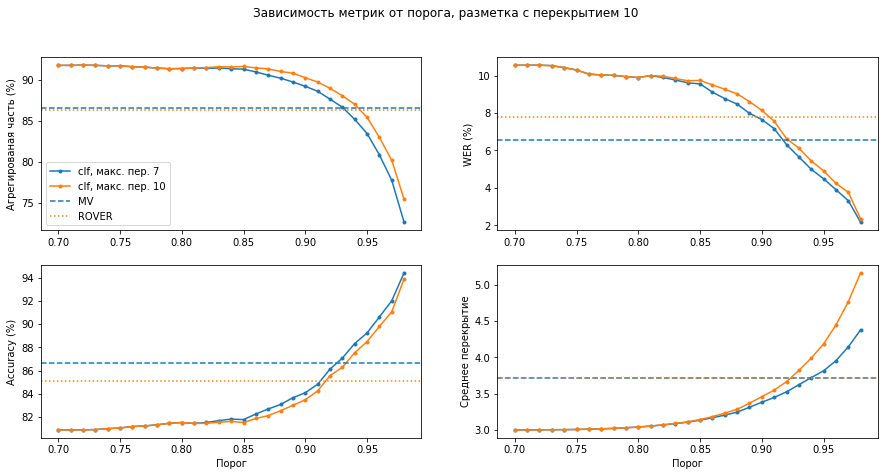

In [50]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, разметка с перекрытием 10')
plt.subplot(221)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7")
plt.plot(scores_clf_quasar_new_max_cost_10[:, 0], 
         scores_clf_quasar_new_max_cost_10[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 10")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.axhline(y=rover_agg_metrics[0] * 100, color=u'#ff7f0e', linestyle=':', label="ROVER")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 2] * 100, 
         ".-")
plt.plot(scores_clf_quasar_new_max_cost_10[:, 0], 
         scores_clf_quasar_new_max_cost_10[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[1] * 100, color=u'#ff7f0e', linestyle=':')

plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 3] * 100, 
         ".-")
plt.plot(scores_clf_quasar_new_max_cost_10[:, 0], 
         scores_clf_quasar_new_max_cost_10[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[2] * 100, color=u'#ff7f0e', linestyle=':')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 4], 
         ".-")
plt.plot(scores_clf_quasar_new_max_cost_10[:, 0], 
         scores_clf_quasar_new_max_cost_10[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[3], color=u'#ff7f0e', linestyle=':')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_clf_new_quasar_true.png")
plt.show()

In [51]:
len(data_quasar_test_valid)

3651

In [52]:
from scipy.stats import norm

In [53]:
def err(value, n, conf=0.95):
    z = norm.ppf(conf)
    return z * np.sqrt(value * (1 - value) / n)

In [54]:
scores_clf_quasar_new_max_cost_7[:, 1]

array([0.91728294, 0.91728294, 0.91755683, 0.91728294, 0.91673514,
       0.91673514, 0.91563955, 0.91509176, 0.91399617, 0.91317447,
       0.91344837, 0.91399617, 0.91372227, 0.91399617, 0.91317447,
       0.91262668, 0.90933991, 0.90523144, 0.90167078, 0.89701452,
       0.89181046, 0.88578472, 0.8761983 , 0.86633799, 0.85154752,
       0.83429197, 0.80827171, 0.77732128, 0.72610244])

In [55]:
test_words_count = [
    len(row['text'].split()) for row in data_quasar_test_valid
]
test_words_count = sum(test_words_count)

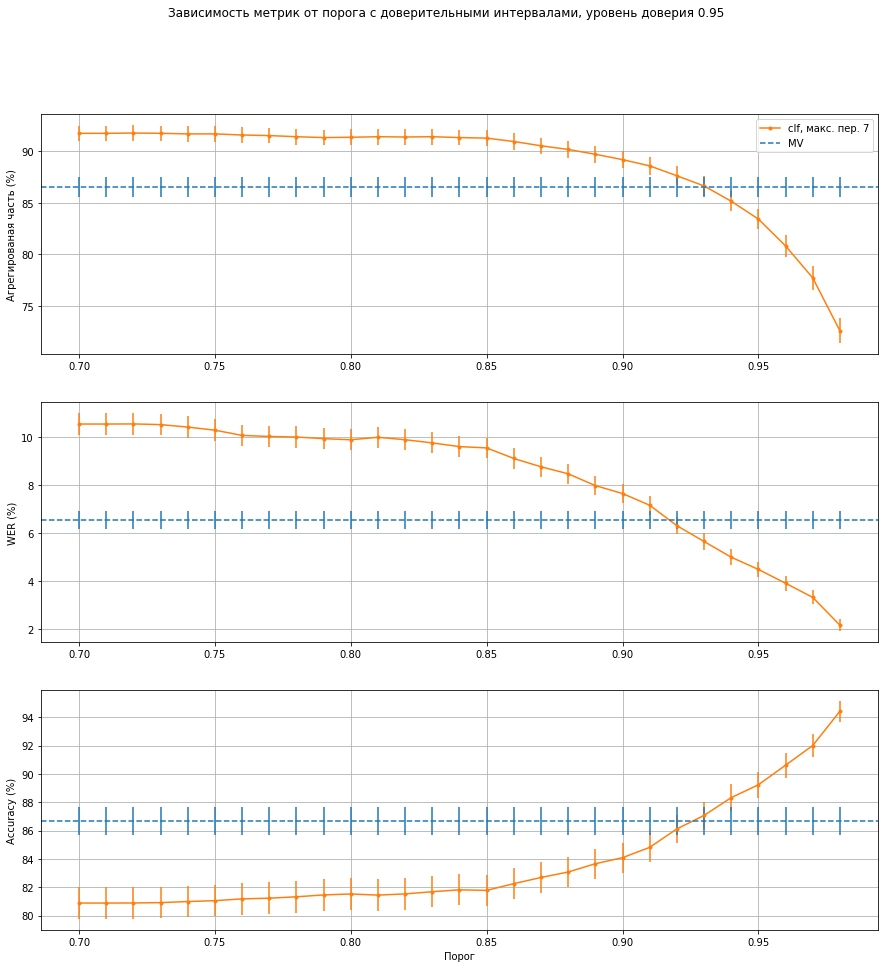

In [56]:
conf = 0.95

plt.figure(figsize=(15,15))
plt.suptitle('Зависимость метрик от порога с доверительными интервалами, уровень доверия {}'.format(conf))
plt.subplot(311)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7",
         color=u'#ff7f0e')
plt.errorbar(scores_clf_quasar_new_max_cost_7[:, 0],
            scores_clf_quasar_new_max_cost_7[:, 1] * 100,
            [err(val, len(data_quasar_test_valid), conf=conf) * 100 for val in
            scores_clf_quasar_new_max_cost_7[:, 1]],
            color=u'#ff7f0e',
            linestyle="None")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.errorbar(scores_clf_quasar_new_max_cost_7[:, 0],
            [prod_agg_metrics[0] * 100] * len(scores_clf_quasar_new_max_cost_7[:, 0]),
            [err(val, len(data_quasar_test_valid), conf=conf) * 100 for val in 
            [prod_agg_metrics[0]] * len(scores_clf_quasar_new_max_cost_7[:, 0])],
            color=u'#1f77b4',
            linestyle="None")
plt.ylabel('Агрегированая часть (%)')
plt.grid(True)
plt.legend()

plt.subplot(312)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 2] * 100, 
         ".-",
         color=u'#ff7f0e')
plt.errorbar(scores_clf_quasar_new_max_cost_7[:, 0],
            scores_clf_quasar_new_max_cost_7[:, 2] * 100,
            [err(val[2], val[5], conf=conf) * 100 for val in
            scores_clf_quasar_new_max_cost_7[:]],
            color=u'#ff7f0e',
            linestyle="None")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.errorbar(scores_clf_quasar_new_max_cost_7[:, 0],
            [prod_agg_metrics[1] * 100] * len(scores_clf_quasar_new_max_cost_7[:, 0]),
            [err(val, prod_agg_metrics[4], conf=conf) * 100 for val in 
            [prod_agg_metrics[1]] * len(scores_clf_quasar_new_max_cost_7[:, 0])],
            color=u'#1f77b4',
            linestyle="None")
plt.grid(True)
plt.ylabel('WER (%)')

plt.subplot(313)
plt.plot(scores_clf_quasar_new_max_cost_7[:, 0], 
         scores_clf_quasar_new_max_cost_7[:, 3] * 100, 
         ".-",
         color=u'#ff7f0e')
plt.errorbar(scores_clf_quasar_new_max_cost_7[:, 0],
            scores_clf_quasar_new_max_cost_7[:, 3] * 100,
            [err(metrics[3], metrics[1] * len(data_quasar_test_valid), conf=conf) * 100 for metrics in
            scores_clf_quasar_new_max_cost_7[:]],
            color=u'#ff7f0e',
            linestyle="None")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.errorbar(scores_clf_quasar_new_max_cost_7[:, 0],
            [prod_agg_metrics[2] * 100] * len(scores_clf_quasar_new_max_cost_7[:, 0]),
            yerr=[err(val, prod_agg_metrics[0] * len(data_quasar_test_valid), conf=conf) * 100 for val in 
            [prod_agg_metrics[2]] * len(scores_clf_quasar_new_max_cost_7[:, 0])],
            color=u'#1f77b4',
            linestyle="None")
plt.grid(True)
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.savefig("metrics_conf_int_quasar_true.png")
plt.show()

In [57]:
scores_clf_quasar_new_max_cost_7 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(data_quasar_test_valid, 
                                    data_quasar_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    treshhold,
                                    max_cost=7)
    scores_clf_quasar_new_max_cost_7.append((treshhold, *metrics))
scores_clf_quasar_new_max_cost_7 = np.array(scores_clf_quasar_new_max_cost_7)

0.7
Aggregated: 91.7283%
WER: 10.5550%
Accuracy: 80.8898%
Mean overlap: 3.001
0.71
Aggregated: 91.7283%
WER: 10.5550%
Accuracy: 80.8898%
Mean overlap: 3.001
0.72
Aggregated: 91.7557%
WER: 10.5596%
Accuracy: 80.8955%
Mean overlap: 3.002
0.73
Aggregated: 91.7283%
WER: 10.5310%
Accuracy: 80.9197%
Mean overlap: 3.004
0.74
Aggregated: 91.6735%
WER: 10.4272%
Accuracy: 80.9979%
Mean overlap: 3.005
0.75
Aggregated: 91.6735%
WER: 10.2992%
Accuracy: 81.0577%
Mean overlap: 3.007
0.76
Aggregated: 91.5640%
WER: 10.0802%
Accuracy: 81.1846%
Mean overlap: 3.011
0.77
Aggregated: 91.5092%
WER: 10.0353%
Accuracy: 81.2332%
Mean overlap: 3.016
0.7799999999999999
Aggregated: 91.3996%
WER: 10.0128%
Accuracy: 81.3305%
Mean overlap: 3.022
0.7899999999999999
Aggregated: 91.3174%
WER: 9.9446%
Accuracy: 81.4637%
Mean overlap: 3.031
0.7999999999999999
Aggregated: 91.3448%
WER: 9.8981%
Accuracy: 81.5292%
Mean overlap: 3.041
0.8099999999999999
Aggregated: 91.3996%
WER: 10.0008%
Accuracy: 81.4504%
Mean overlap: 3.054

In [58]:
print('toloka_results')
print('Prod: ')
prod_agg_metrics = evaluate_metrics(data_quasar_test_valid, 'toloka_results', aggregate_prod)

toloka_results
Prod: 
Aggregated: 86.5242%
WER: 6.5530%
Accuracy: 86.6730%
Mean overlap: 3.722


In [59]:
scores_clf_quasar_new_max_cost_7[-6:-3, 3] * 100 + [err(metrics[3], metrics[1] * len(data_quasar_test_valid), conf=conf) * 100 for metrics in
            scores_clf_quasar_new_max_cost_7[:]][-6:-3]

array([88.05058392, 89.27154665, 90.15561363])

In [60]:
def aggregate_rover_with_clf_and_empty_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, cluster_references=None):
    """
       aggregation from prod
    """
    clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                if score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [61]:
aggregation = aggregate_rover_with_clf_and_empty_(data_quasar_test_valid, 
                                    data_quasar_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.94,
                                    max_cost=7)

In [62]:
len(data_quasar_test)

3651

In [63]:
aggregation['100252/b49211fc-6442-43f6-94cf-ba2edb75d113_28a0c77f-2160-4389-a2fd-eadf12426369_17.opus'].text

'алиса'

In [64]:
def evaluate_metrics_from_dict(data, aggregation_results, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    words_count = 0
    aggregated_empty = 0
    false_empty = 0.0
    
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = aggregation_results[row["mds_key"]]
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        aggregated += 1
        words_count += len(row["text"].split())
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l
        if hyp == '':
            aggregated_empty += 1
            if row['text'] != '':
                false_empty += 1

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    if aggregated_empty:
        false_empty /= aggregated_empty
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}\nEmpty error part: {:.4%}".format(
            aggregated_part, wer, accuracy, cost, false_empty
        ))
    return aggregated_part, wer, accuracy, cost, words_count, false_empty

In [65]:
def evaluate_metrics_clf_and_empty_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True):
    aggregation_results = aggregate_rover_with_clf_and_empty_(data, 
                                                    features, 
                                                    field_name, 
                                                    clf, 
                                                    treshhold, 
                                                    min_cost, 
                                                    max_cost, 
                                                    cluster_refernces)
    return evaluate_metrics_from_dict(data, aggregation_results, treshhold, cluster_refernces, print_)

In [66]:
evaluate_metrics_clf_(data_quasar_test_valid, 
                                    data_quasar_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.91,
                                    max_cost=7)

Aggregated: 88.5785%
WER: 7.1637%
Accuracy: 84.8176%
Mean overlap: 3.448
Empty error part: 0.0000%


(0.885784716516023,
 0.07163681799250313,
 0.8481756338899196,
 3.4483703095042455,
 12005,
 0.0)

In [67]:
evaluate_metrics_clf_and_empty_(data_quasar_test_valid, 
                                    data_quasar_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.92,
                                    max_cost=7)

Aggregated: 94.3577%
WER: 7.5774%
Accuracy: 85.9507%
Mean overlap: 3.526
Empty error part: 16.2602%


(0.9435771021637908,
 0.0757740131853459,
 0.8595065312046444,
 3.5256094220761436,
 11983,
 0.16260162601626016)

In [68]:
evaluate_metrics_clf_(data_quasar_test_valid, 
                                    data_quasar_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.92,
                                    max_cost=7)

Aggregated: 87.6198%
WER: 6.3108%
Accuracy: 86.1207%
Mean overlap: 3.526
Empty error part: 0.0000%


(0.8761983018351137,
 0.06310802808561035,
 0.8612066270709596,
 3.5256094220761436,
 11821,
 0.0)

In [69]:
len(data_quasar_test_valid)

3651

In [70]:
for row in data_quasar_test_valid:
    if row["mark"] != "TEST":
        continue
    key = row["mds_key"]
    value = aggregation[key]
    if value.text == "" and row["text"] != "":
        if row["spotter_mds_key"]:
            print("https://speechbase-yt.voicetech.yandex.net/getaudio/" + row["spotter_mds_key"] + "?norm=1") 
        print(
            "https://speechbase-yt.voicetech.yandex.net/getaudio/" + key + "?norm=1"
        ) 
        print(str(value))
        print(row["text"])

https://speechbase-yt.voicetech.yandex.net/getaudio/1027067/30538f6c-686b-4811-8b6d-01486d45aef8_846ebd6d-1373-4b9b-bad8-8784ca089eb8_3.opus?norm=1
AggregationResult(text='', confidence=0.955423163785131, cost=6)
нет
https://speechbase-yt.voicetech.yandex.net/getaudio/1032344/e3ad5831-d866-497e-a354-b68c409e3b3d_a05b0064-6ea1-48fa-9315-dbf01f55bd07_23.opus?norm=1
AggregationResult(text='', confidence=0.9472843346045997, cost=7)
ну вперед
https://speechbase-yt.voicetech.yandex.net/getaudio/105256/b0bc98af-470b-40f4-a522-fc797b5107e7_86007d22-2dc7-43d8-b713-a11eccd4a046_99.opus?norm=1
AggregationResult(text='', confidence=0.9673549696895155, cost=6)
давай
https://speechbase-yt.voicetech.yandex.net/getaudio/142699/c8c3c9f5-ebf9-4b12-a097-ab5b4262dd8b_a243d245-b4b2-4fa8-b6f7-7d5409075275_15.opus?norm=1
AggregationResult(text='', confidence=0.9400431053965288, cost=7)
полноценно заменить человека в таких профессиях как учителя врачи
https://speechbase-yt.voicetech.yandex.net/getaudio/153449

In [73]:
clf_new.save_model("quasar_with_spotter_2019-09-23_prototype.clf")

In [80]:
sum(1 for x in data_quasar_test_valid if x["spotter_mds_key"] == None)/len(data_quasar_test_valid) * 100.0

6.683100520405369

In [81]:
sum(1 for x in data_quasar_test_valid if x["spotter_mds_key"] == None and x["text"] == "")/ sum(1 for x in data_quasar_test_valid if x["text"] == "")* 100.0

96.31147540983606